In [3]:
# Suppress TensorFlow warnings
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# Standard library imports
import time
from collections import Counter

# Data manipulation and numerical computing
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# TensorFlow and Keras
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.regularizers import l2
from tensorflow.keras import Input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, MaxPooling2D, Dropout, Flatten, Dense, GlobalAveragePooling2D, Reshape, Multiply
from tensorflow.keras.regularizers import l2

# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, mean_squared_error, r2_score

import cv2

from PIL import Image, ImageOps


E0000 00:00:1759878299.212565   18421 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1759878299.227338   18421 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1759878299.317232   18421 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1759878299.317256   18421 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1759878299.317257   18421 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1759878299.317259   18421 computation_placer.cc:177] computation placer already registered. Please check linka

## DATASET LOADING

In [3]:
def load_alphabet(file_path="Data/A_Z_Handwritten_Data.csv", label_offset=0, test_size=0.15, random_state=42):
    print("Loading alphabet CSV...")
    data = pd.read_csv(file_path)

    X = data.iloc[:, 1:].to_numpy().astype(np.float32)
    y = data.iloc[:, 0].to_numpy().astype(np.int32)
    
    del data
    
    X = X / 255.0
    y = y + label_offset

    X = X.reshape(-1, 28, 28)
    
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state
    )

    del X, y  
    
    print(f"Alphabet loaded: {X_train.shape[0]} train, {X_test.shape[0]} test samples")

    return X_train, X_test, y_train, y_test


def load_mnist():
    print("Loading MNIST digits dataset...")
    (X_train, y_train), (X_test, y_test) = mnist.load_data()
    
    X_train = X_train.squeeze() / 255.0
    X_test = X_test.squeeze() / 255.0
    y_train = y_train.astype(np.int32)
    y_test = y_test.astype(np.int32)
            
    print(f"MNIST loaded: {X_train.shape[0]} train, {X_test.shape[0]} test samples")

    return X_train, X_test, y_train, y_test


def load_emnist():
    print("Loading EMNIST ByMerge dataset...")
    (emnist_train, emnist_test), emnist_info = tfds.load(
        'emnist/bymerge',
        split=['train', 'test'],
        with_info=True,
        as_supervised=True
    )
    
    # Convert to NumPy arrays
    X_train = np.array([image.numpy() for image, label in emnist_train])
    y_train = np.array([label.numpy() for image, label in emnist_train])
    X_test = np.array([image.numpy() for image, label in emnist_test])
    y_test = np.array([label.numpy() for image, label in emnist_test])

    del emnist_train, emnist_test 
    
    X_train = X_train.squeeze() / 255.0
    X_test = X_test.squeeze() / 255.0
    y_train = y_train.astype(np.int32)
    y_test = y_test.astype(np.int32)

    print(f"EMNIST loaded: {X_train.shape[0]} train, {X_test.shape[0]} test samples")
    
    return X_train, X_test, y_train, y_test


def combine_datasets(X1, X2, y1, y2):
    return np.vstack((X1, X2)), np.append(y1, y2)


In [4]:
def load_combined_data(alphabet=False, mnist=False, emnist=False, 
                                alphabet_file_path="Data/A_Z_Handwritten_Data.csv",
                                test_size=0.15, random_state=42):
    
    X_train = np.empty((0, 28, 28), dtype=np.float32)
    X_test = np.empty((0, 28, 28), dtype=np.float32)
    
    y_train = np.array([])
    y_test = np.array([])
    
    alphabet_label_offset = 0
    
    # If both MNIST and EMNIST are selected, only use EMNIST
    if mnist and emnist:
        print("Note: Both mnist_digits and emnist selected. Using only EMNIST.")
        mnist_digits = False
        alphabet_label_offset = 10


    # Load MNIST digits
    if mnist:
        mnist_X_train, mnist_X_test, mnist_y_train, mnist_y_test = load_mnist()
        
        X_train, y_train = combine_datasets(X_train, mnist_X_train, y_train, mnist_y_train)
        X_test, y_test = combine_datasets(X_test, mnist_X_test, y_test, mnist_y_test)
        
        del mnist_X_train, mnist_X_test, mnist_y_train, mnist_y_test

        alphabet_label_offset = 10

    
    # Load EMNIST
    if emnist:
        emnist_X_train, emnist_X_test, emnist_y_train, emnist_y_test = load_emnist()

        X_train, y_train = combine_datasets(X_train, emnist_X_train, y_train, emnist_y_train)
        X_test, y_test = combine_datasets(X_test, emnist_X_test, y_test, emnist_y_test)

        del emnist_X_train, emnist_X_test, emnist_y_train, emnist_y_test

    
    # Load Alphabet
    if alphabet:
        alphabet_X_train, alphabet_X_test, alphabet_y_train, alphabet_y_test = load_alphabet(alphabet_file_path, label_offset=alphabet_label_offset)

        X_train, y_train = combine_datasets(X_train, alphabet_X_train, y_train, alphabet_y_train)
        X_test, y_test = combine_datasets(X_test, alphabet_X_test, y_test, alphabet_y_test)
        
        del alphabet_X_train, alphabet_X_test, alphabet_y_train, alphabet_y_test

    
    print(f"\nFinal combined dataset shape: {X_train.shape}")
    print(f"Labels range: {y_train.min()} to {y_train.max()}")
    
    return X_train, X_test, y_train, y_test


In [5]:
global alpha, alphanum, emnist
alpha, alphanum, emnist = False, False, True

In [10]:
X_train, X_test, y_train, y_test = load_combined_data(alphabet=False, mnist=False, emnist=True)

Loading EMNIST ByMerge dataset...
EMNIST loaded: 697932 train, 116323 test samples

Final combined dataset shape: (697932, 28, 28)
Labels range: 0.0 to 46.0


## DATASET INFO

In [4]:
def class_to_char(class_idx):
    if alpha:
        class_idx += 10
        
    mapping = {
        0: '0', 1: '1', 2: '2', 3: '3', 4: '4', 5: '5', 6: '6', 7: '7', 8: '8', 9: '9',
        10: 'A', 11: 'B', 12: 'C', 13: 'D', 14: 'E', 15: 'F', 16: 'G', 17: 'H', 18: 'I',
        19: 'J', 20: 'K', 21: 'L', 22: 'M', 23: 'N', 24: 'O', 25: 'P', 26: 'Q', 27: 'R',
        28: 'S', 29: 'T', 30: 'U', 31: 'V', 32: 'W', 33: 'X', 34: 'Y', 35: 'Z',
        36: 'a', 37: 'b', 38: 'd', 39: 'e', 40: 'f', 41: 'g', 42: 'h', 43: 'n', 44: 'q',
        45: 'r', 46: 't'
    }
    
    if class_idx in mapping:
        return mapping[class_idx]
    else:
        return "?"


def display_array_as_image(array, title="Preprocessed Image"):
    plt.imshow(array, cmap='gray')
    plt.title(title)
    plt.axis('off')
    plt.show()


def print_counts(counts):
    for char in sorted(counts):
        print(f"{class_to_char(char)} : {counts[char]} uzoraka")

In [14]:
train_counts = Counter(y_train)
test_counts = Counter(y_test)

combined_counts = {c: train_counts[c] + test_counts[c] for c in train_counts}

print_counts(combined_counts)

num_classes = len(np.unique(y_train))

0 : 40363 uzoraka
1 : 44704 uzoraka
2 : 40072 uzoraka
3 : 41112 uzoraka
4 : 39154 uzoraka
5 : 36606 uzoraka
6 : 39937 uzoraka
7 : 41893 uzoraka
8 : 39579 uzoraka
9 : 39533 uzoraka
A : 7469 uzoraka
B : 4526 uzoraka
C : 15119 uzoraka
D : 5341 uzoraka
E : 5785 uzoraka
F : 10622 uzoraka
G : 2964 uzoraka
H : 3673 uzoraka
I : 17146 uzoraka
J : 6601 uzoraka
K : 5807 uzoraka
L : 23739 uzoraka
M : 13596 uzoraka
N : 9588 uzoraka
O : 32354 uzoraka
P : 12560 uzoraka
Q : 3018 uzoraka
R : 5882 uzoraka
S : 27408 uzoraka
T : 11396 uzoraka
U : 17916 uzoraka
V : 8811 uzoraka
W : 8665 uzoraka
X : 6495 uzoraka
Y : 8287 uzoraka
Z : 6341 uzoraka
a : 11677 uzoraka
b : 6012 uzoraka
d : 11860 uzoraka
e : 28723 uzoraka
f : 2961 uzoraka
g : 4276 uzoraka
h : 10217 uzoraka
n : 13316 uzoraka
q : 3499 uzoraka
r : 16425 uzoraka
t : 21227 uzoraka


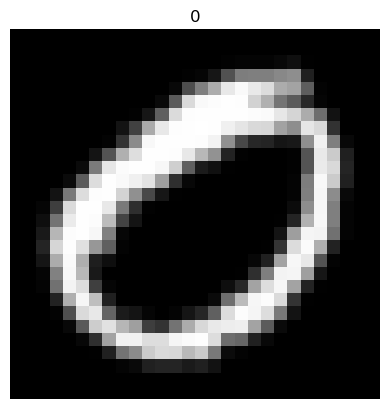

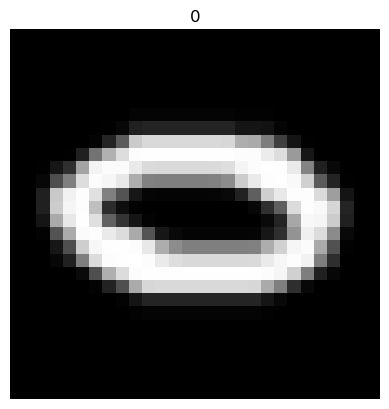

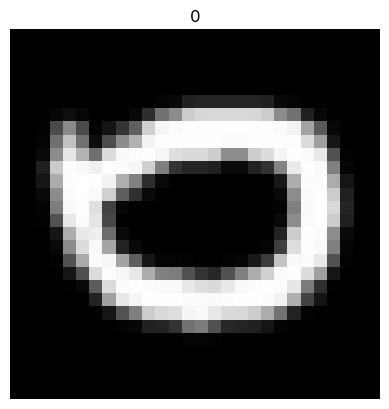

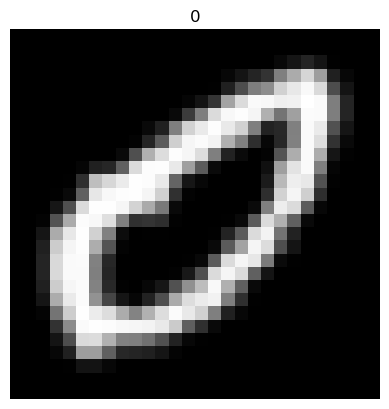

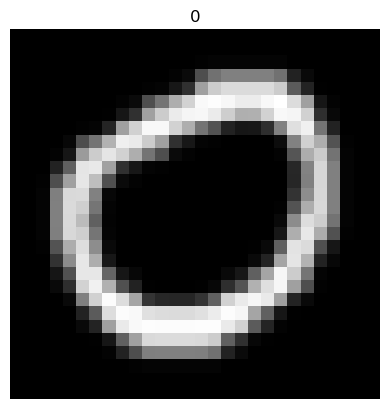

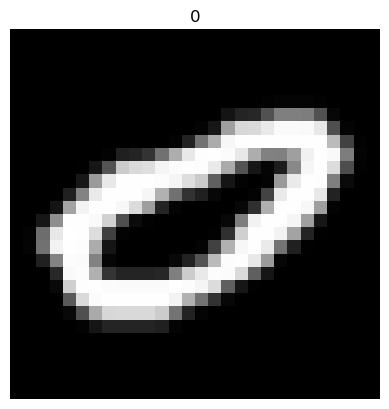

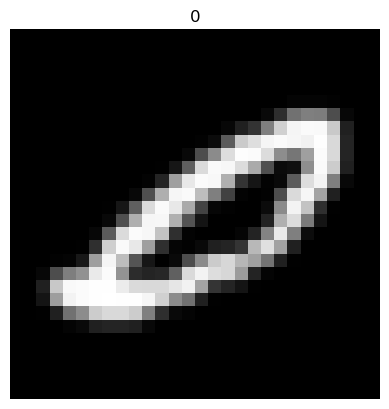

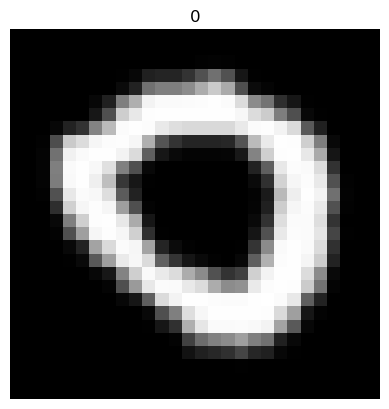

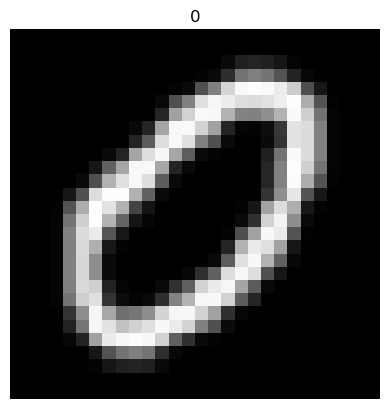

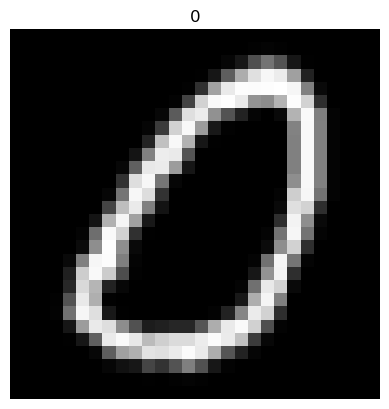

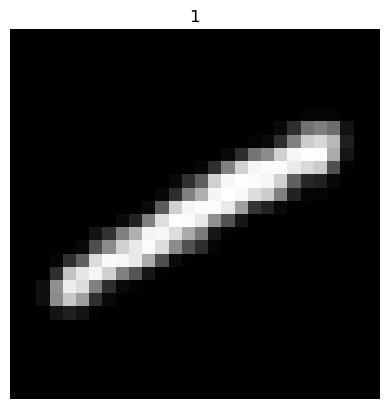

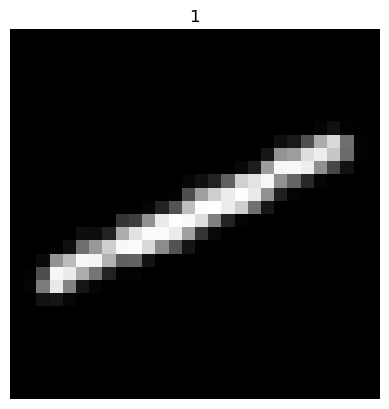

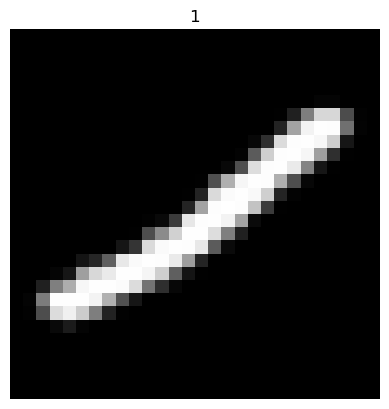

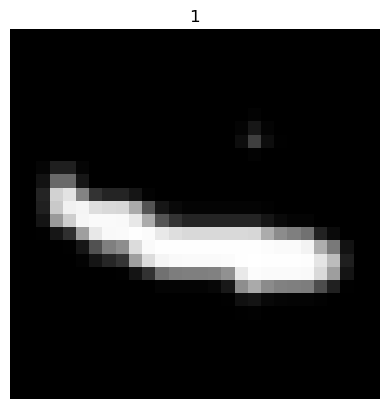

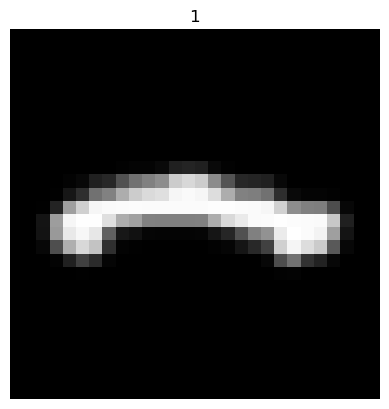

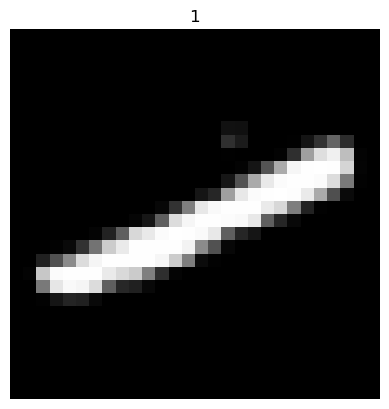

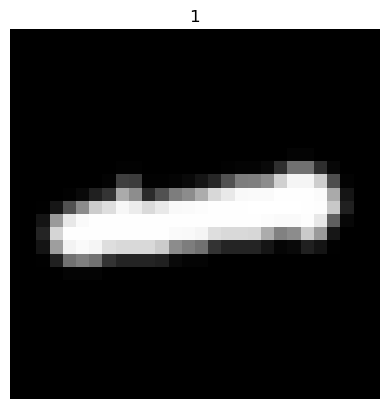

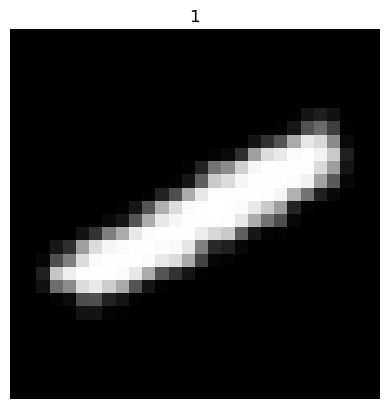

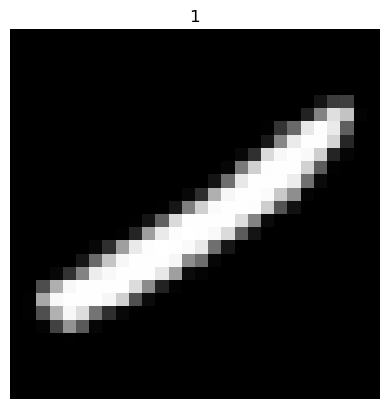

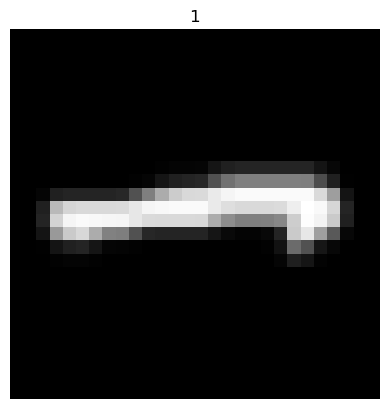

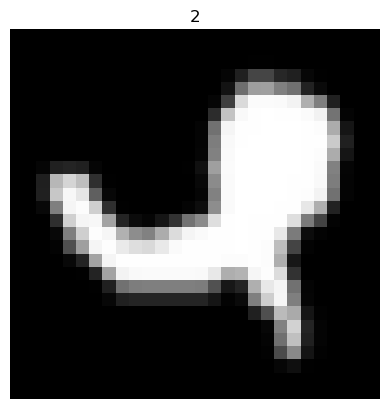

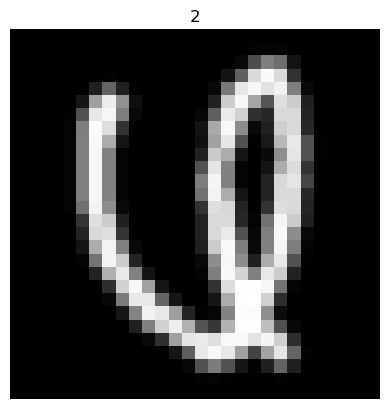

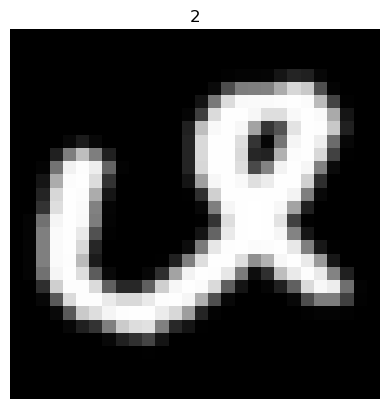

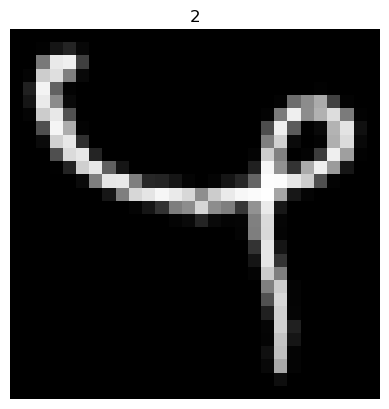

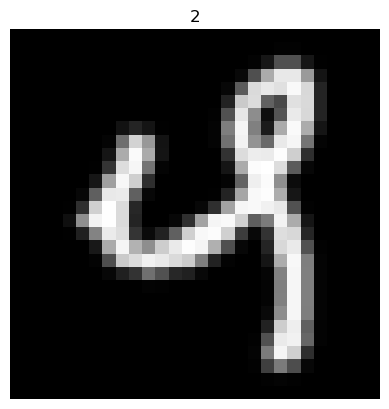

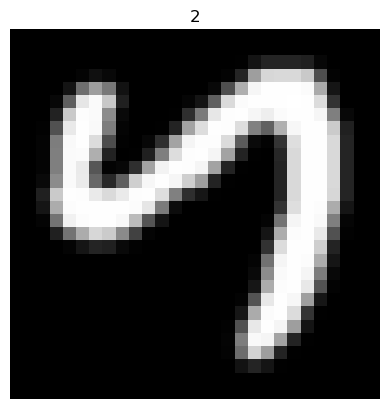

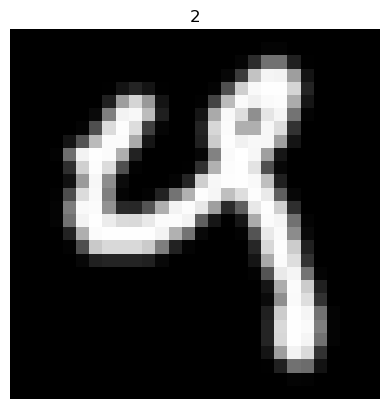

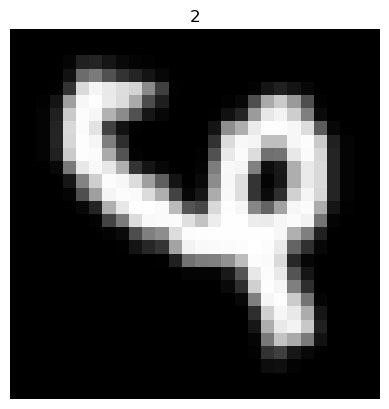

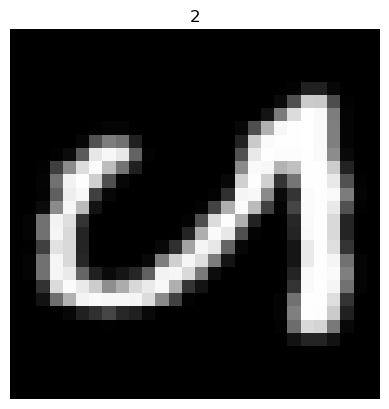

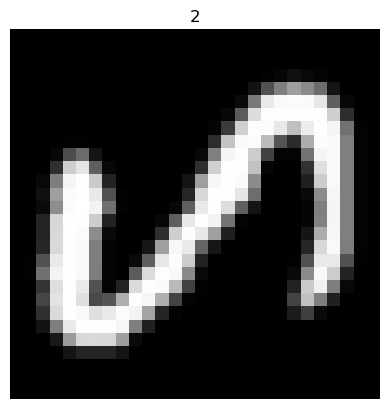

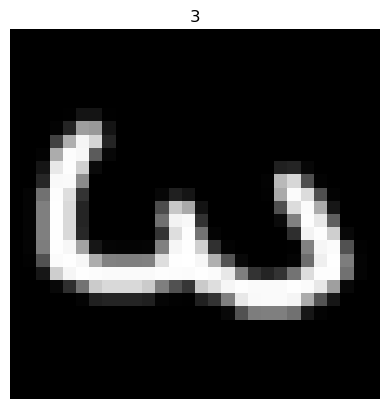

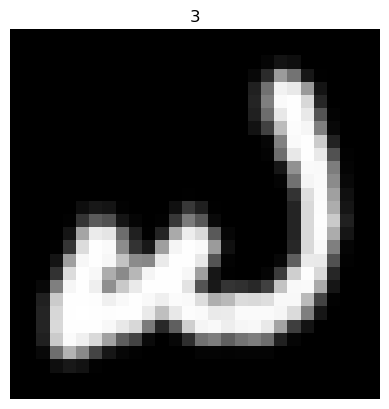

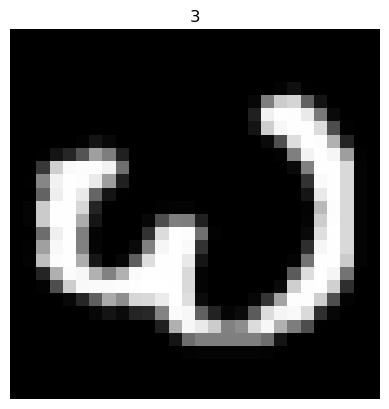

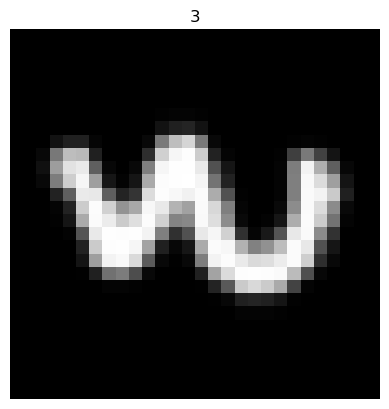

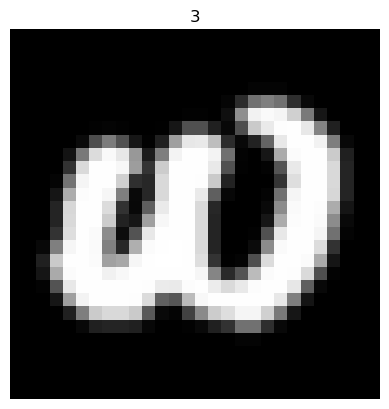

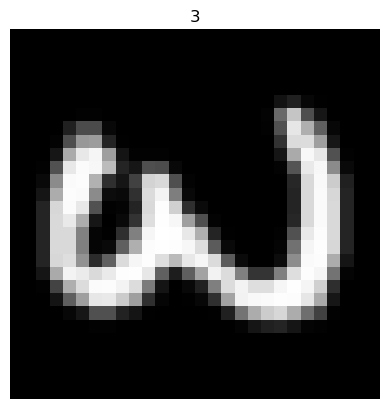

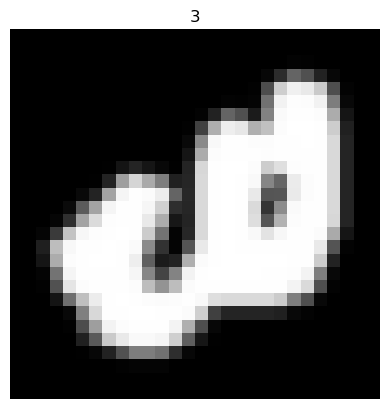

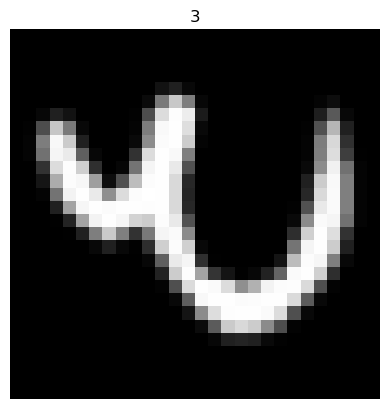

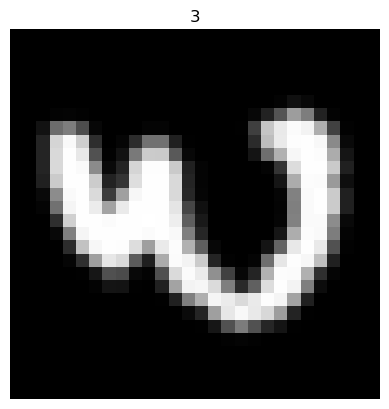

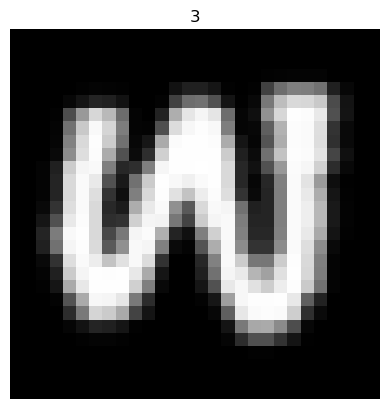

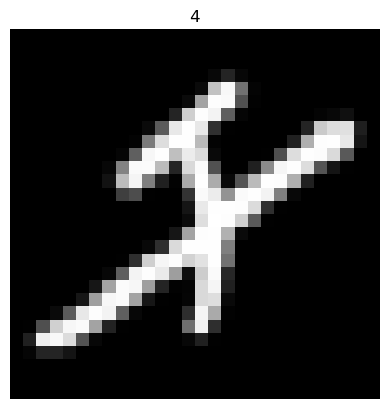

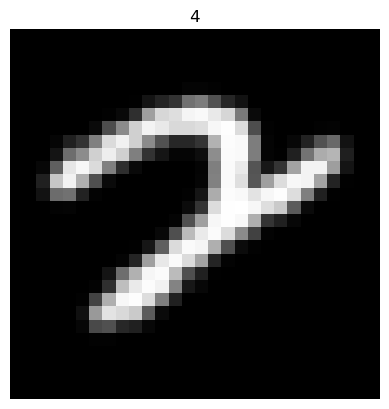

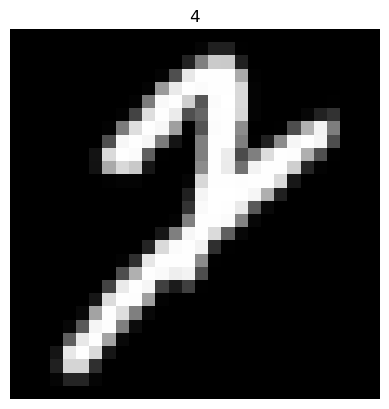

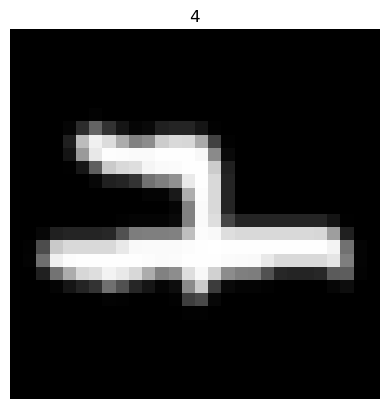

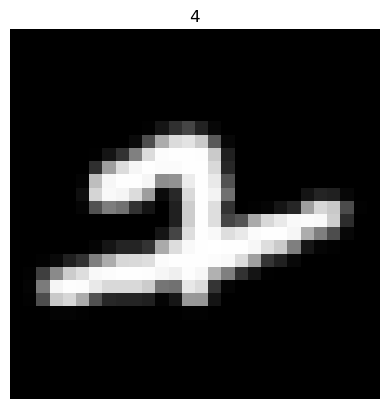

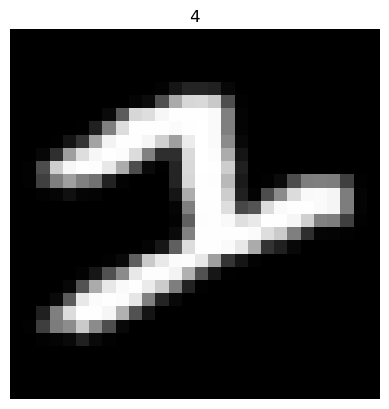

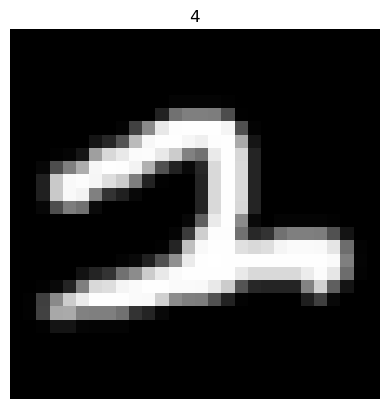

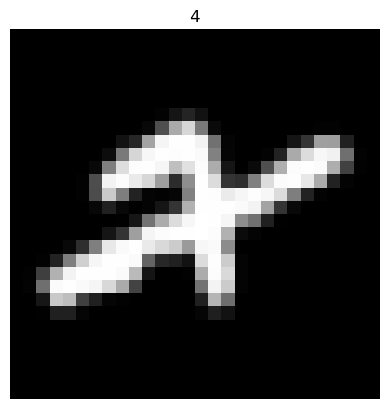

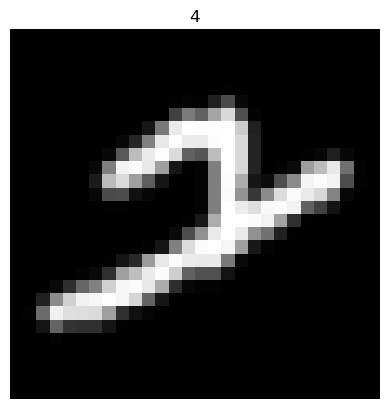

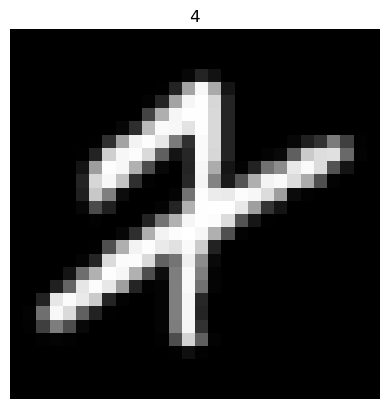

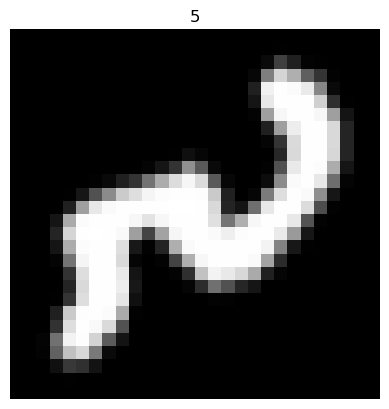

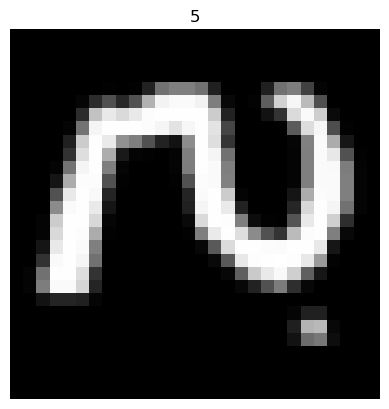

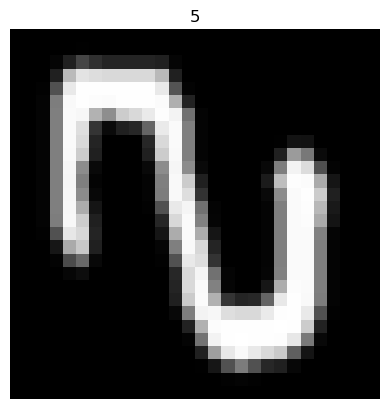

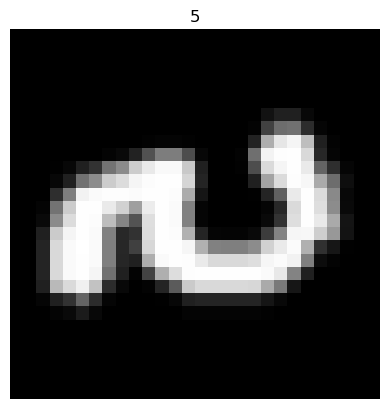

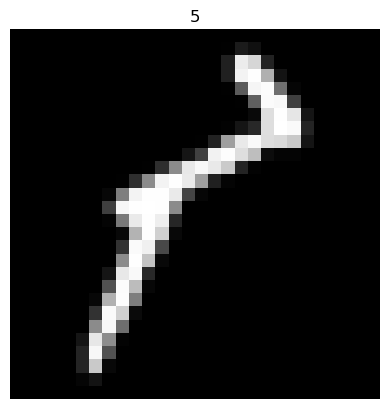

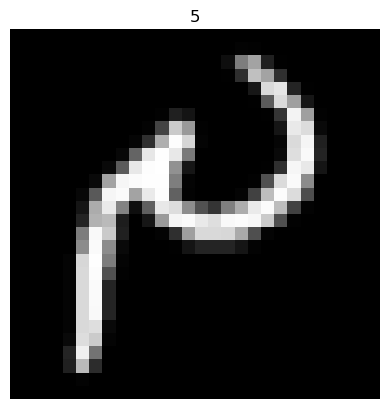

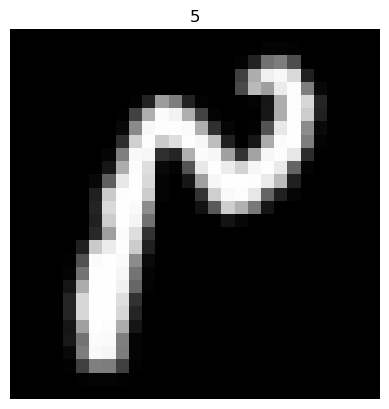

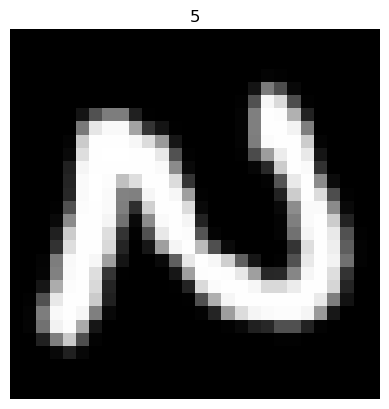

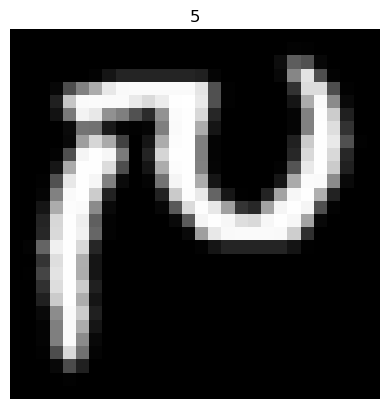

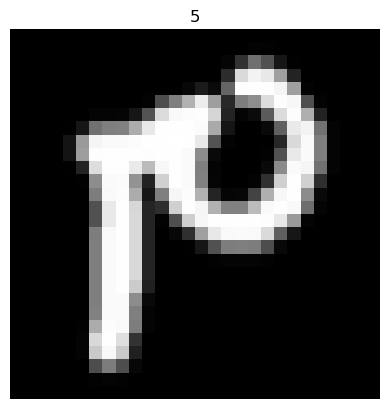

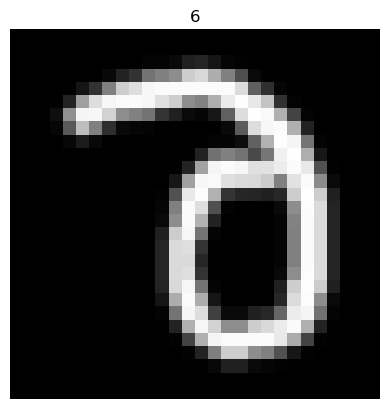

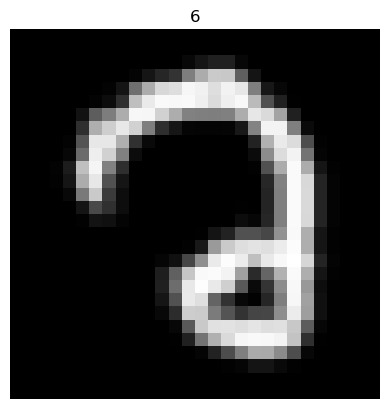

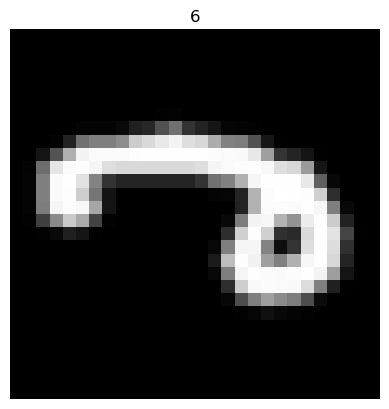

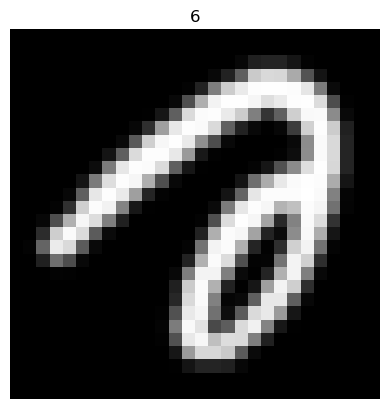

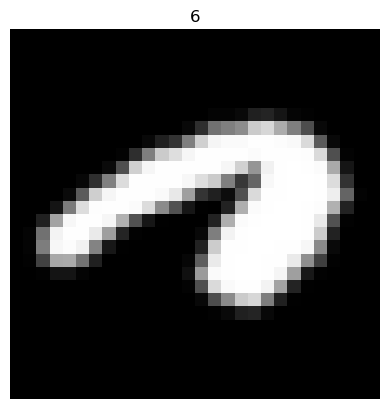

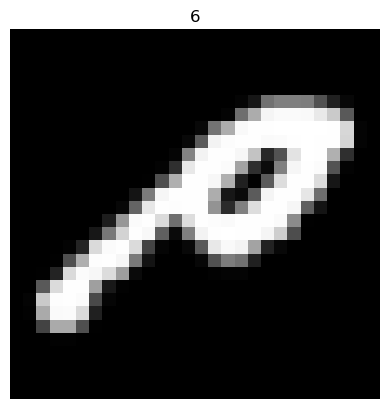

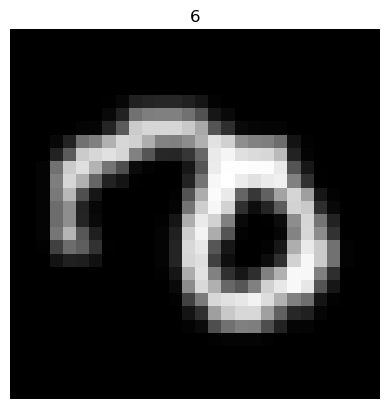

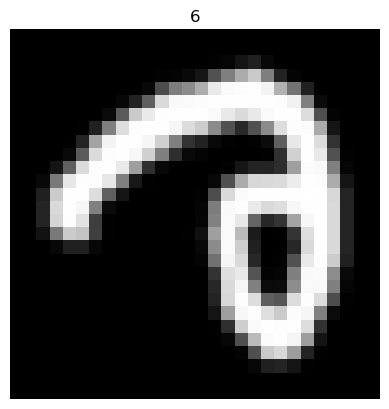

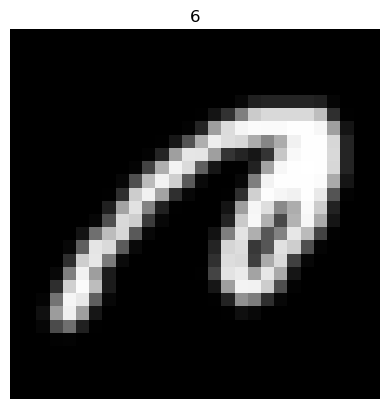

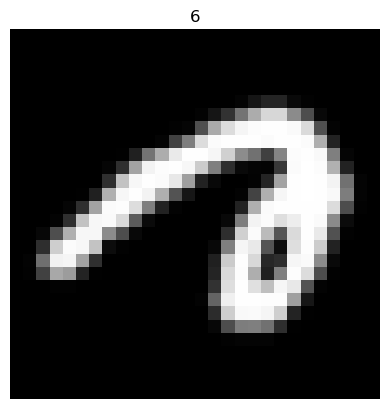

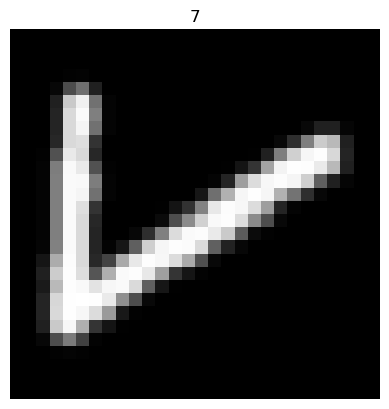

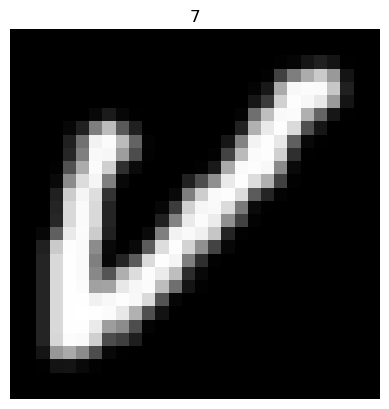

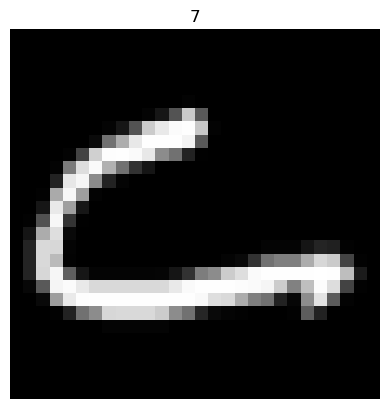

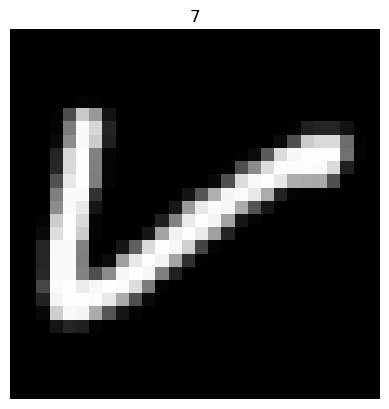

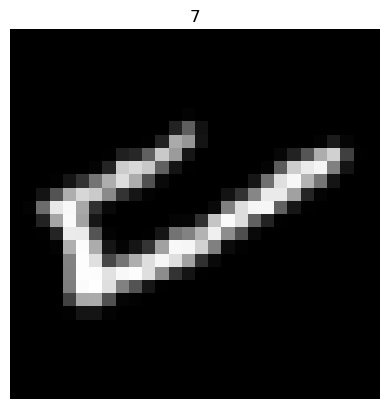

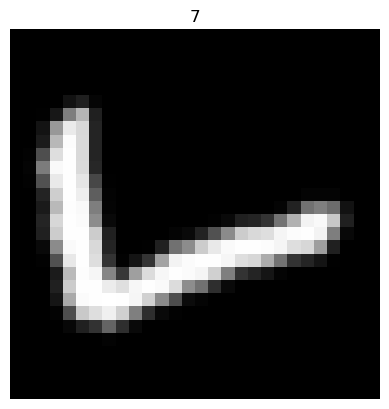

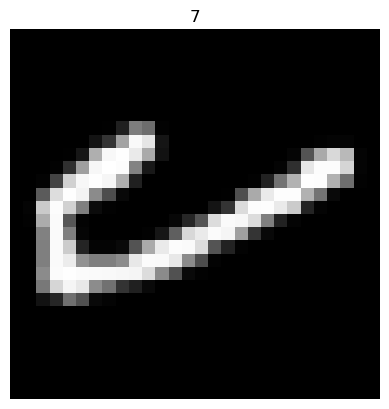

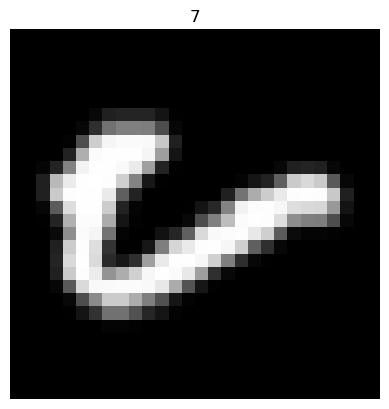

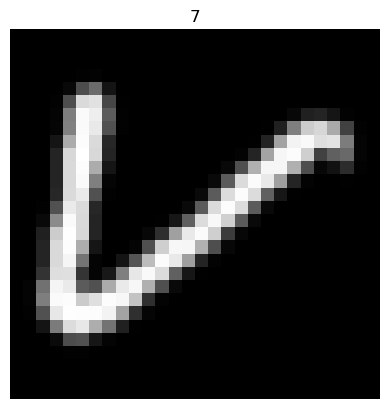

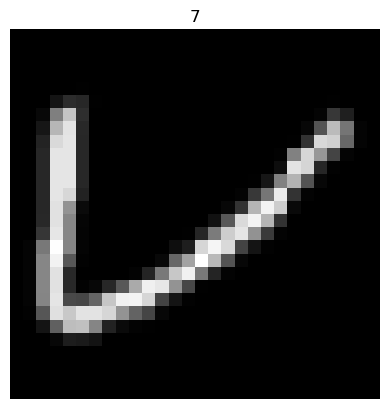

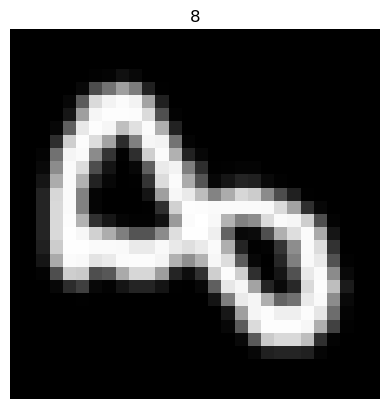

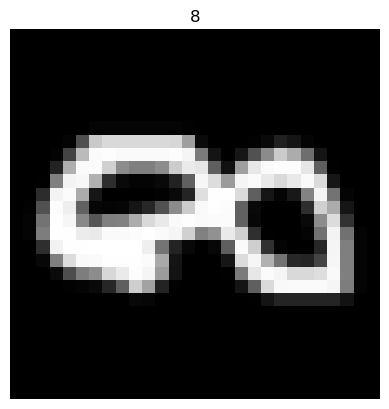

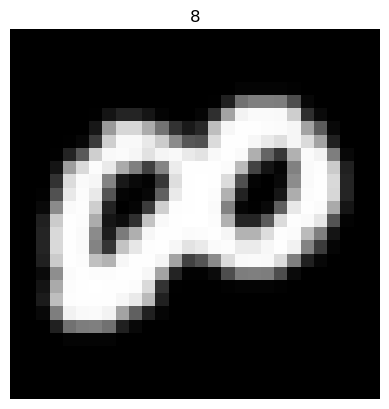

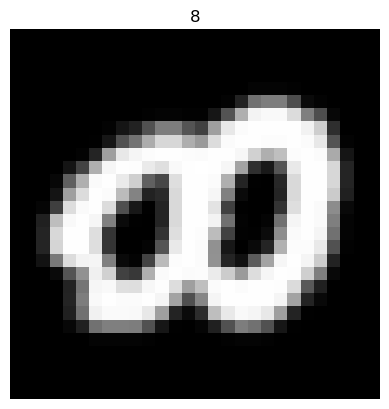

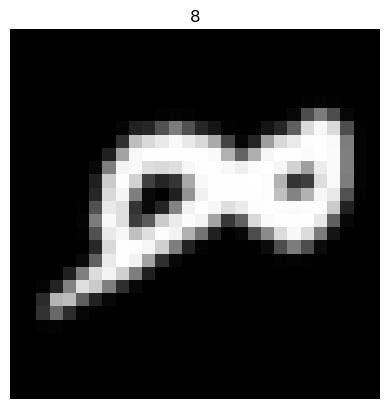

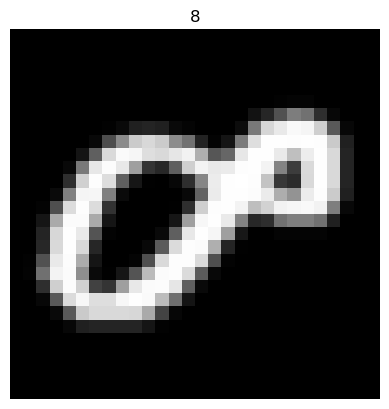

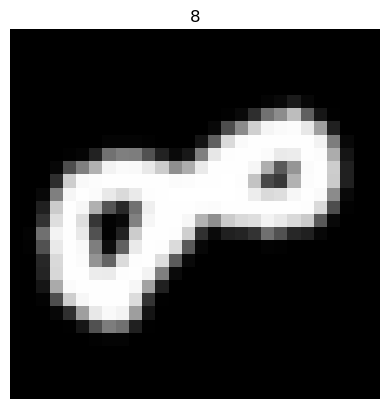

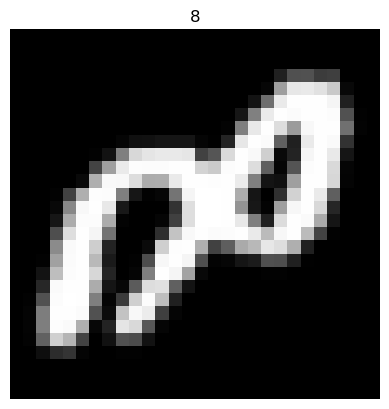

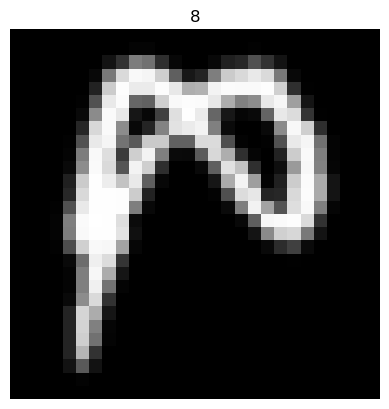

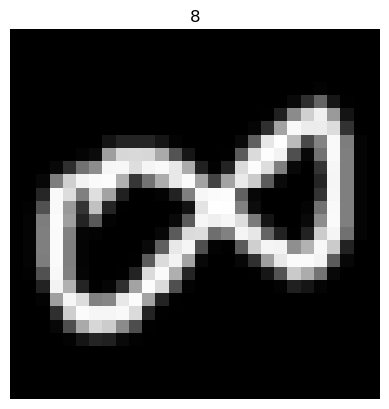

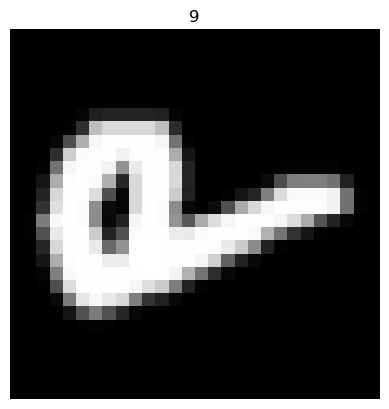

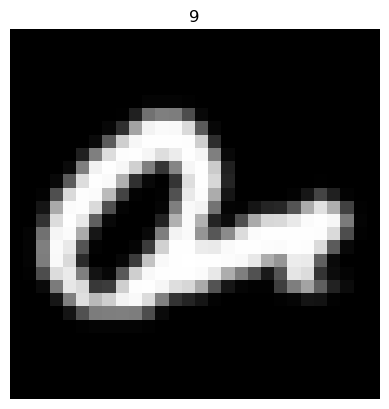

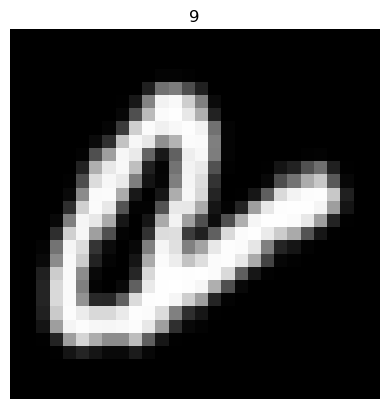

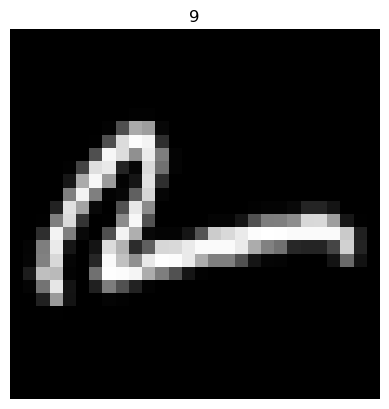

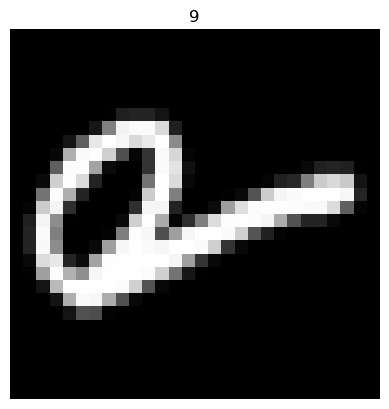

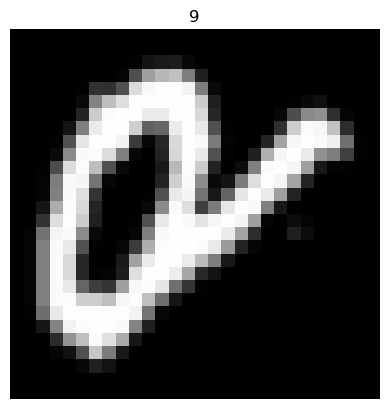

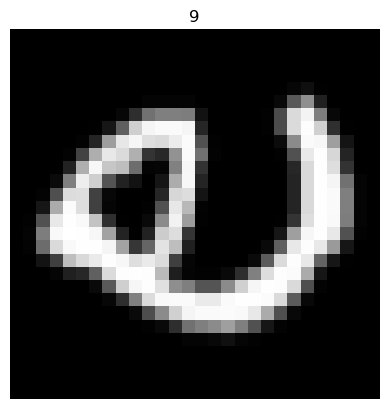

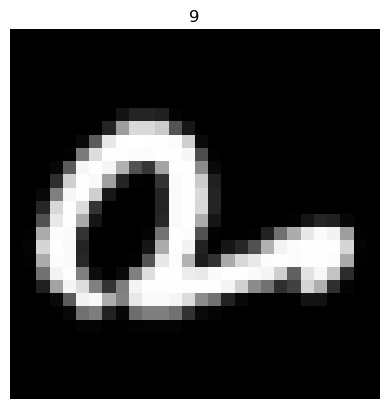

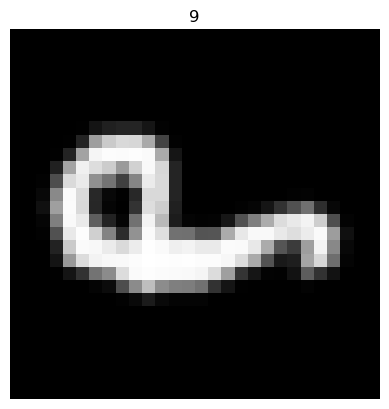

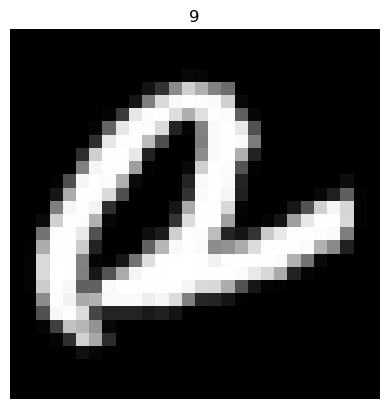

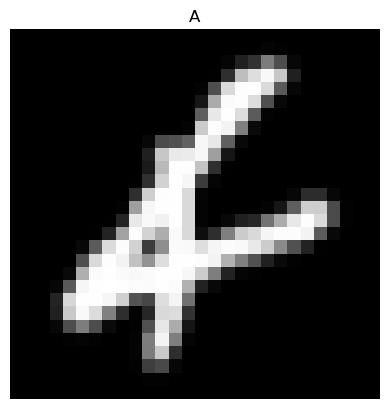

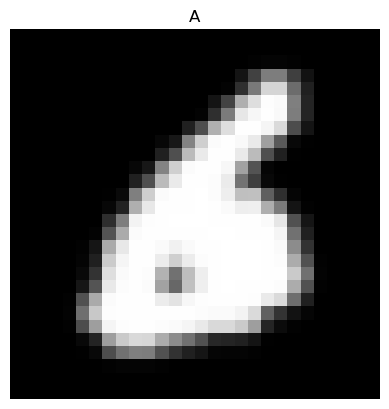

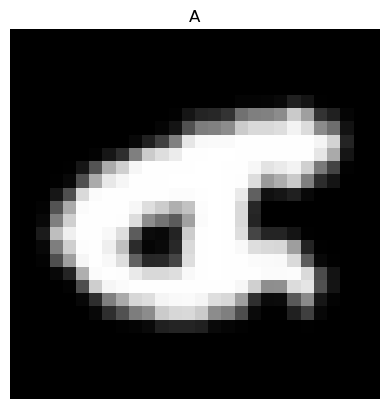

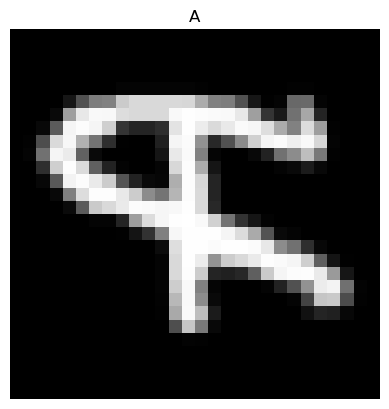

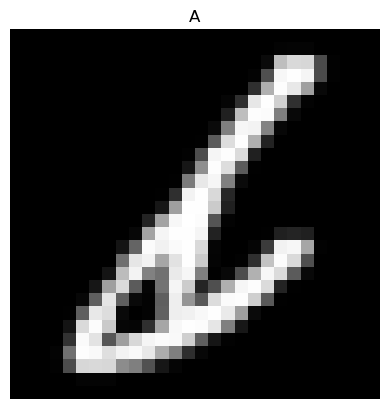

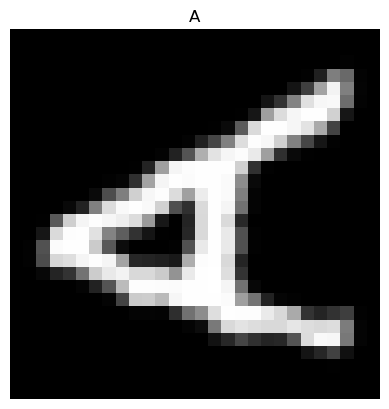

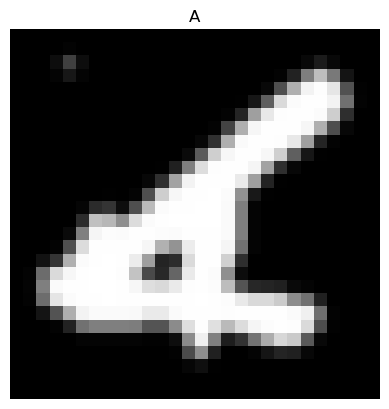

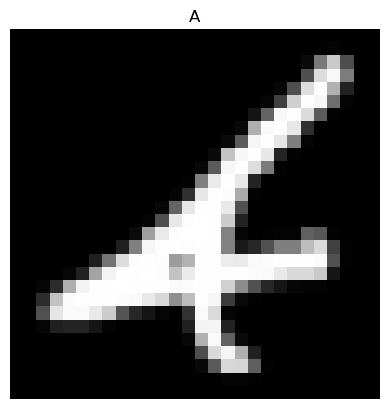

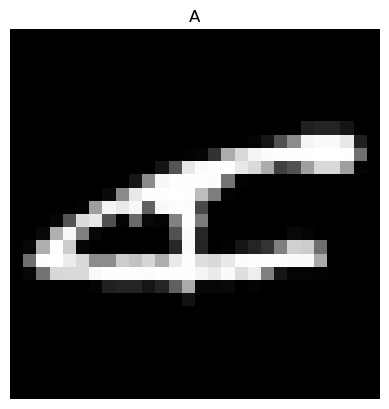

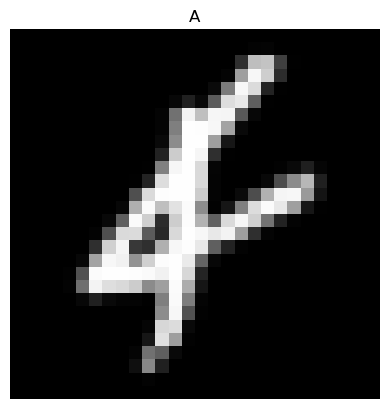

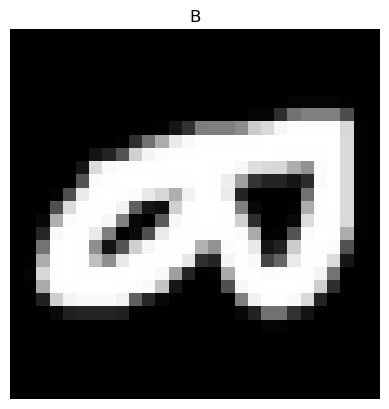

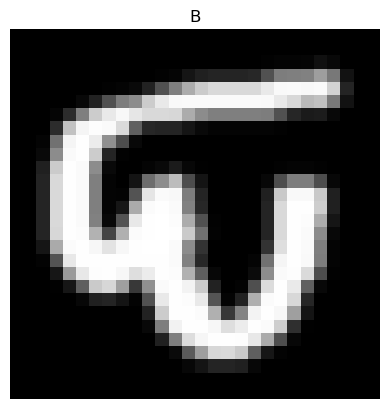

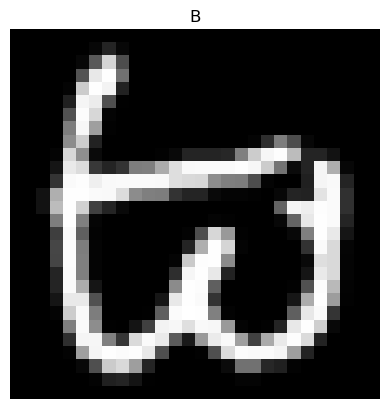

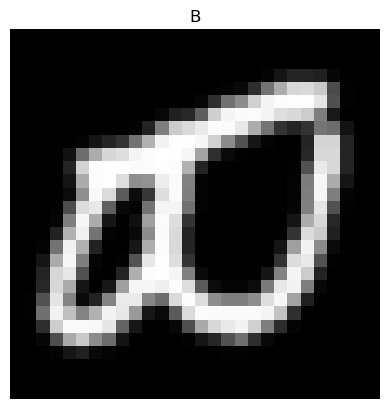

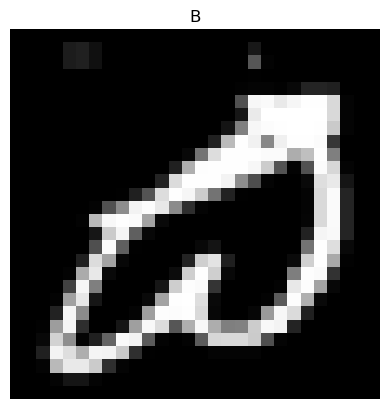

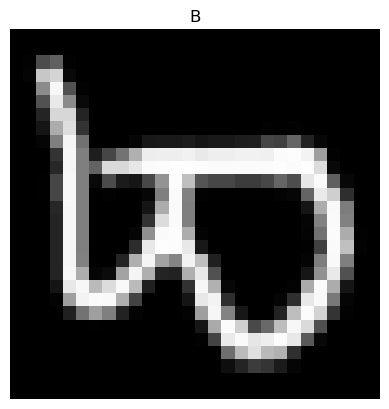

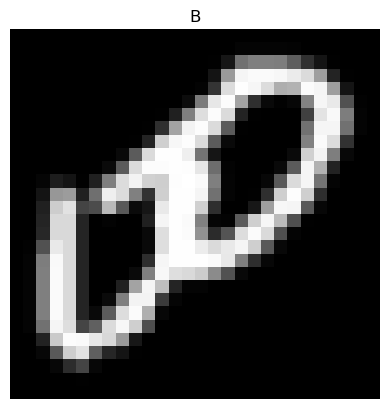

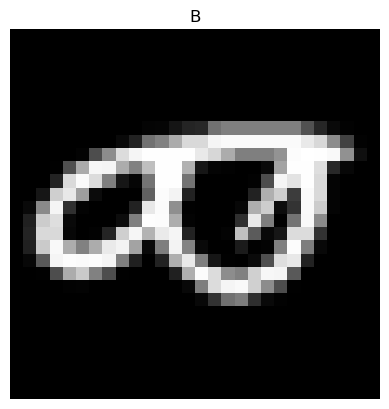

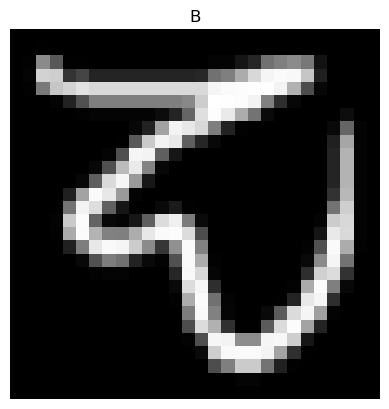

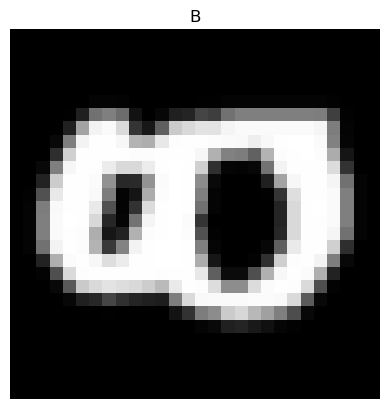

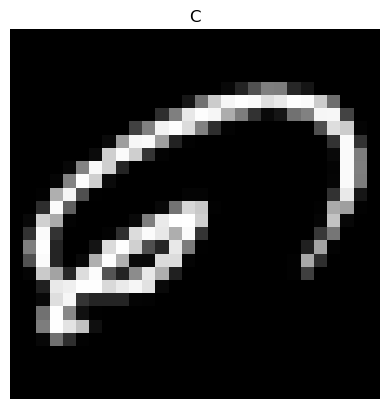

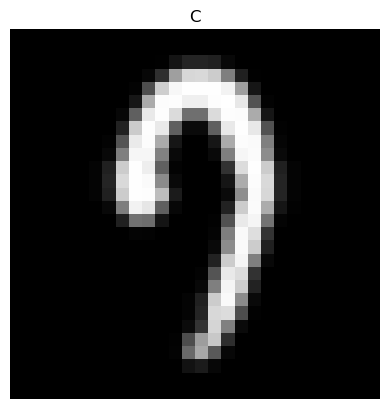

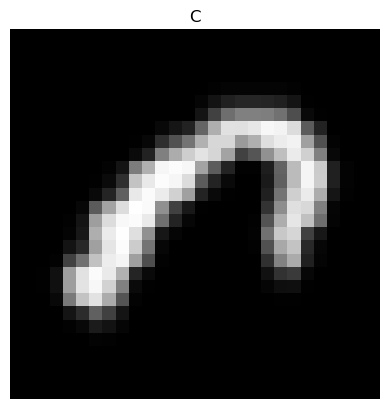

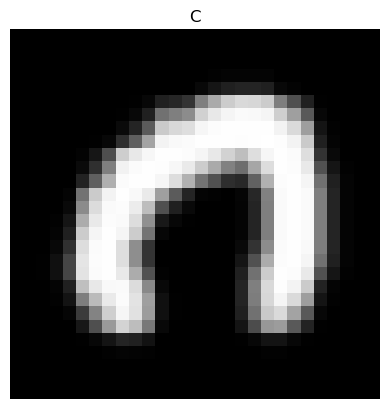

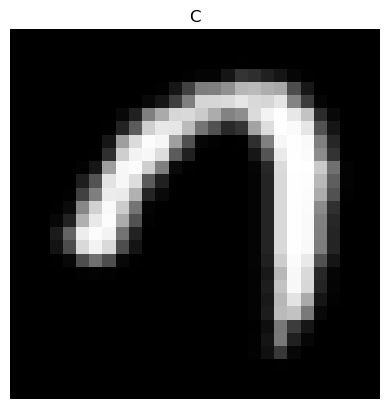

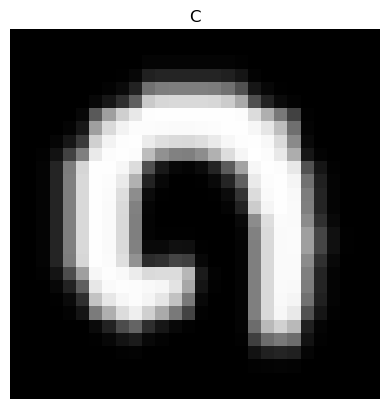

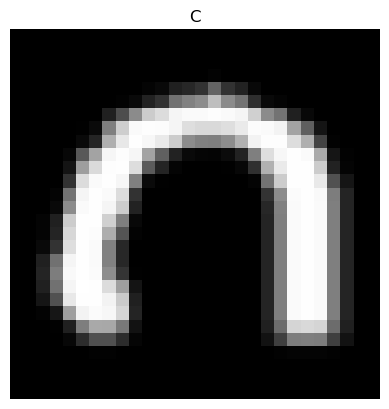

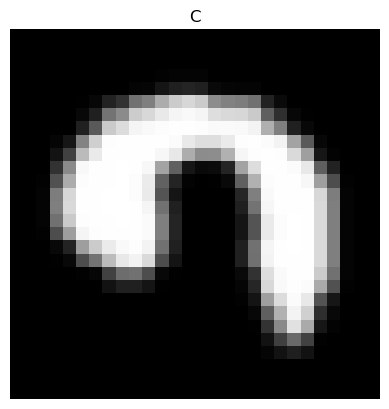

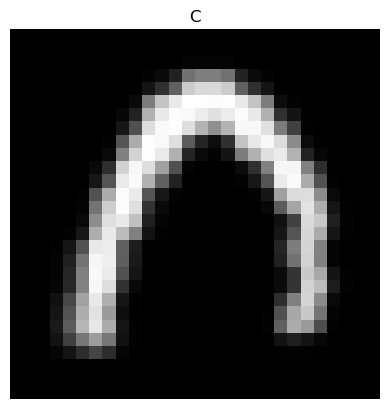

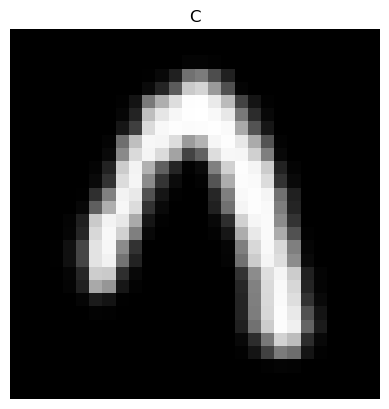

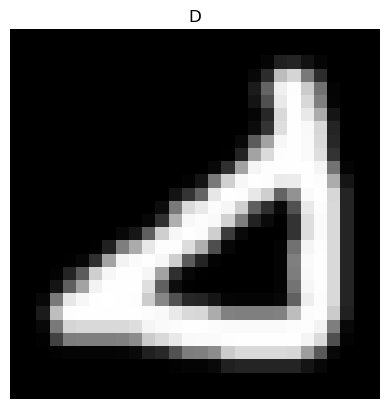

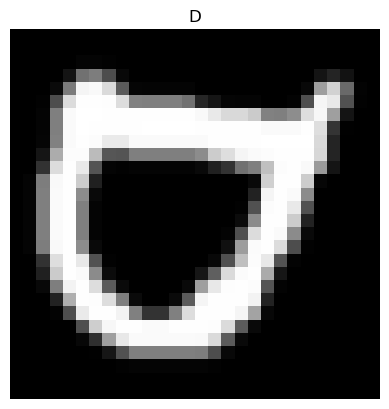

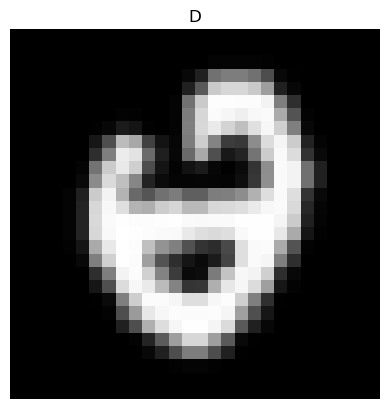

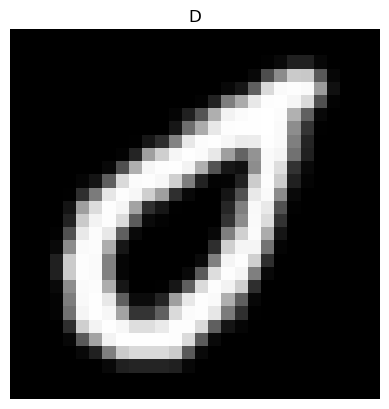

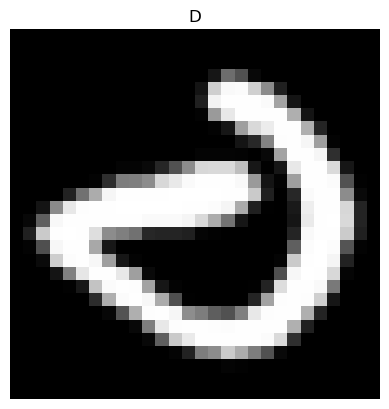

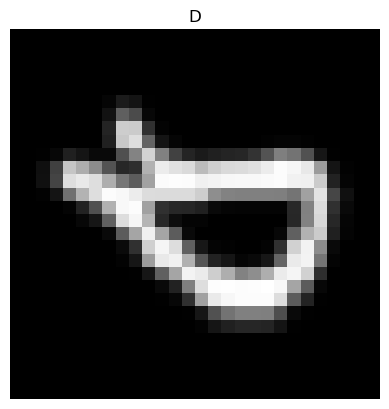

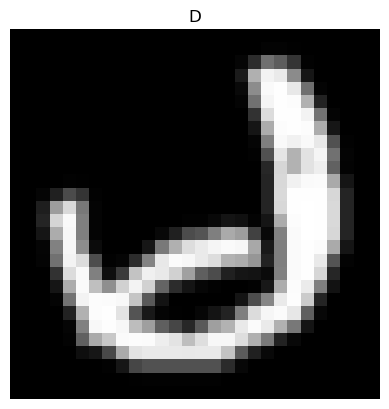

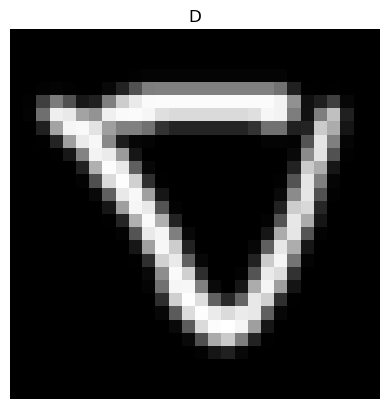

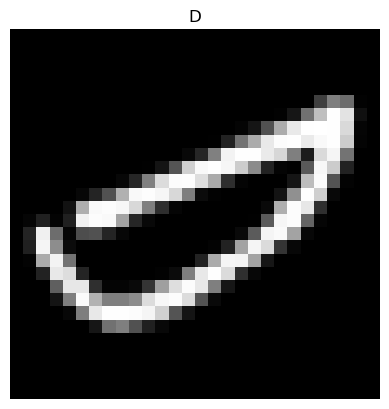

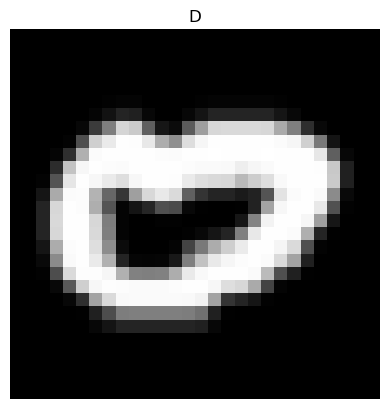

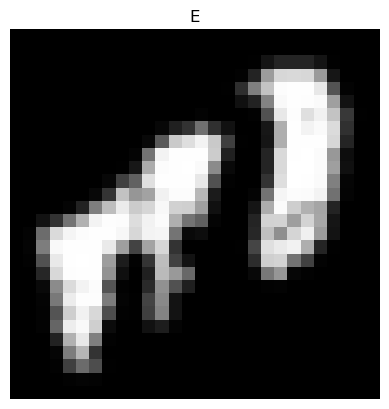

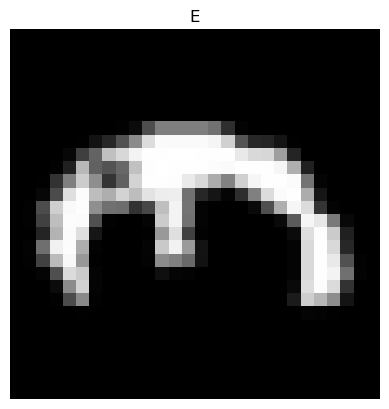

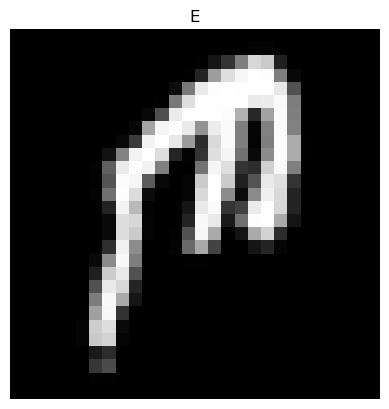

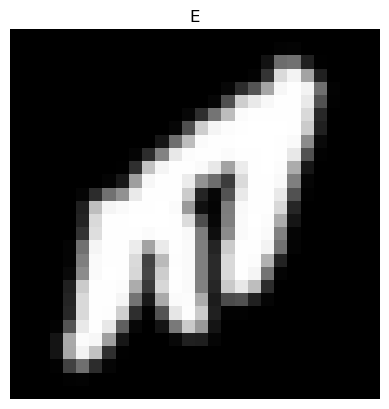

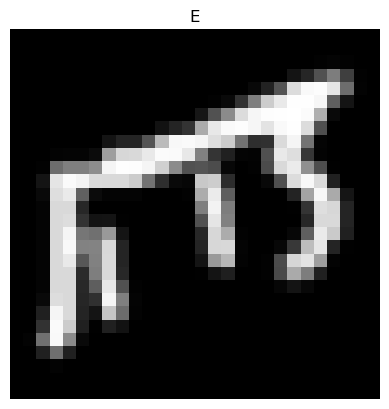

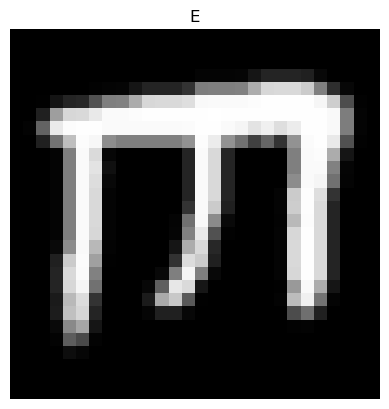

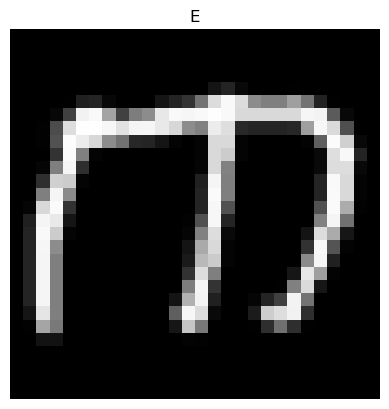

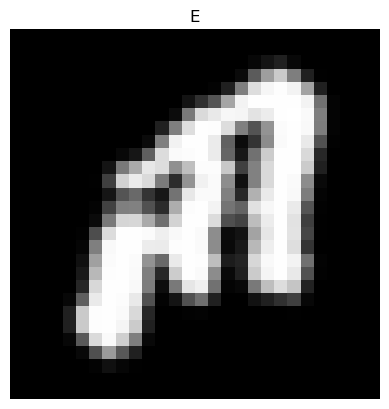

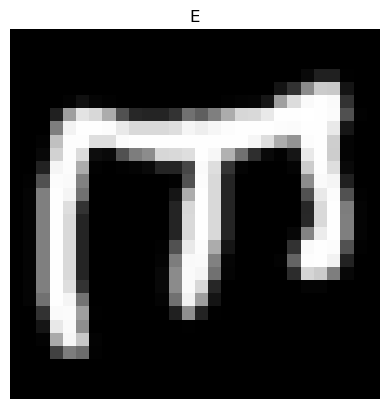

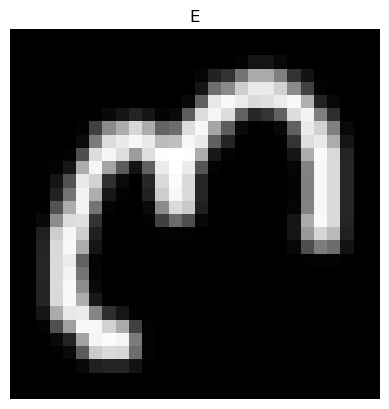

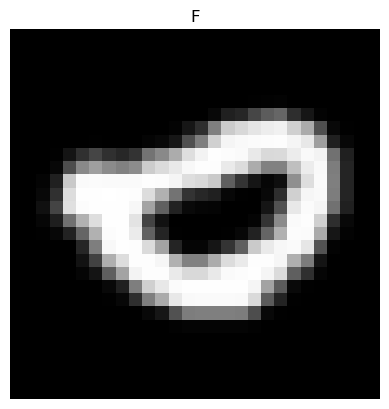

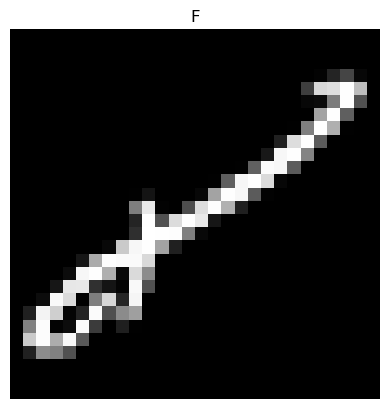

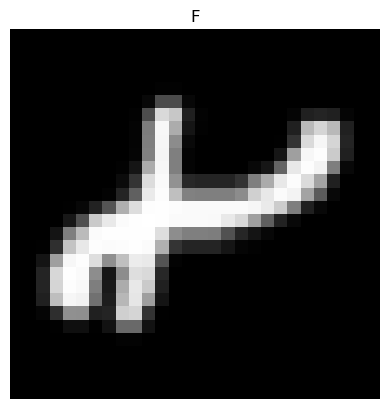

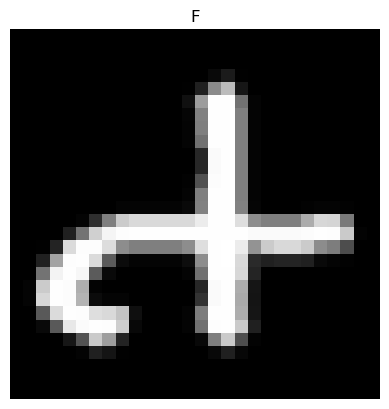

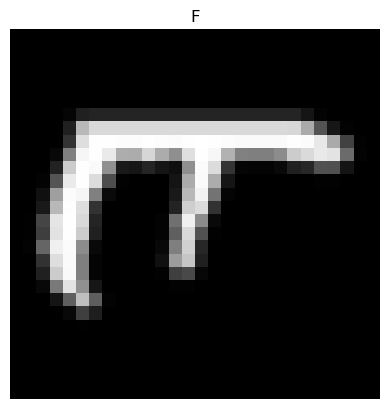

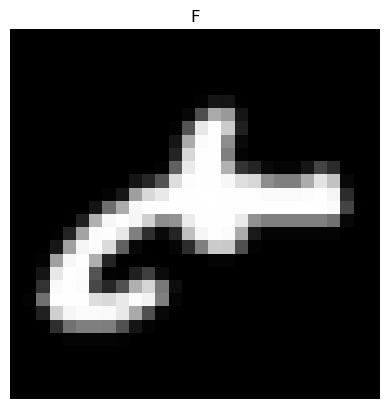

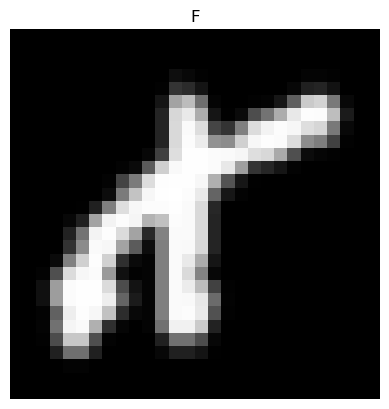

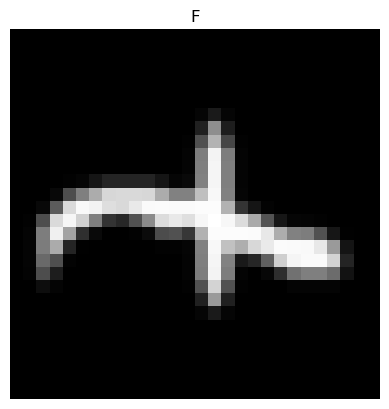

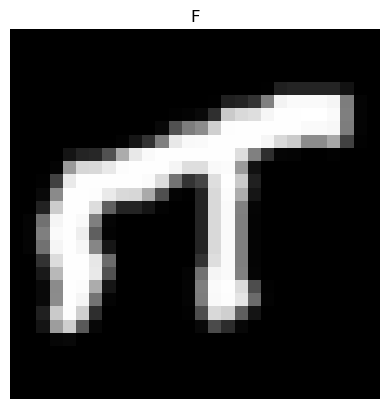

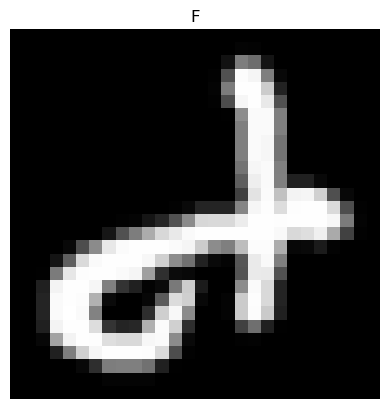

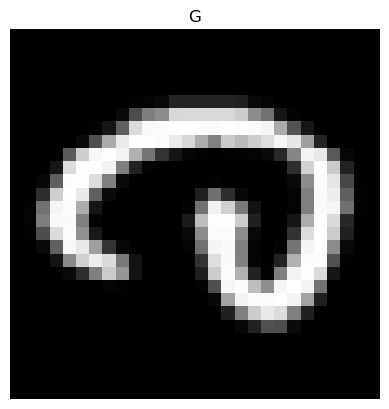

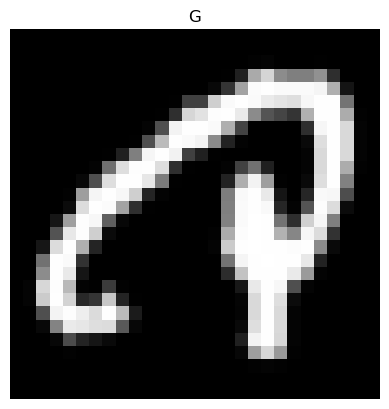

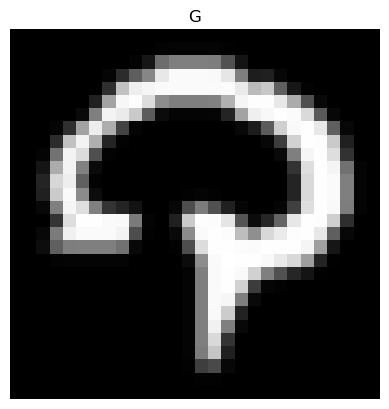

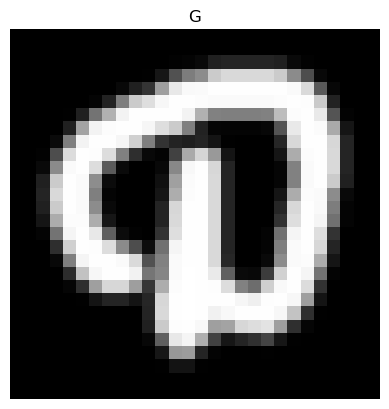

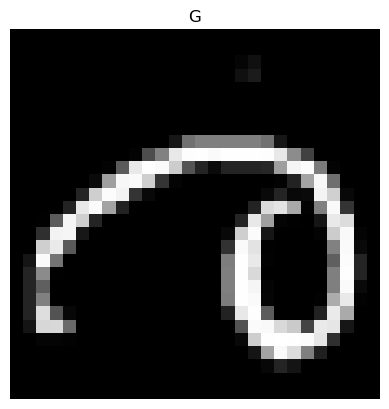

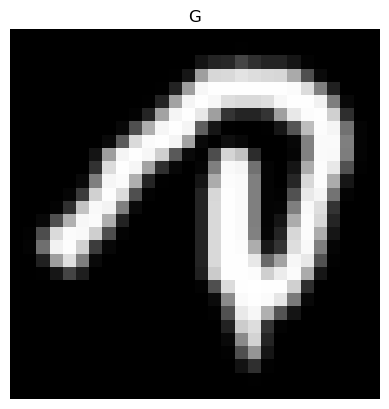

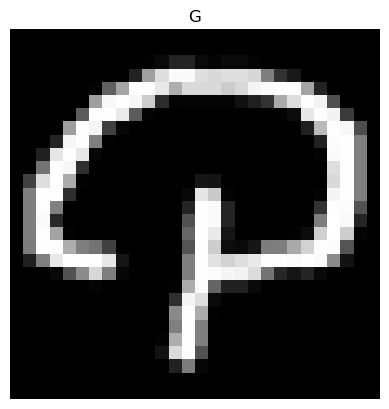

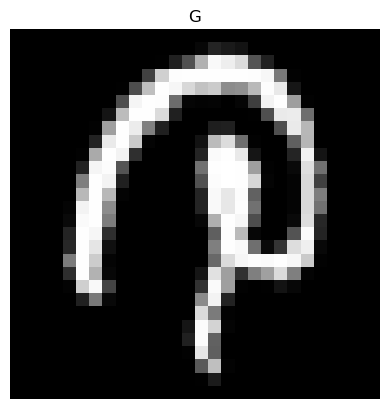

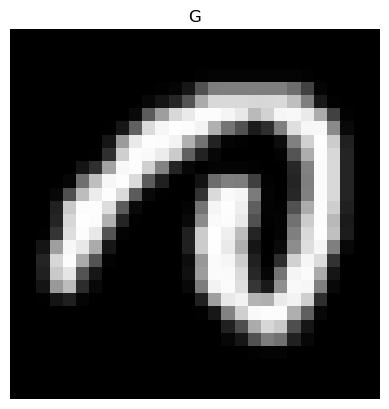

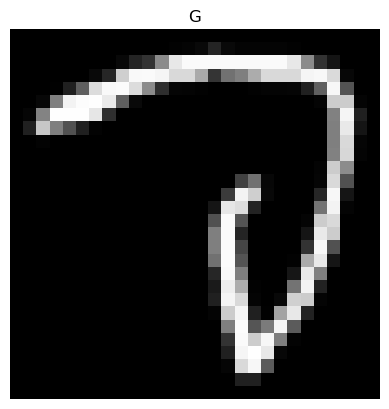

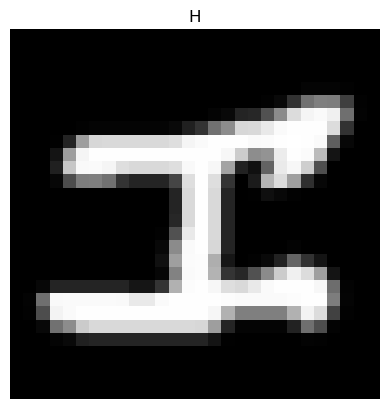

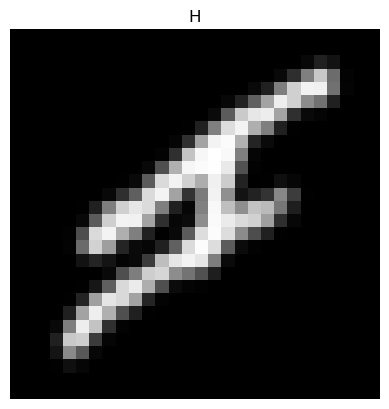

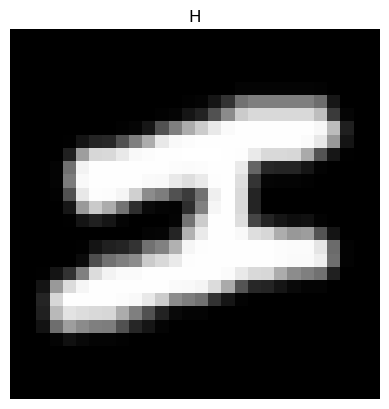

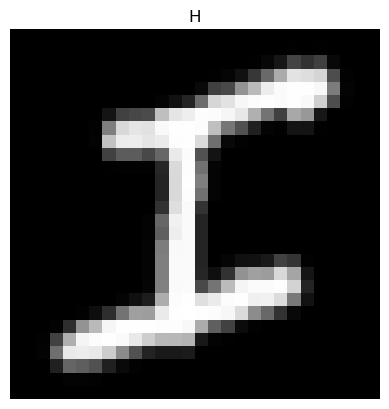

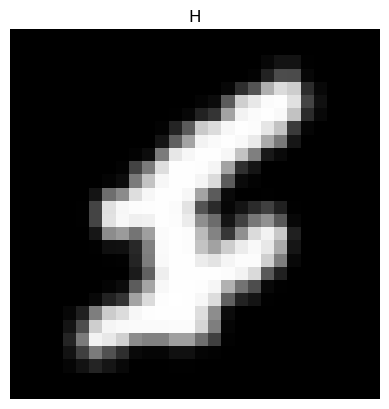

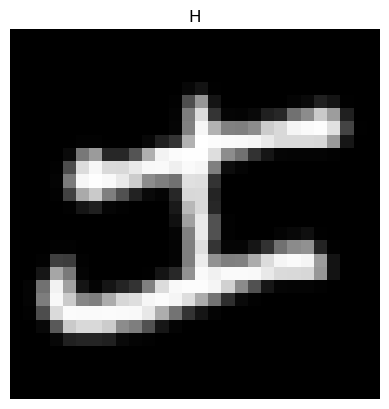

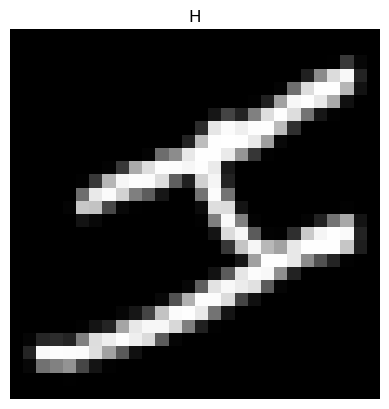

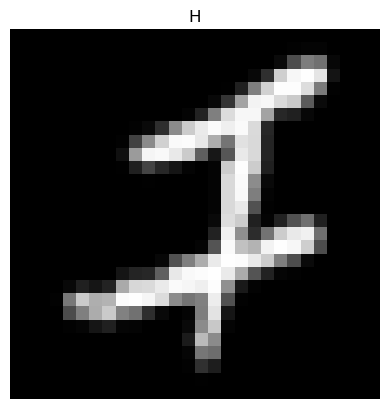

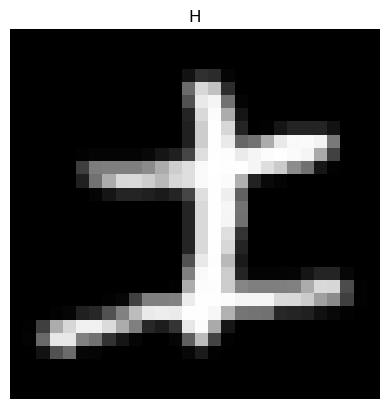

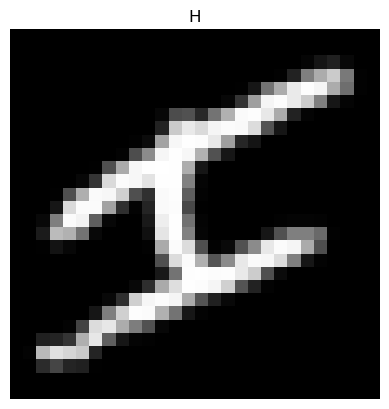

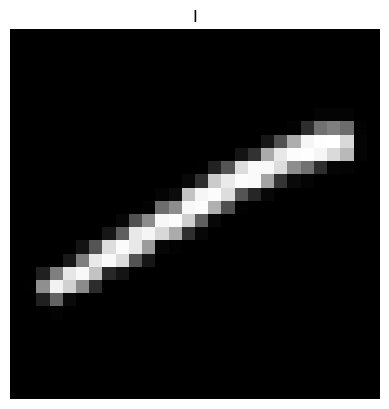

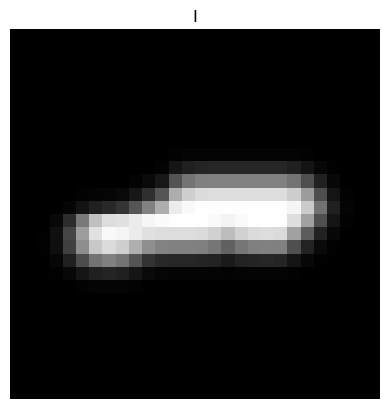

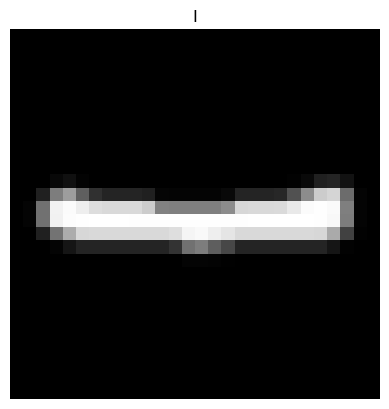

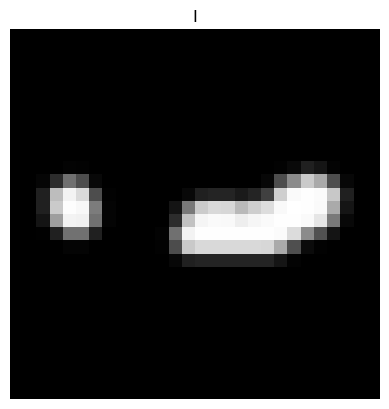

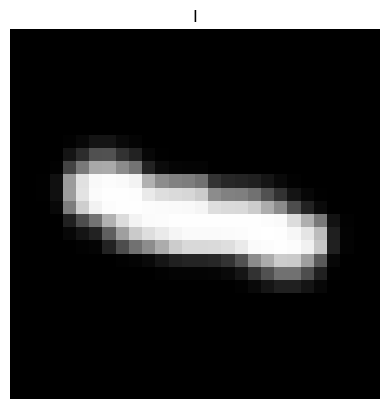

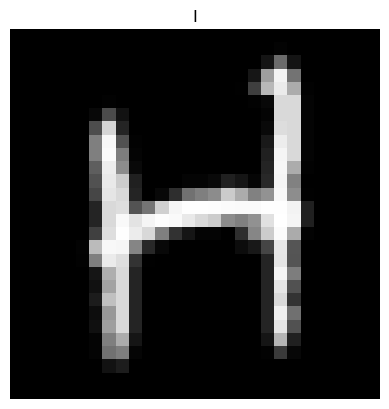

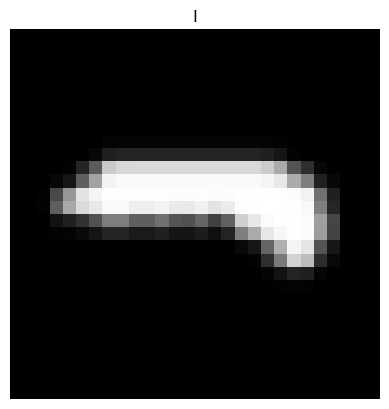

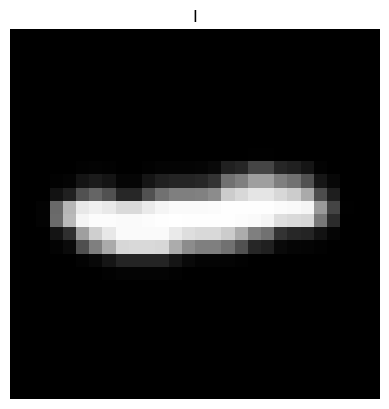

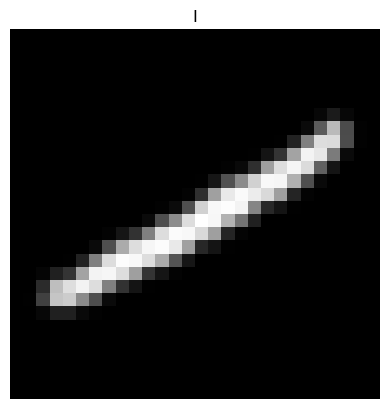

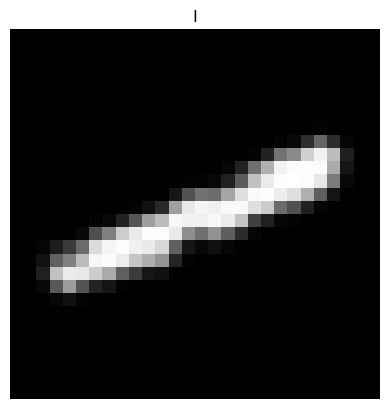

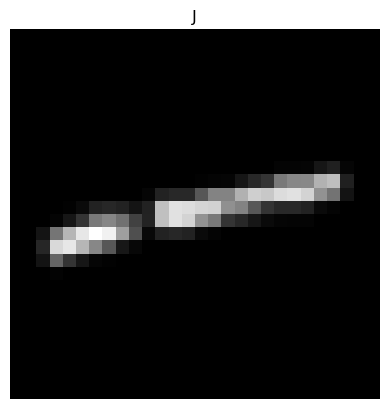

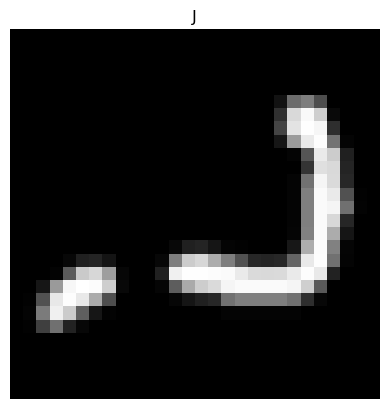

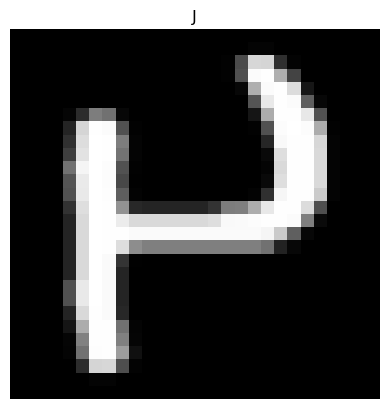

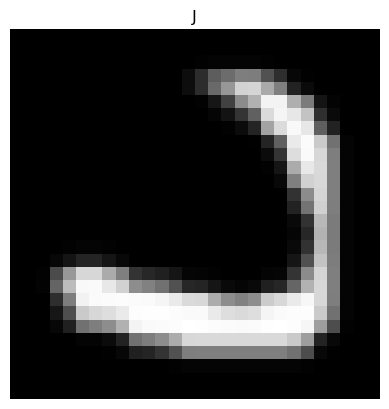

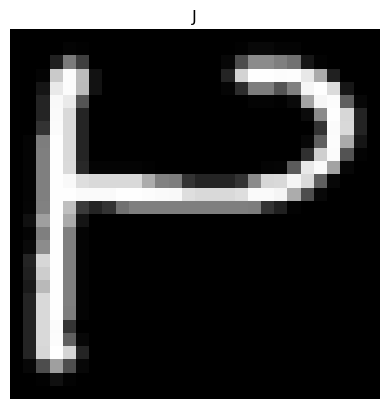

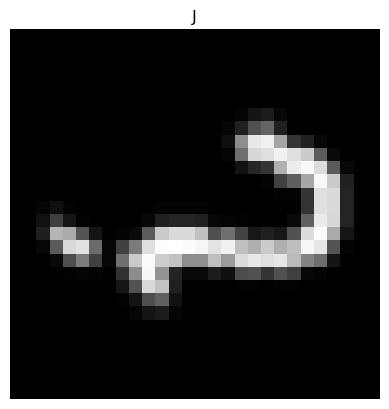

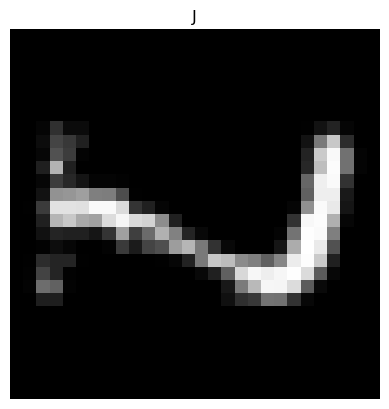

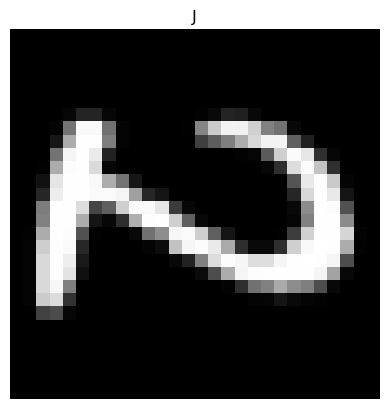

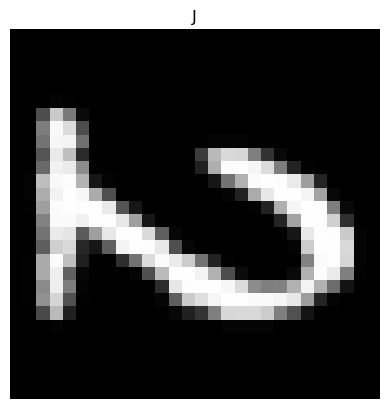

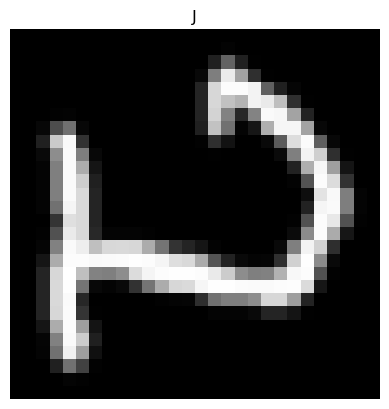

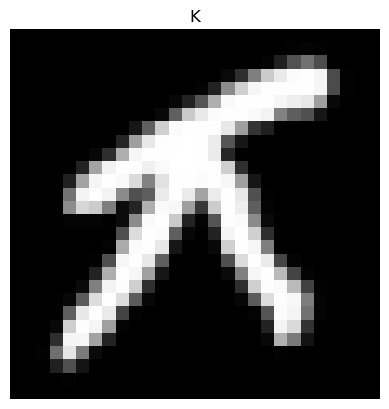

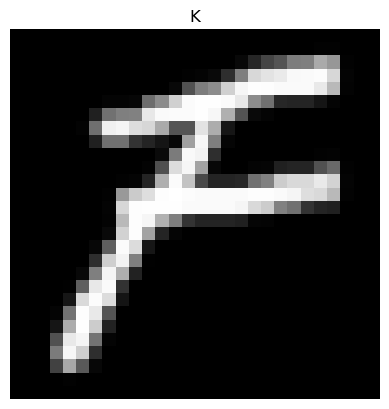

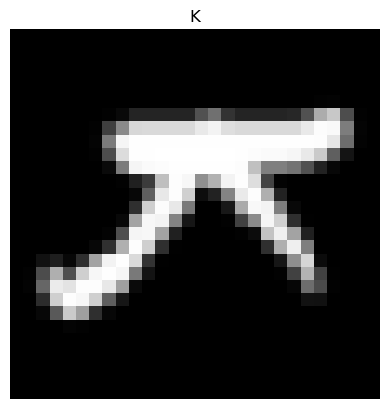

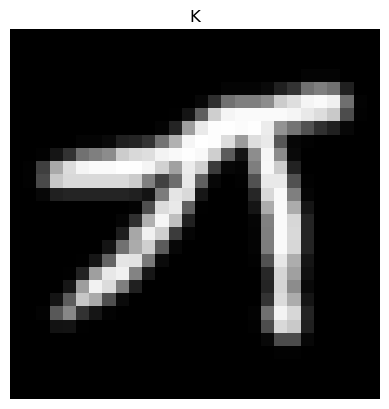

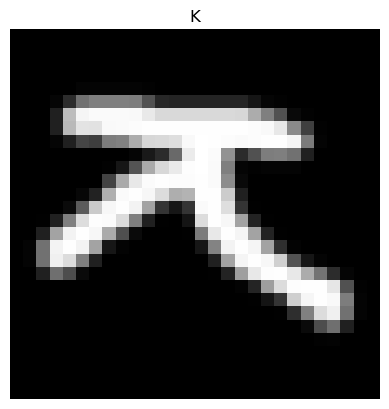

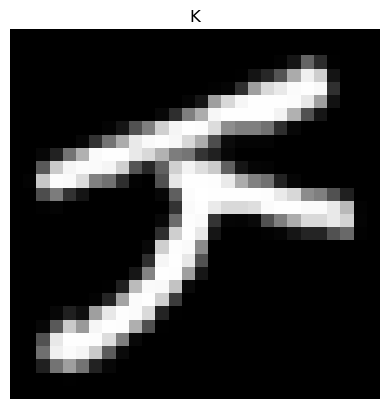

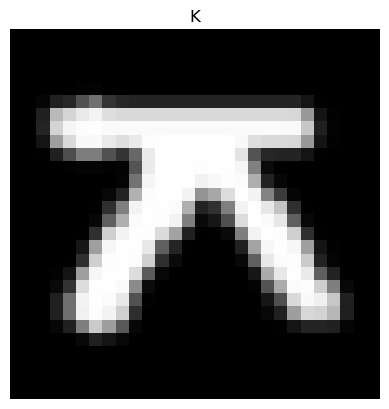

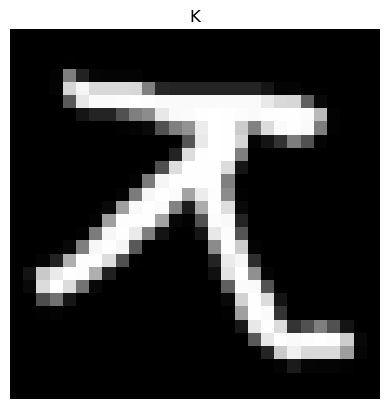

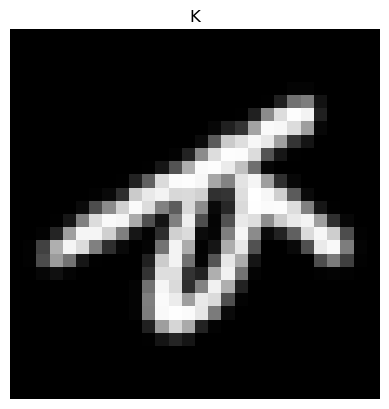

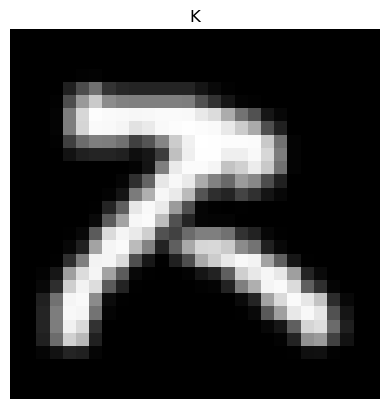

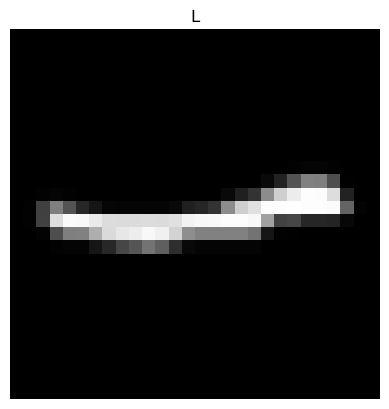

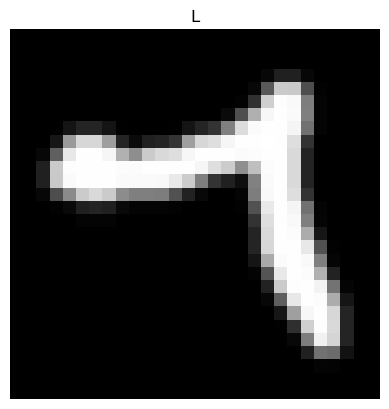

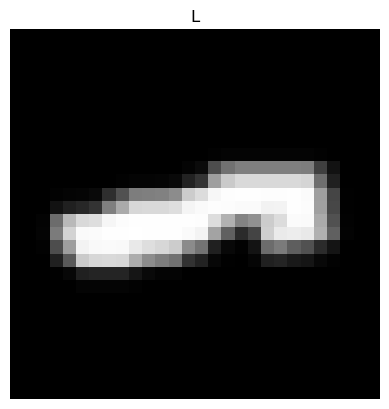

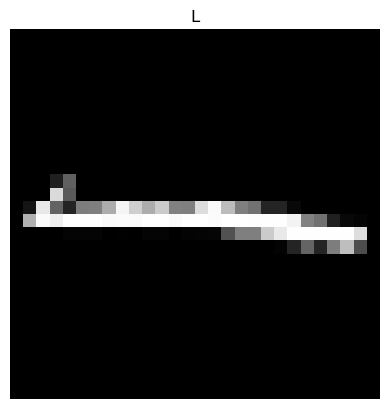

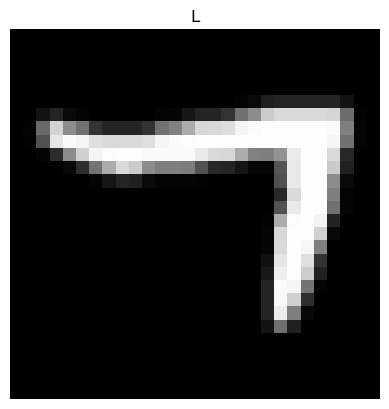

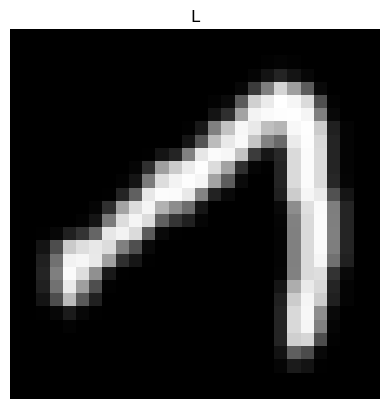

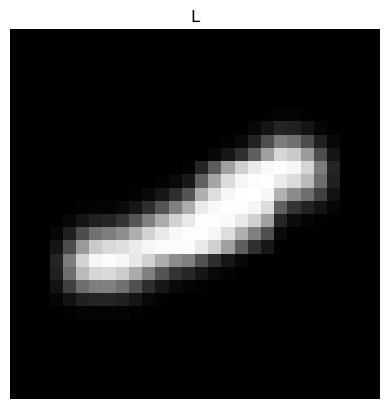

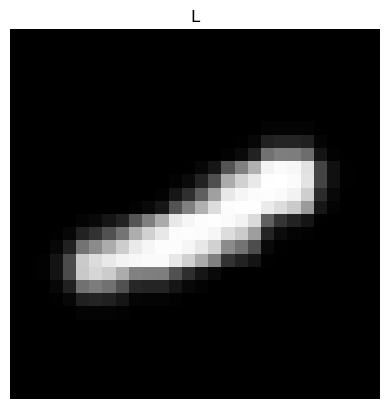

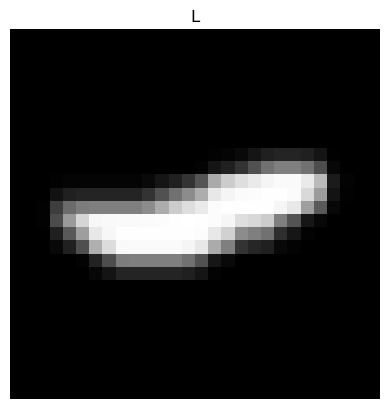

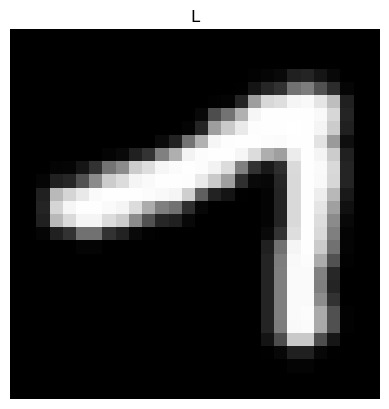

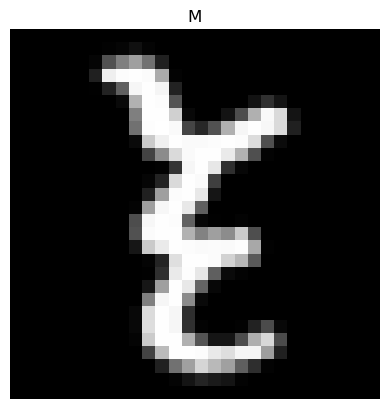

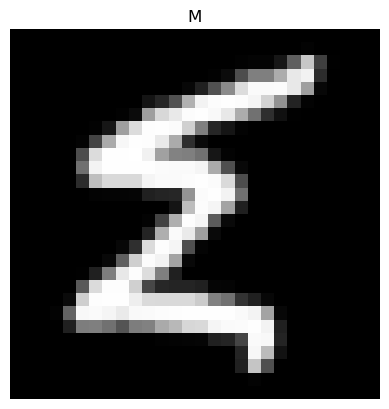

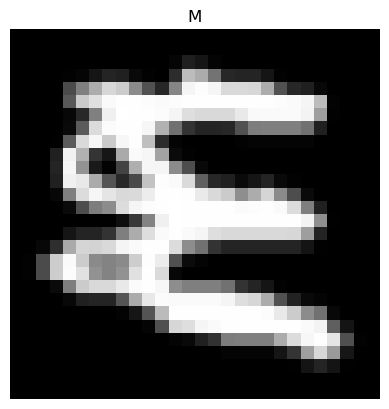

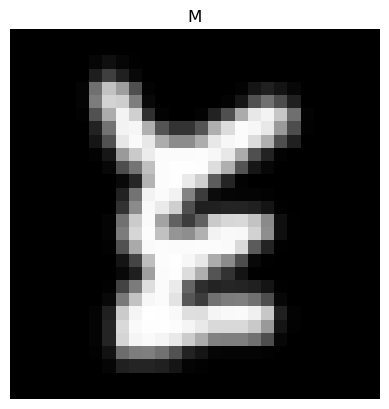

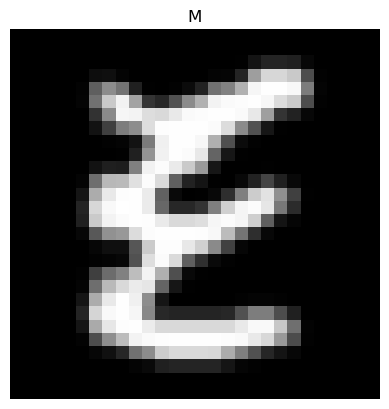

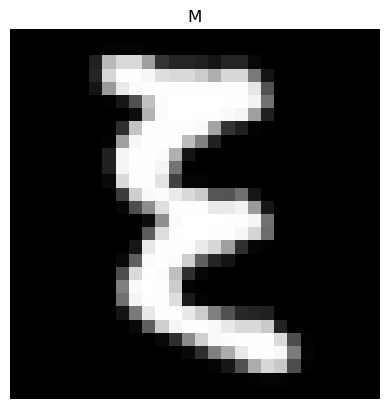

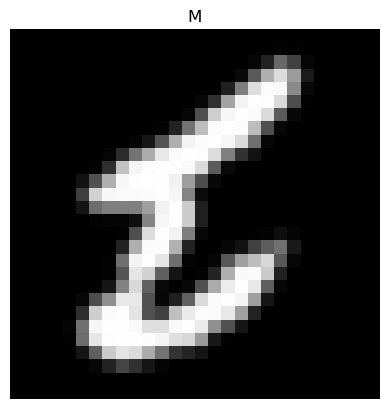

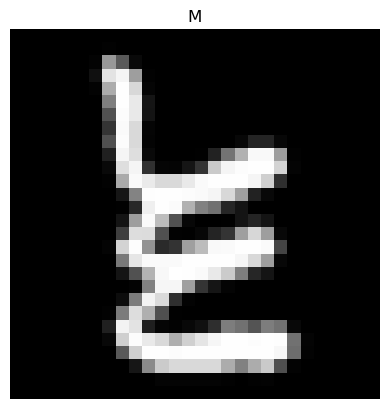

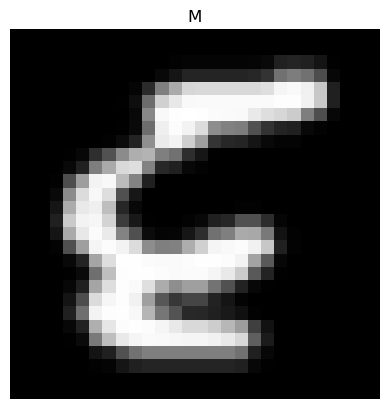

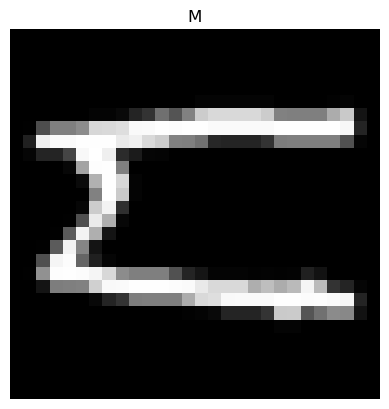

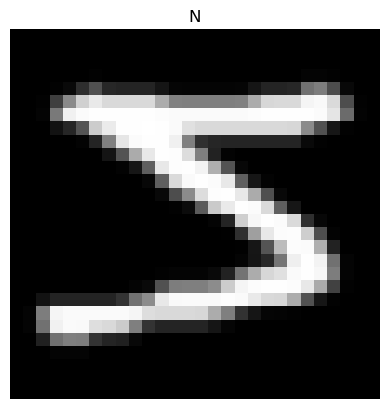

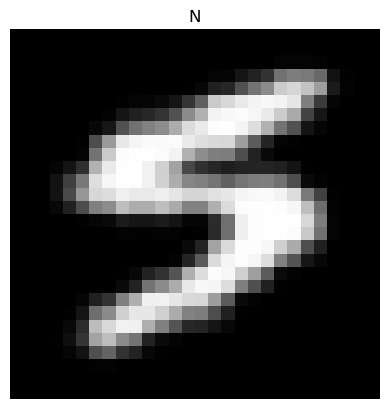

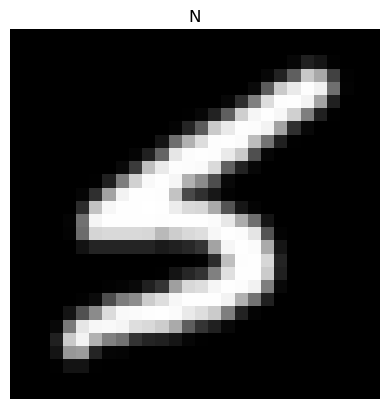

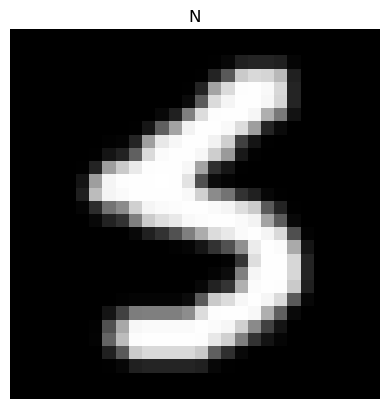

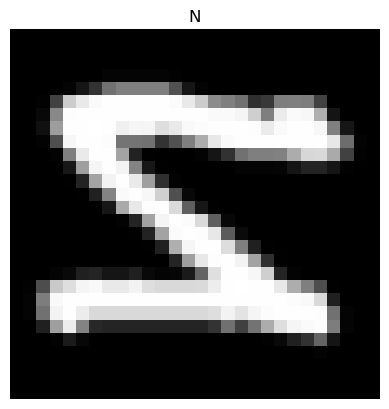

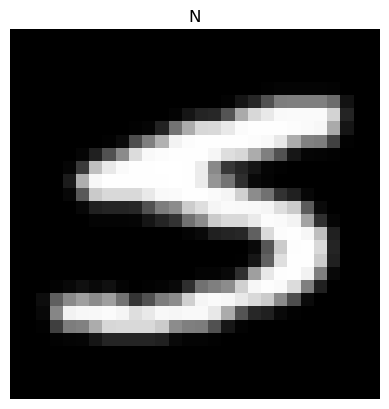

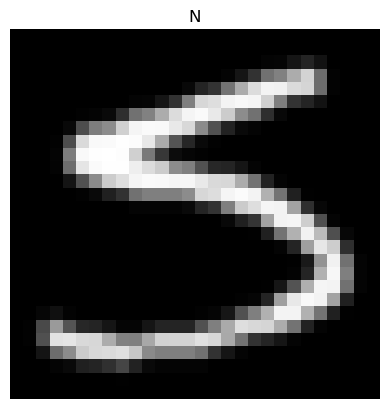

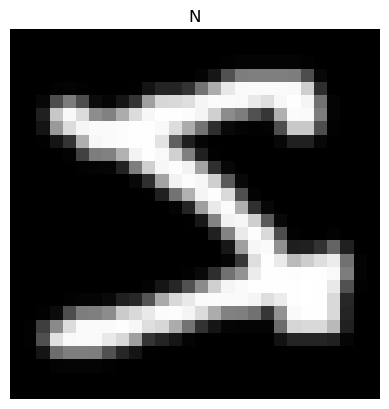

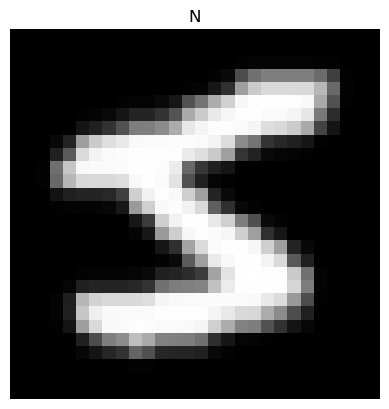

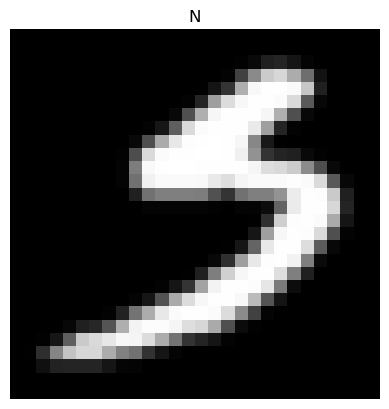

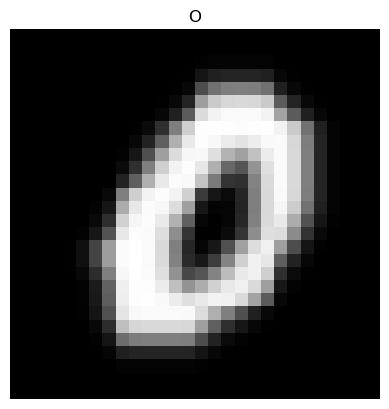

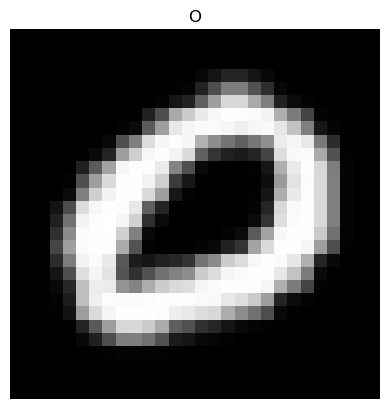

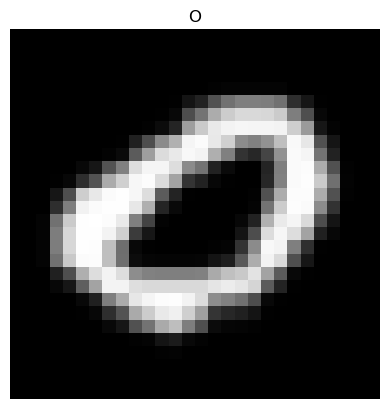

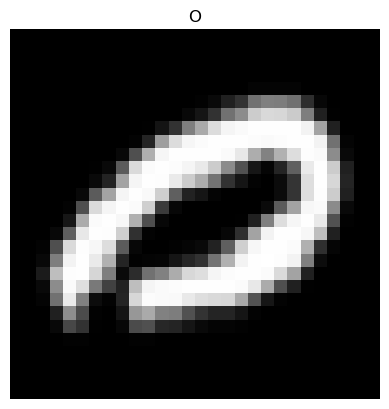

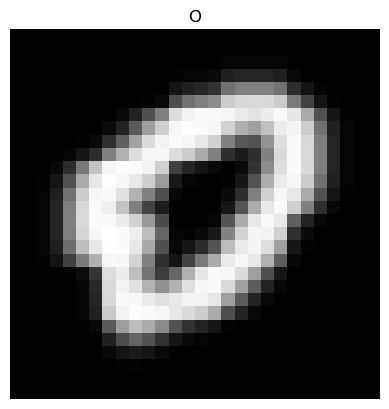

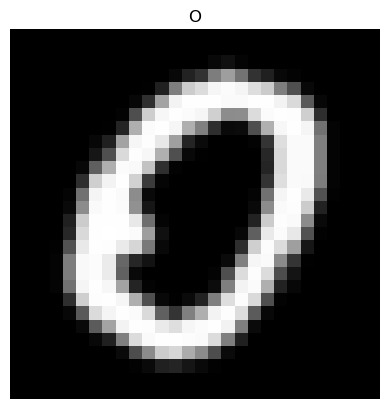

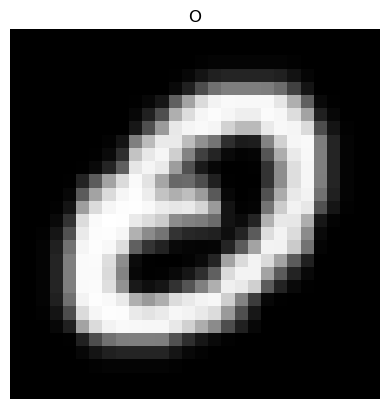

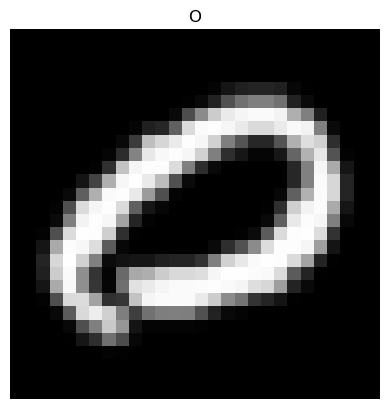

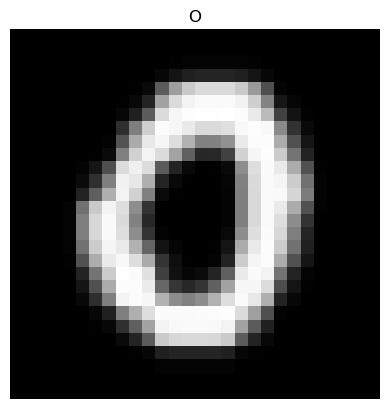

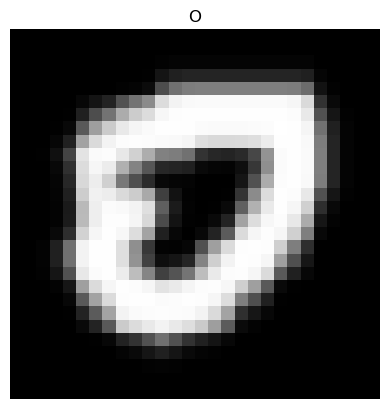

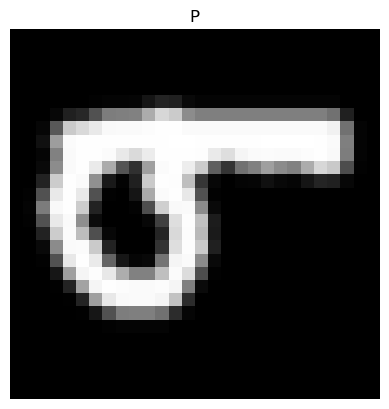

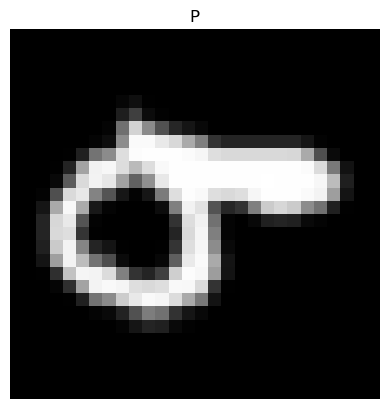

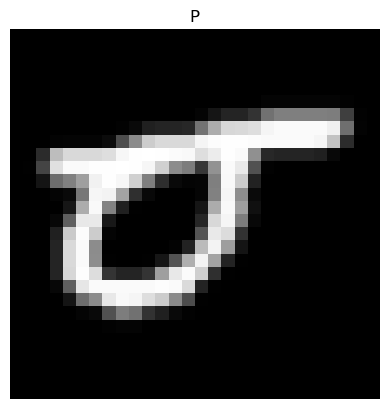

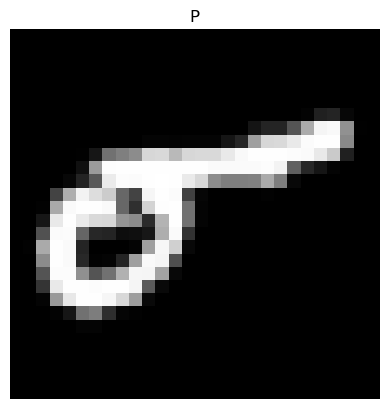

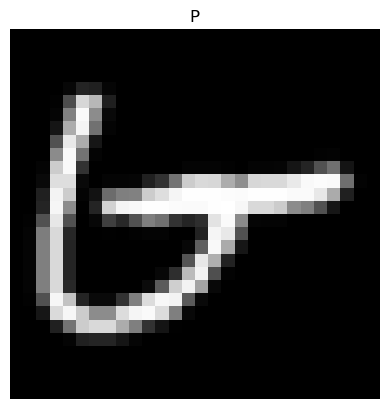

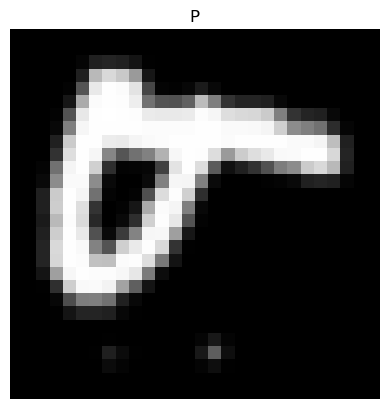

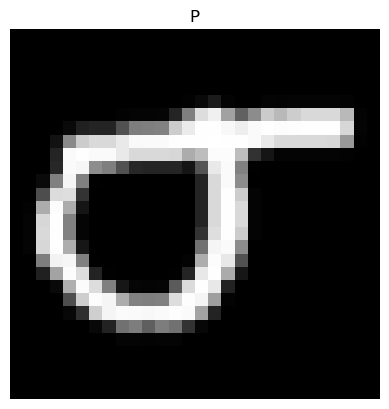

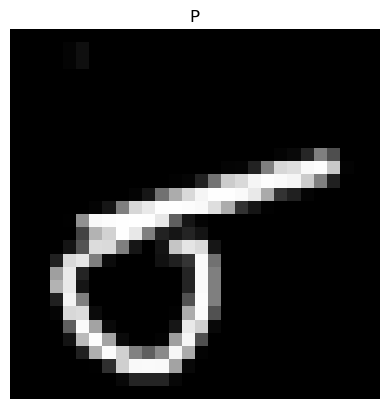

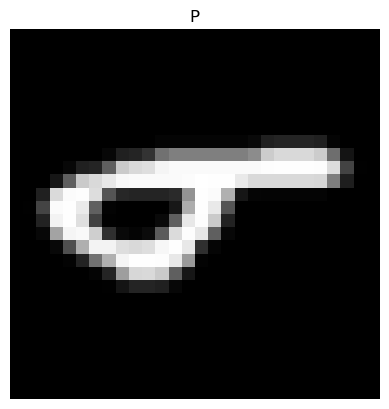

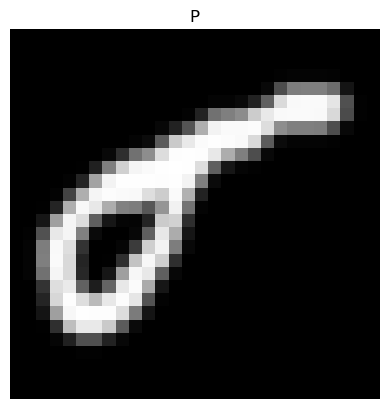

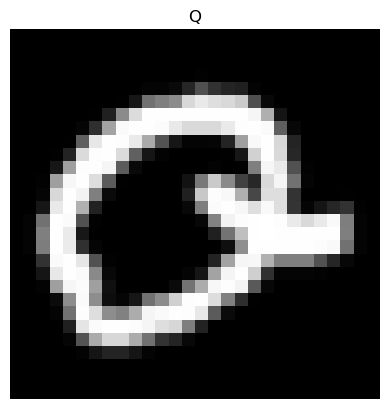

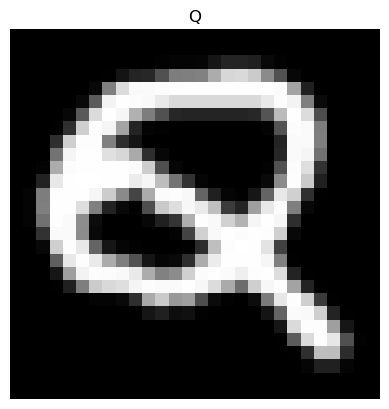

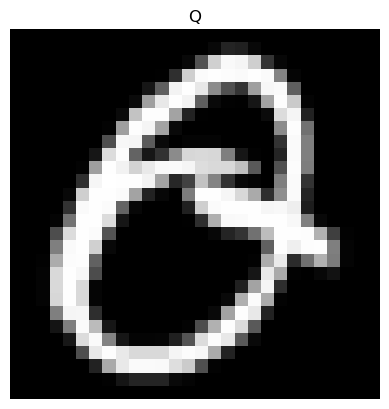

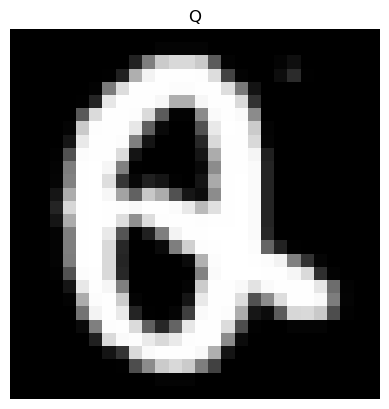

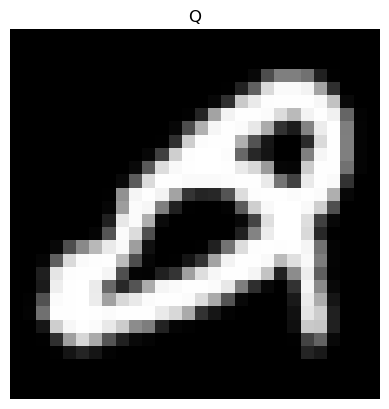

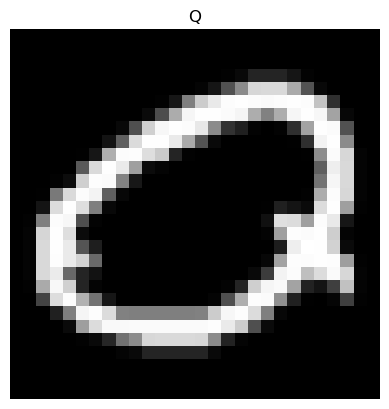

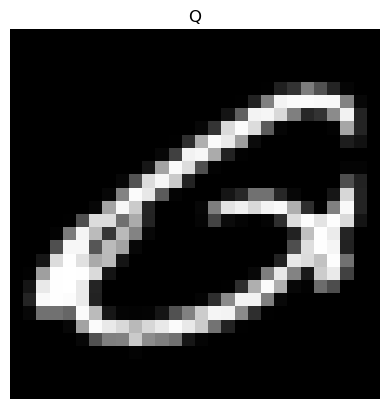

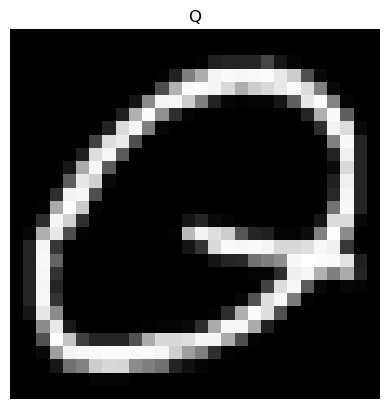

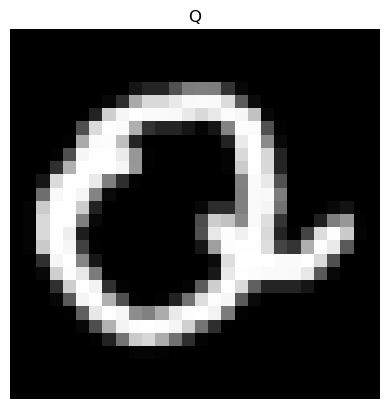

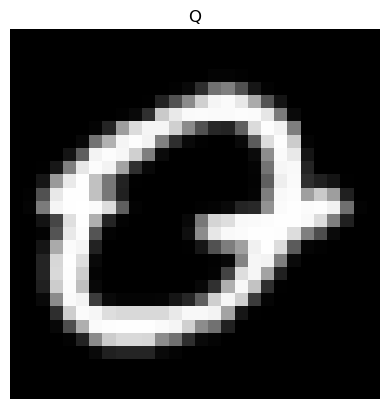

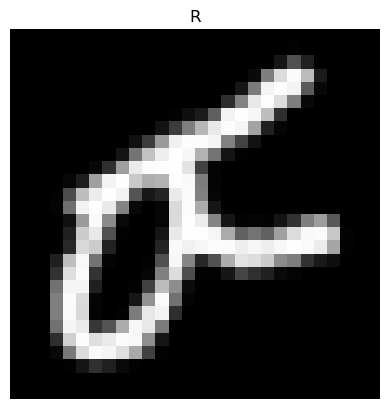

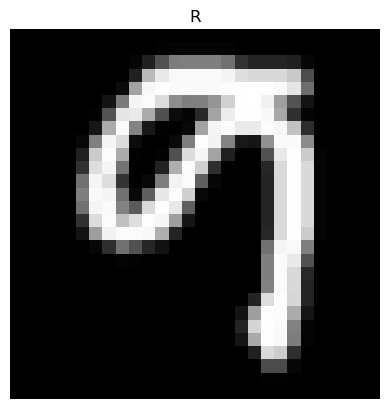

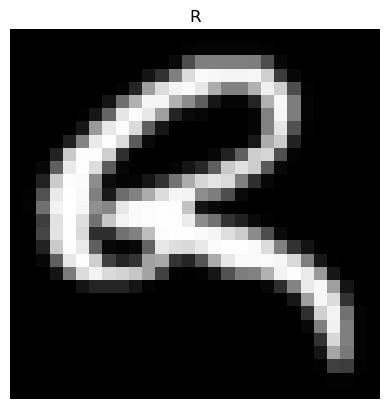

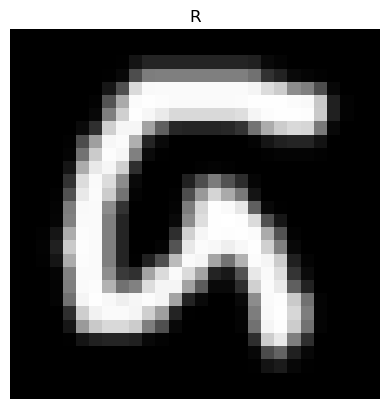

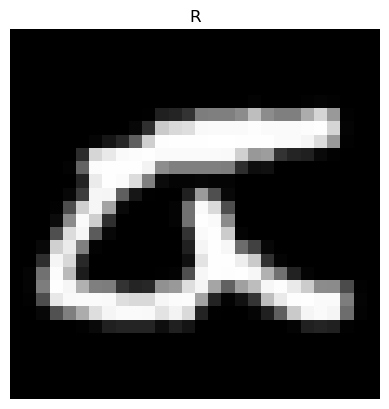

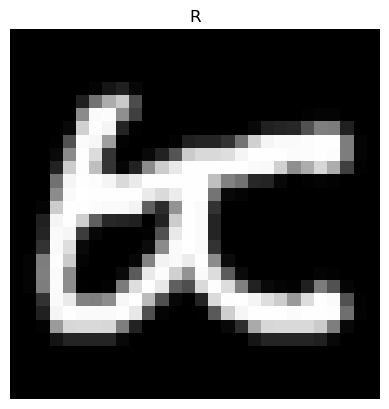

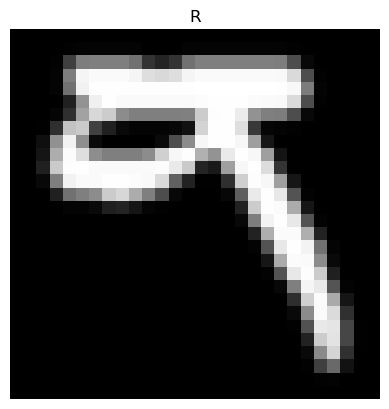

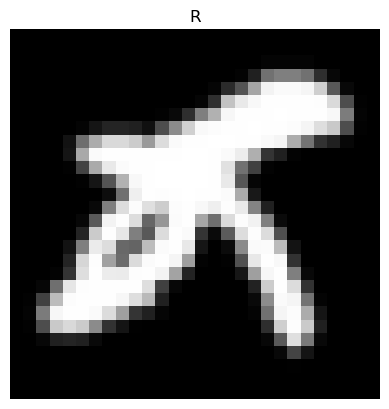

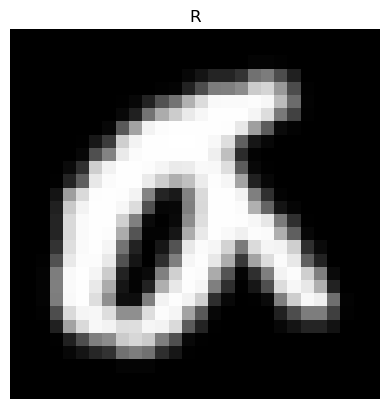

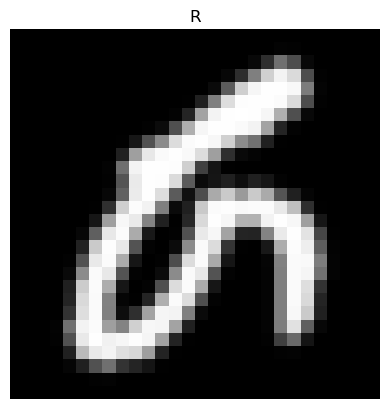

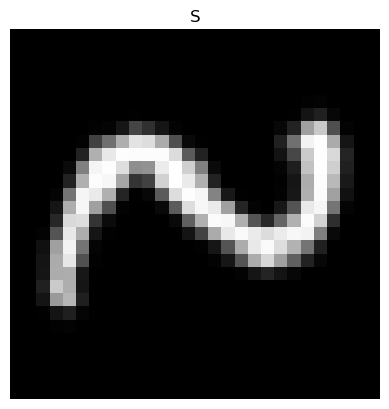

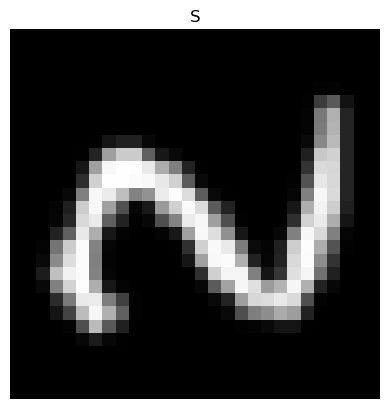

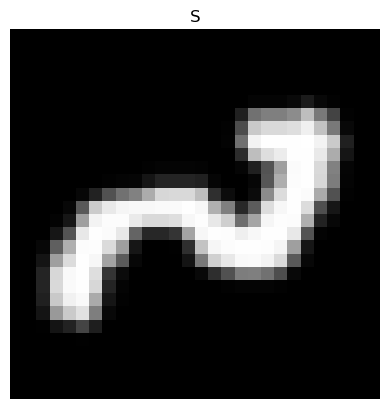

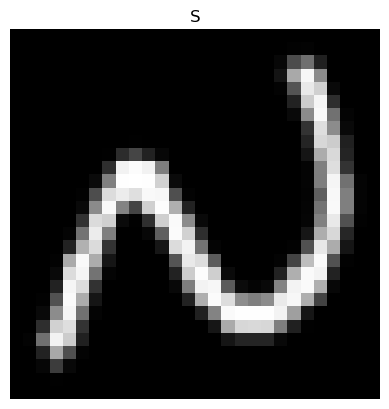

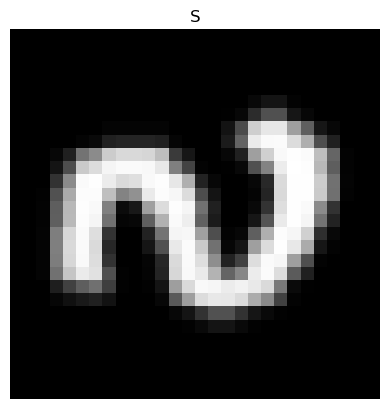

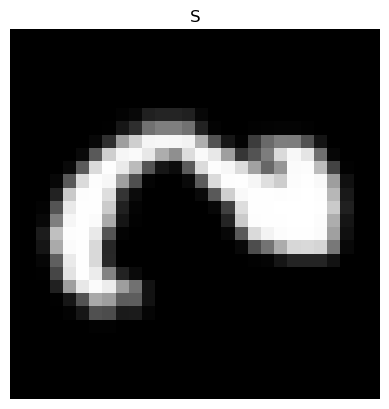

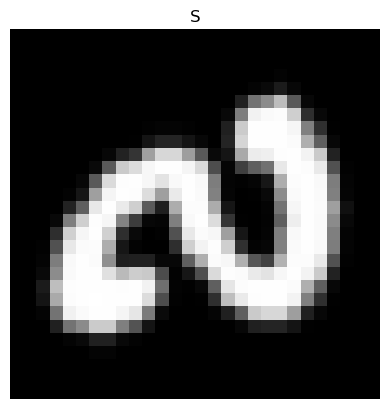

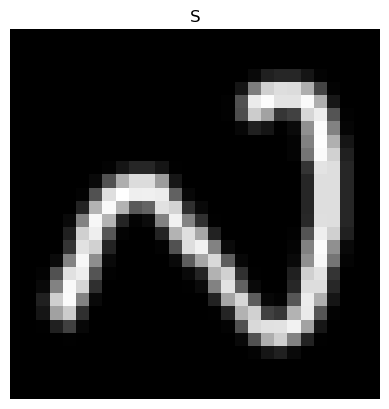

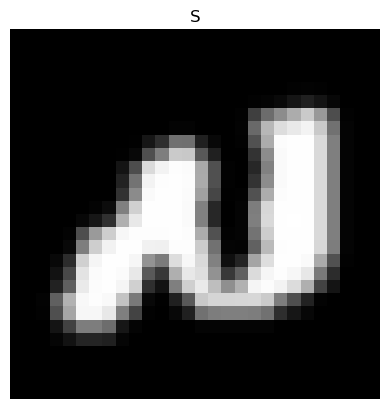

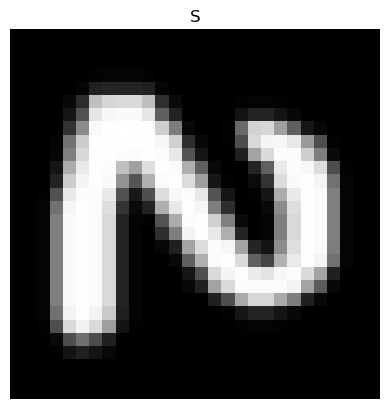

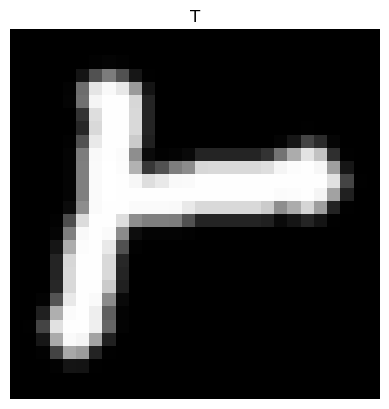

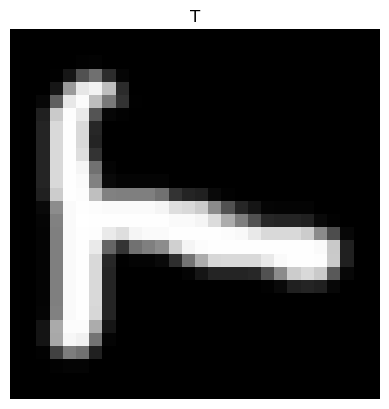

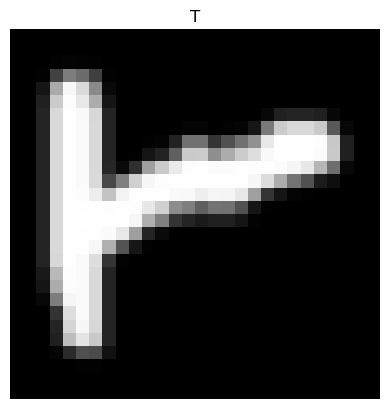

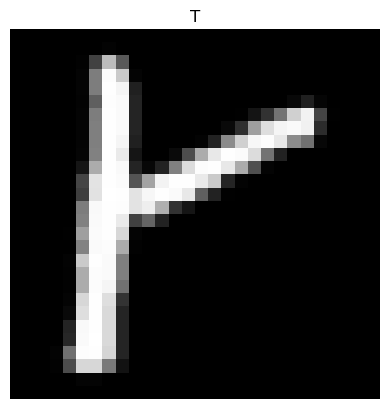

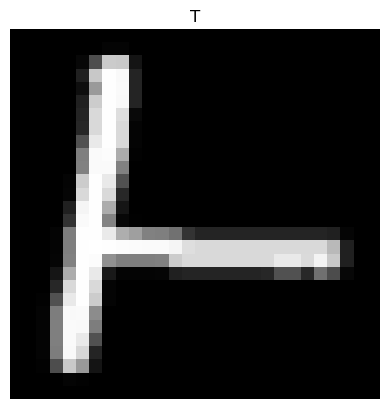

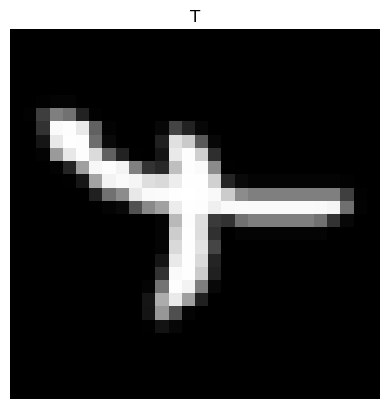

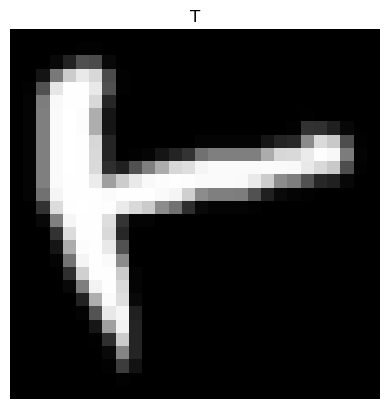

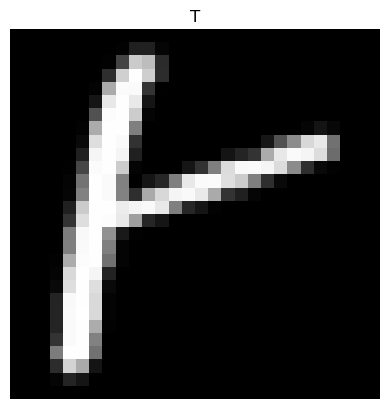

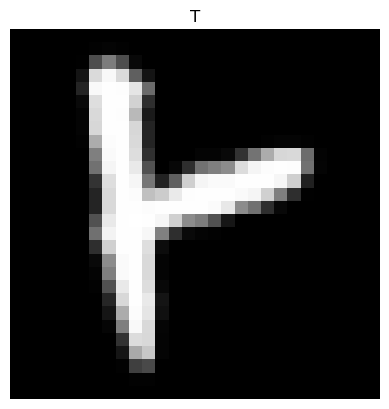

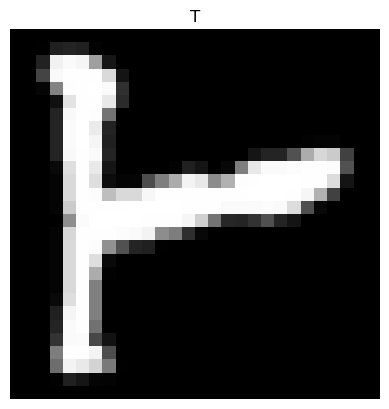

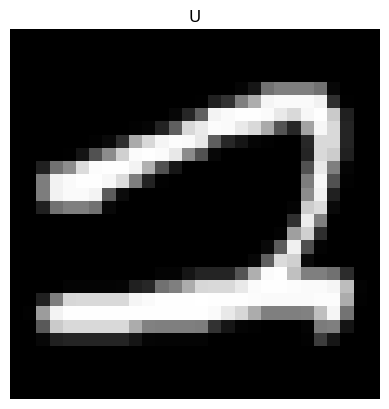

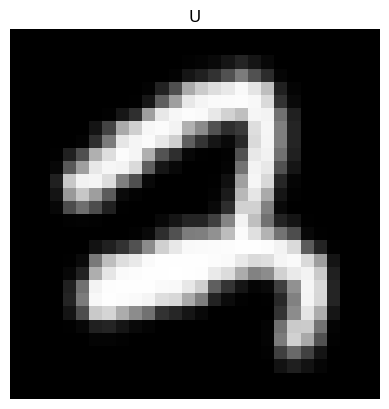

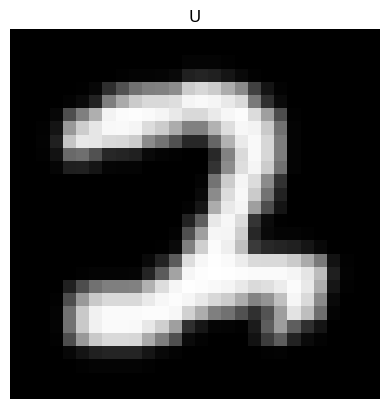

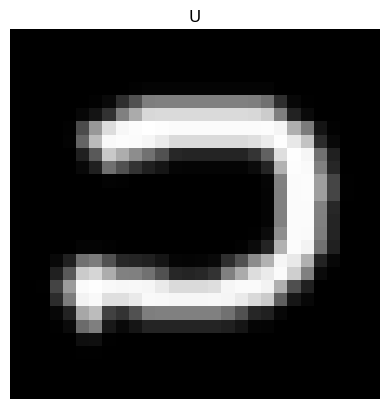

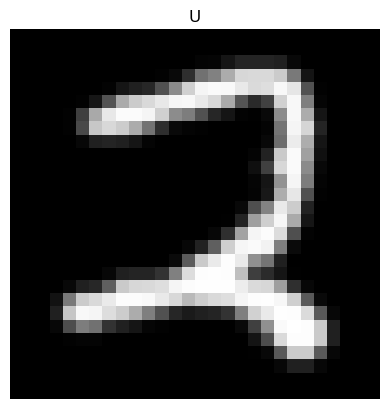

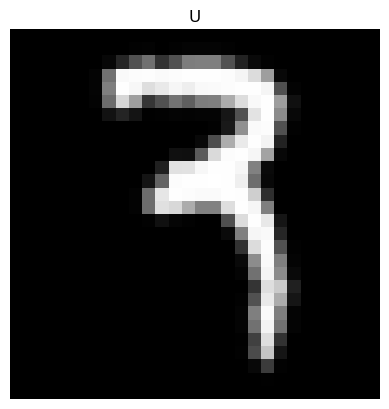

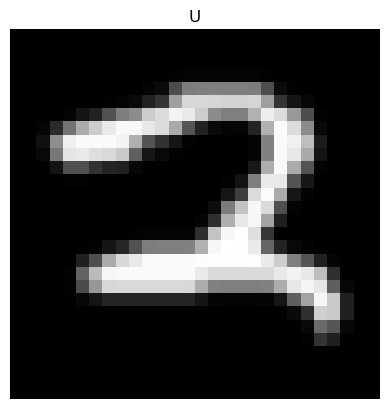

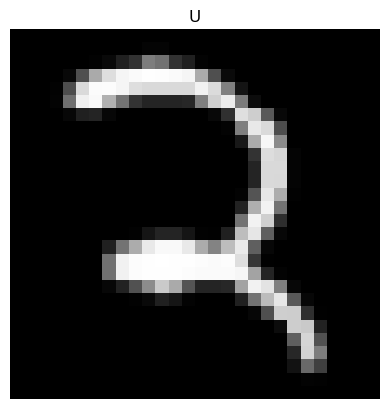

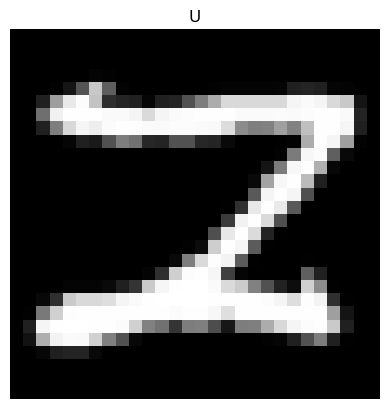

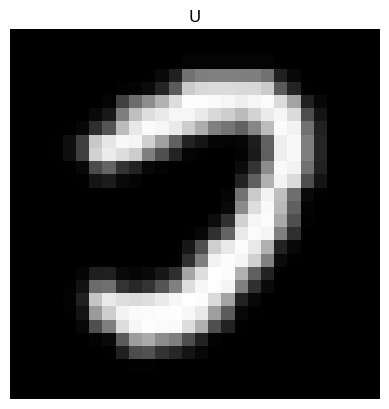

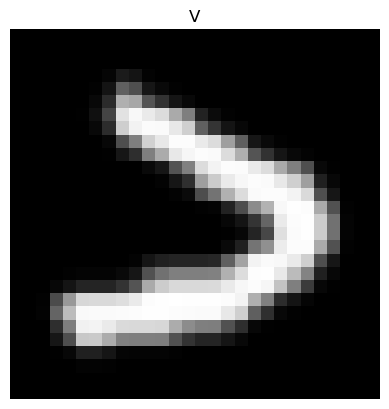

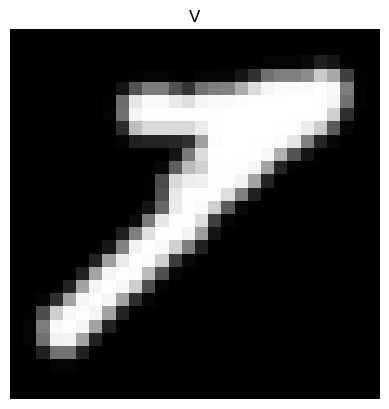

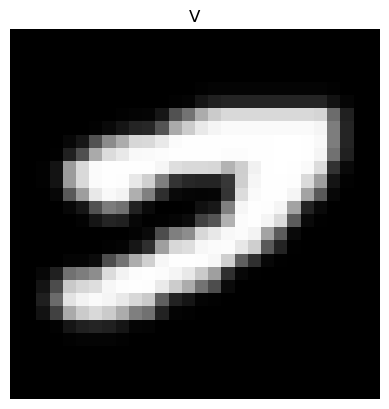

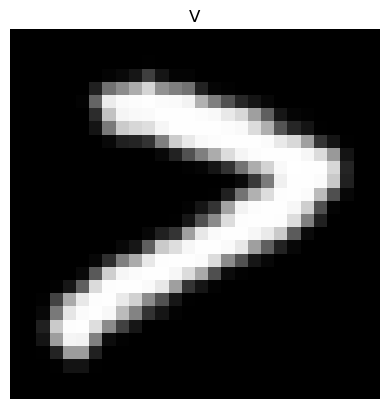

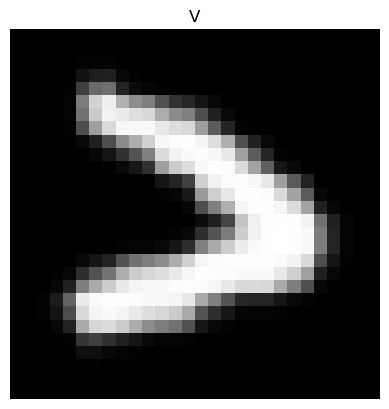

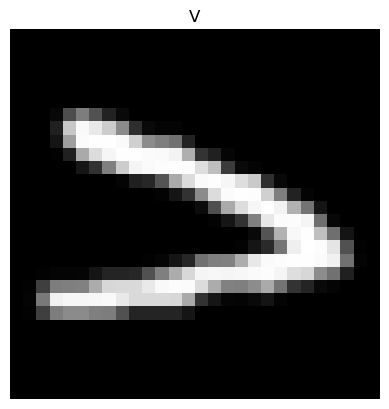

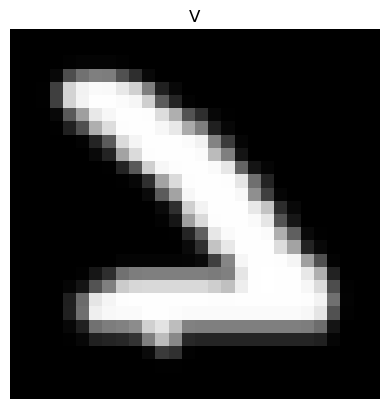

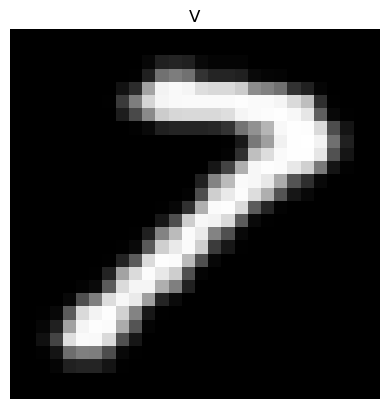

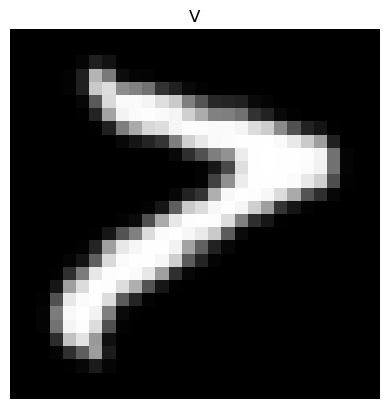

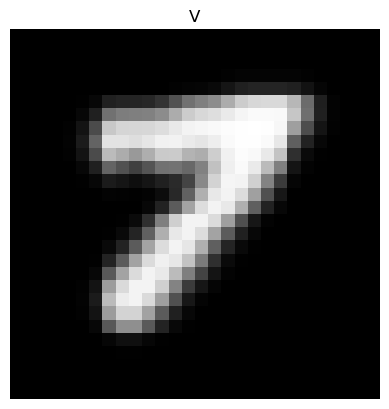

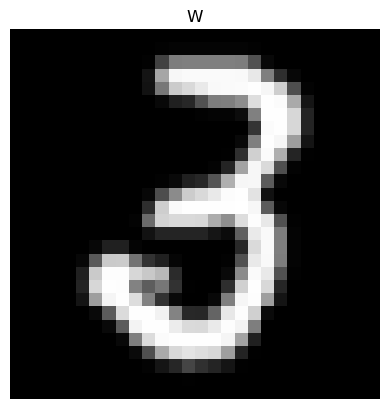

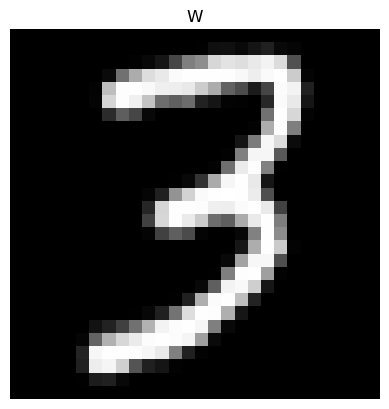

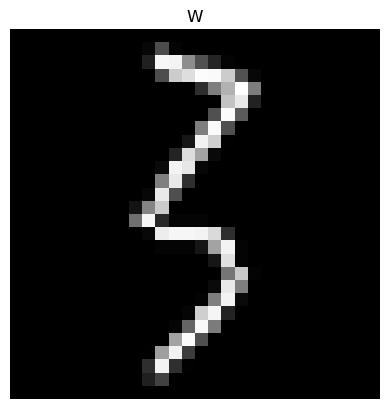

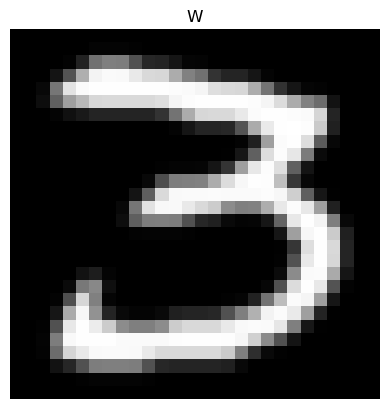

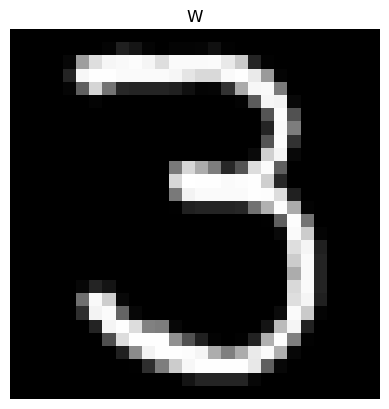

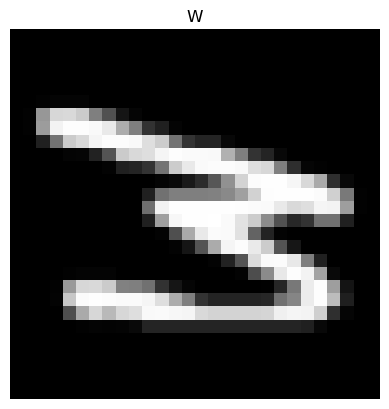

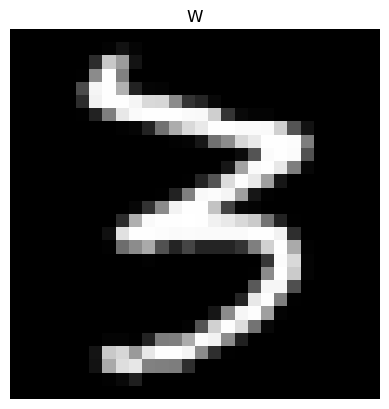

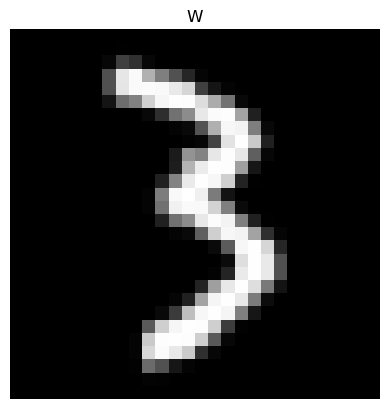

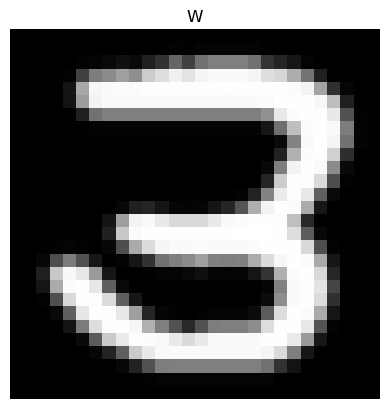

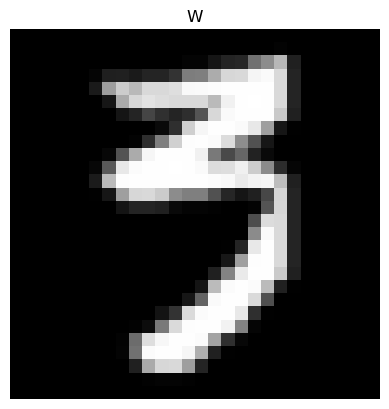

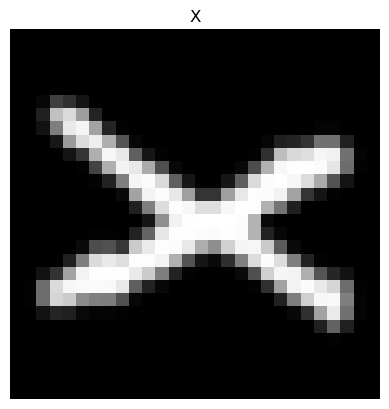

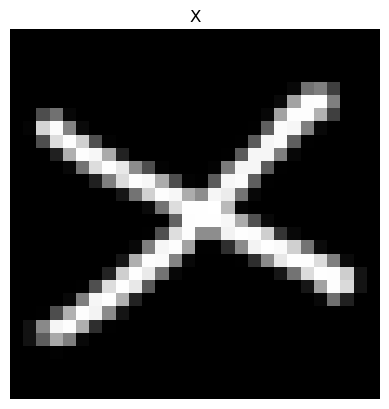

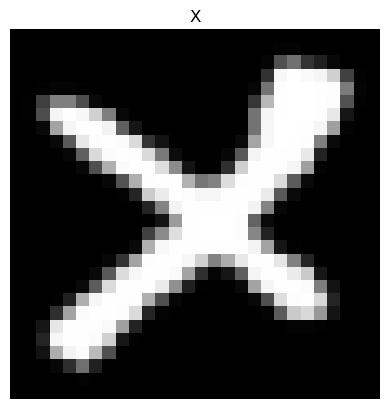

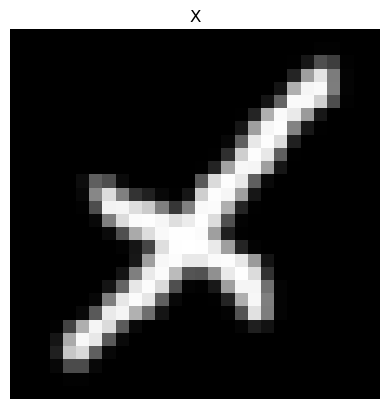

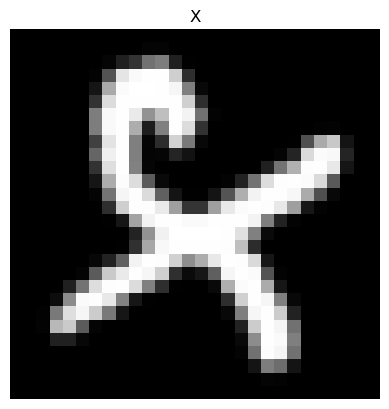

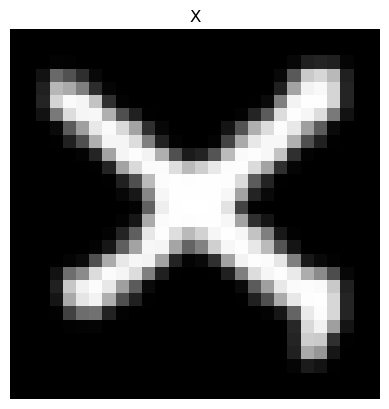

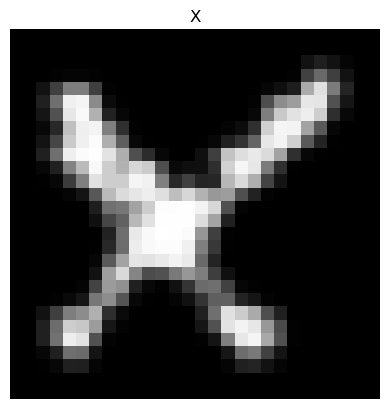

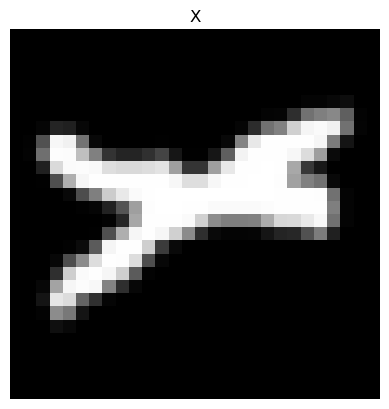

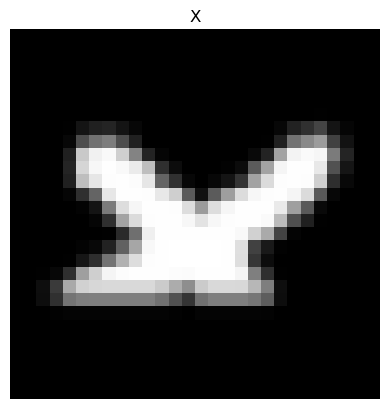

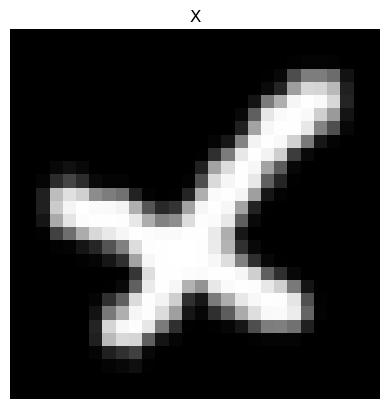

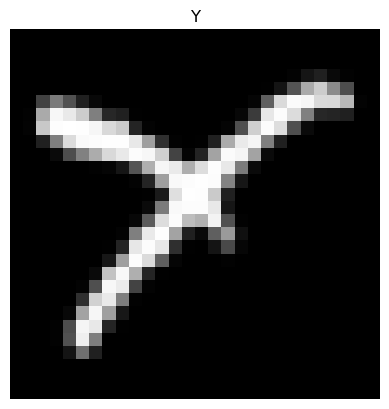

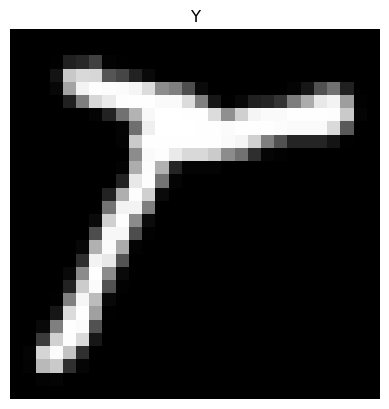

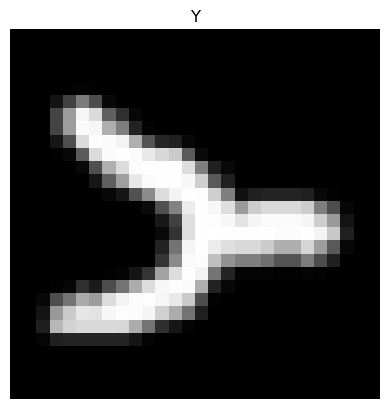

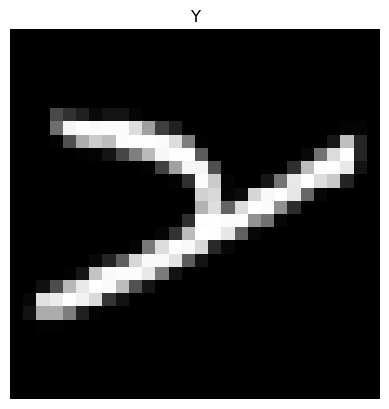

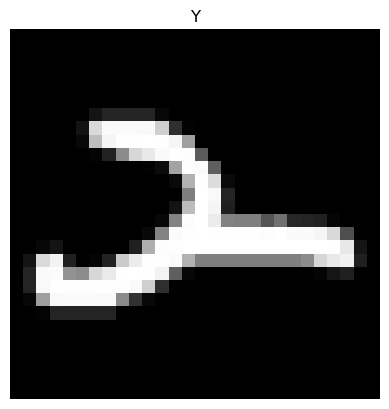

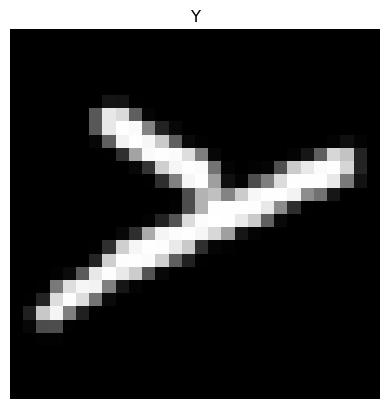

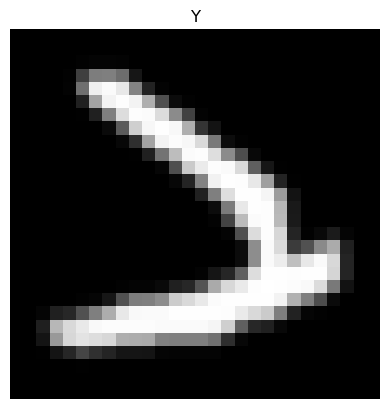

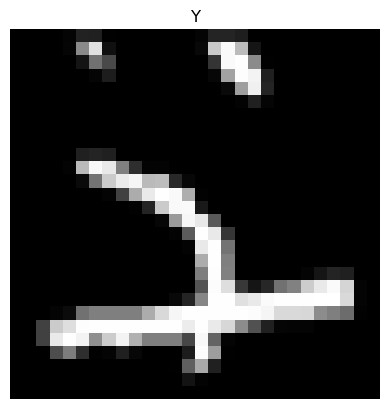

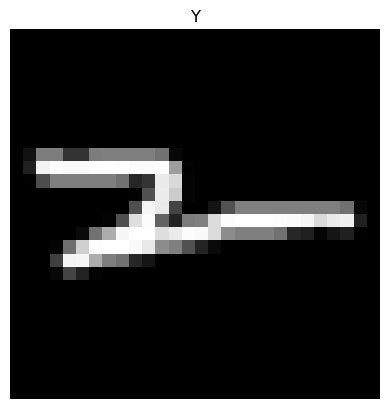

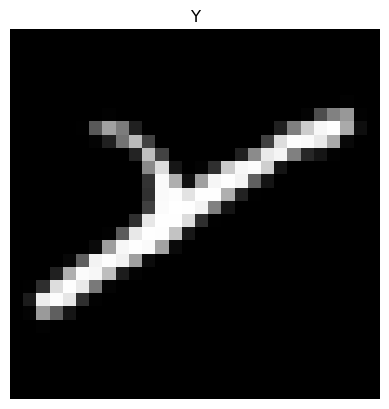

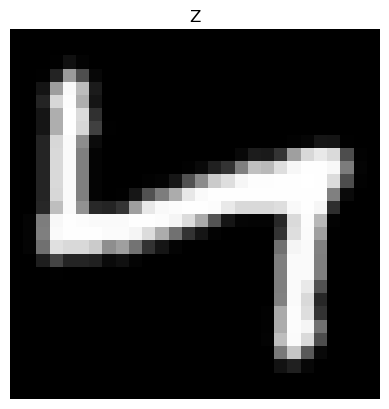

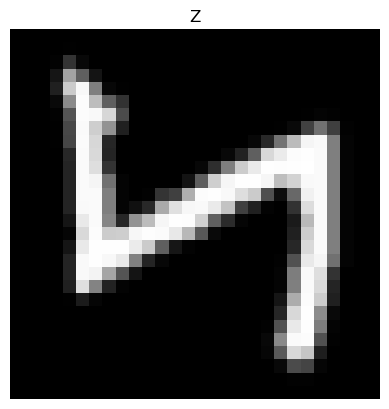

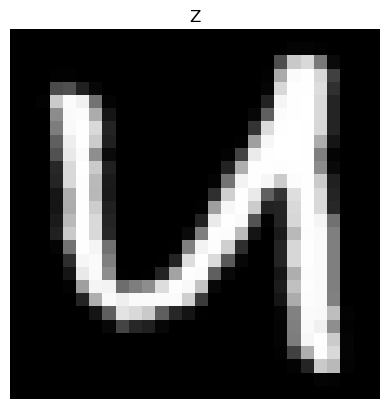

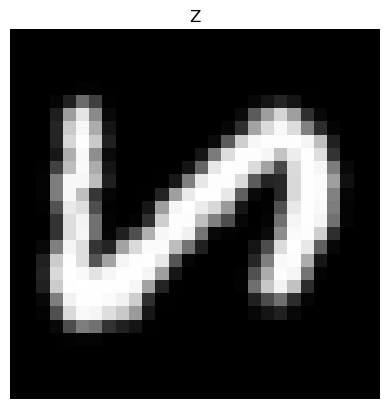

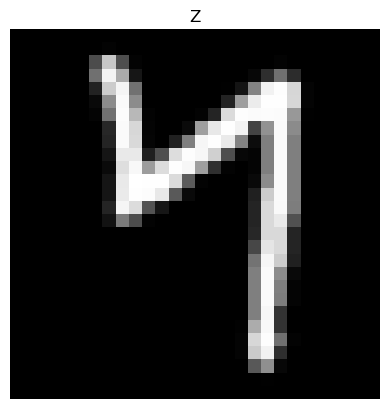

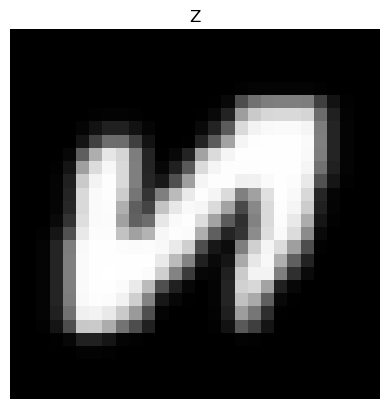

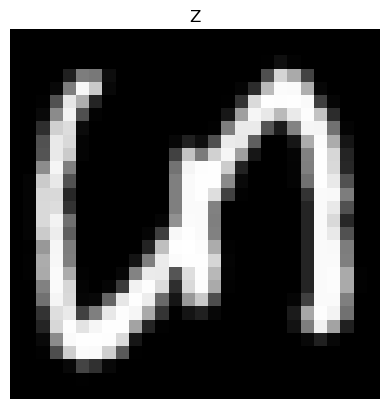

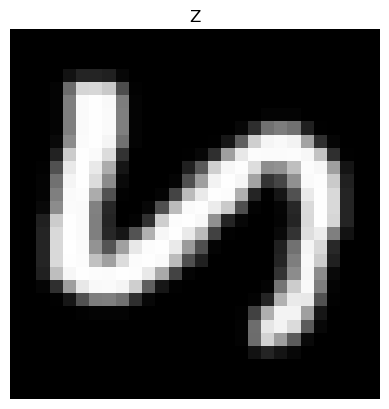

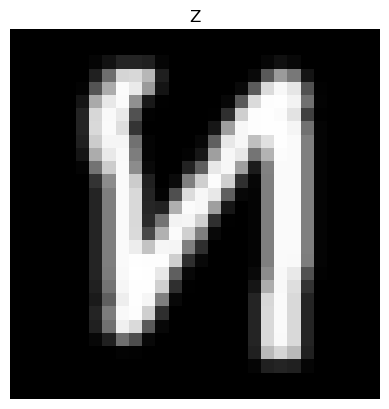

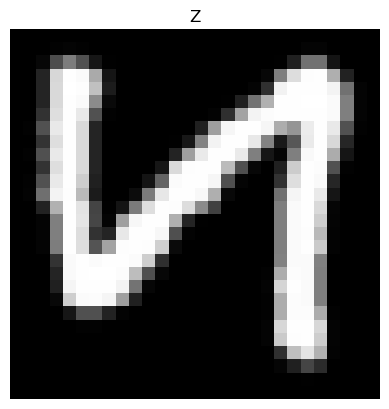

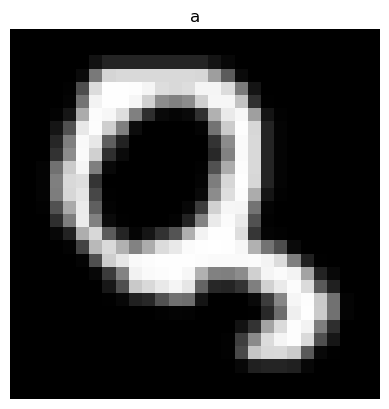

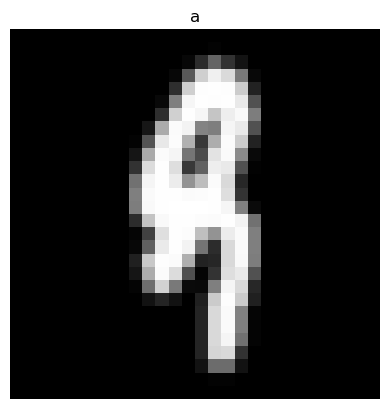

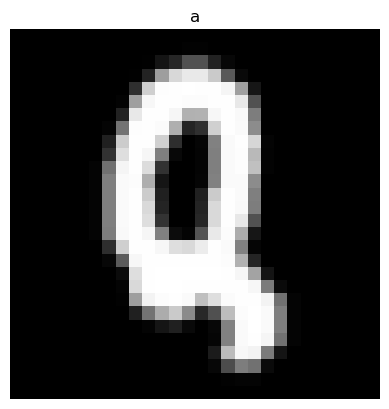

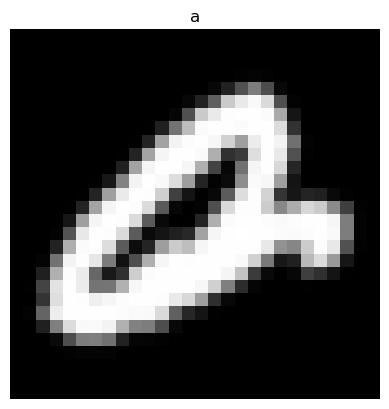

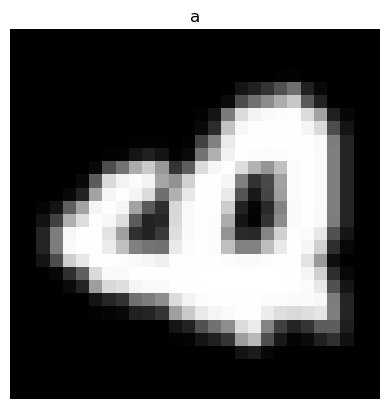

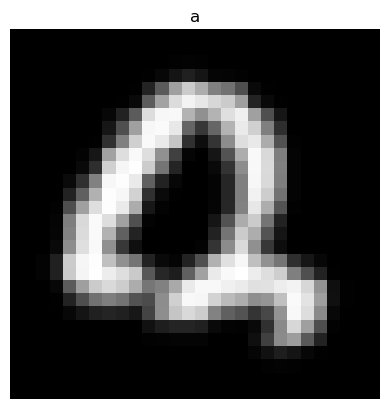

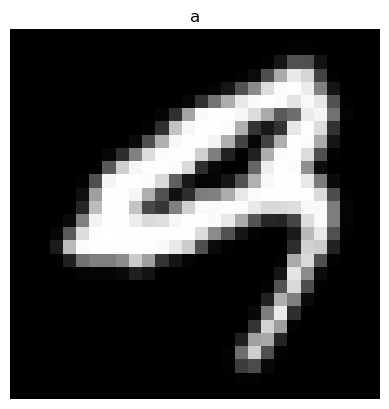

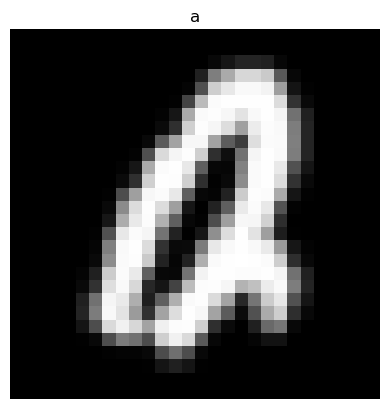

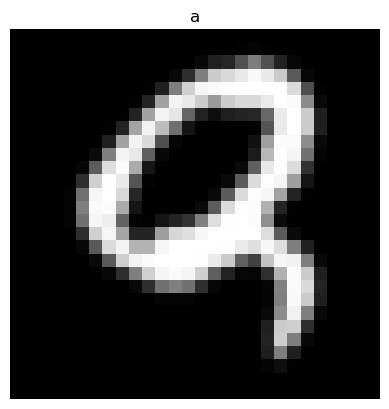

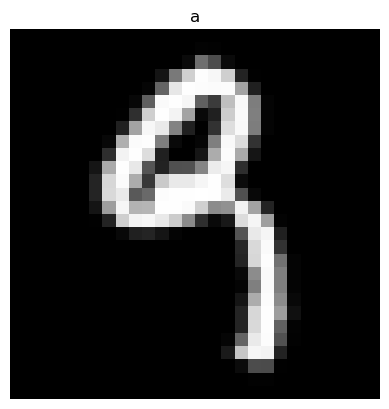

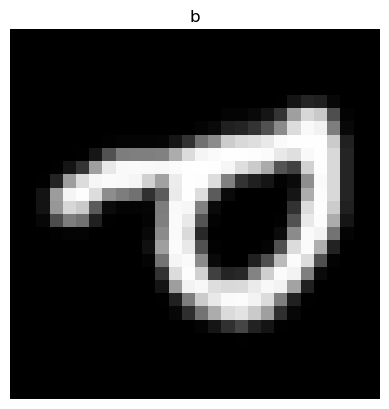

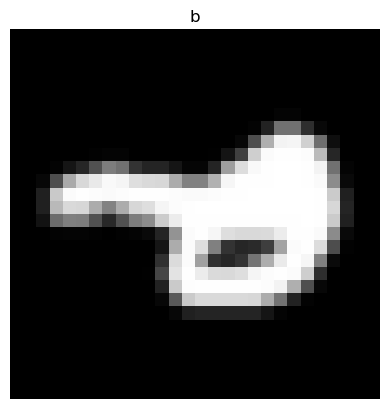

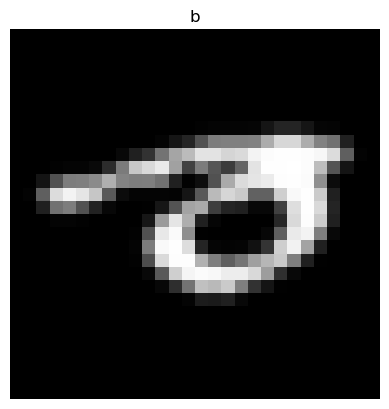

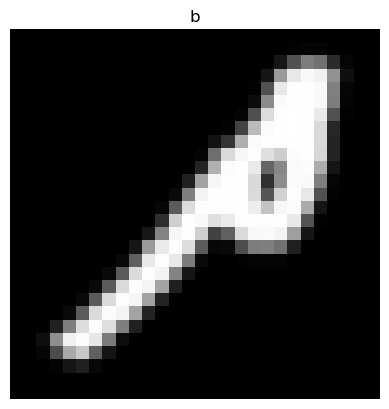

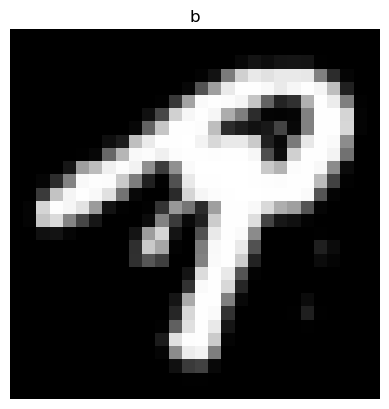

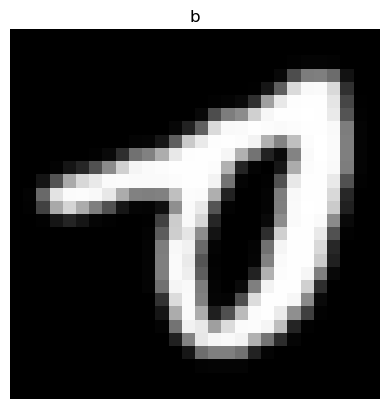

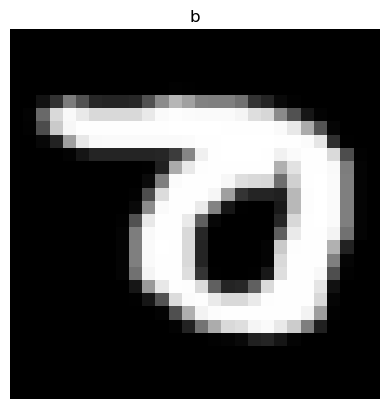

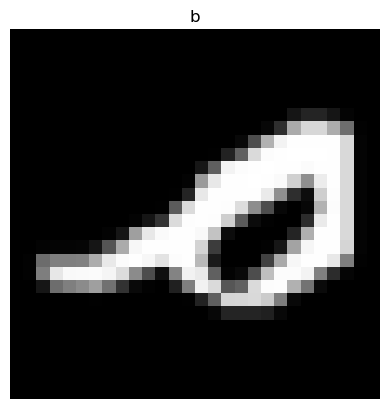

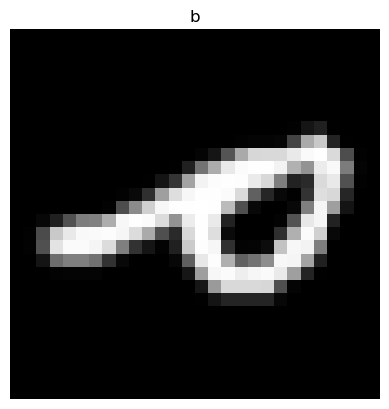

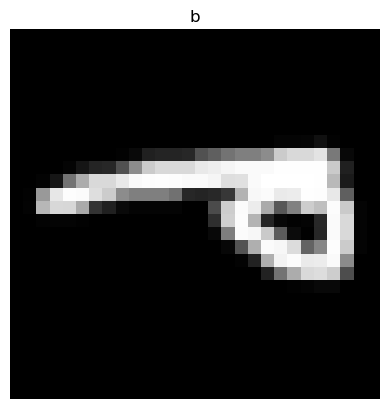

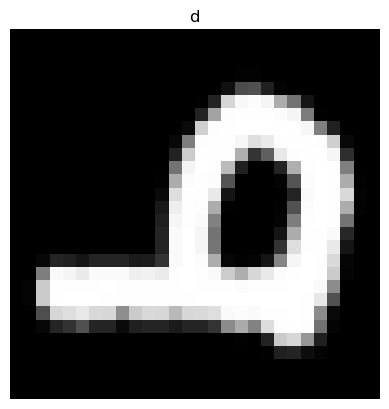

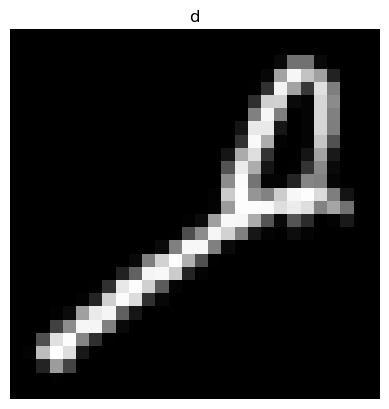

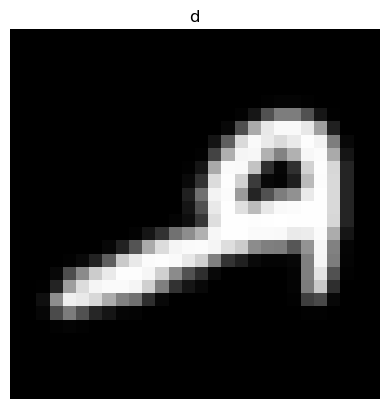

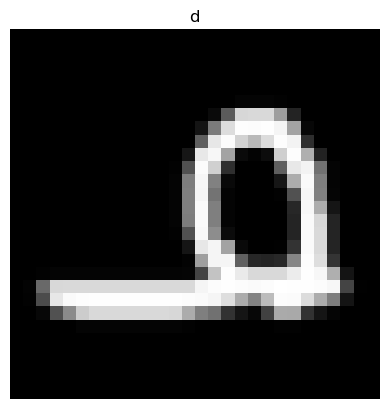

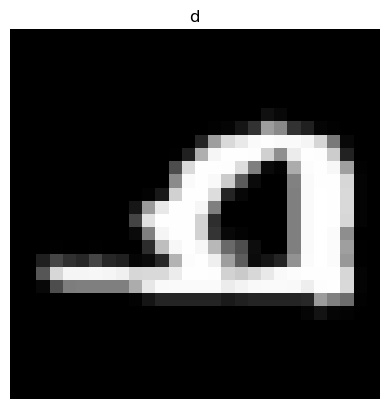

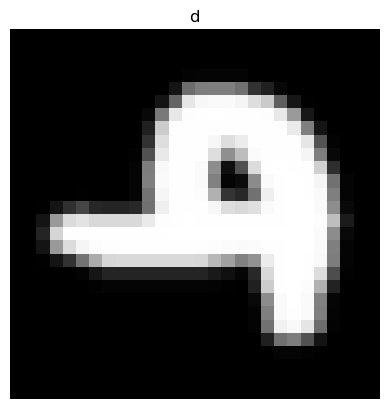

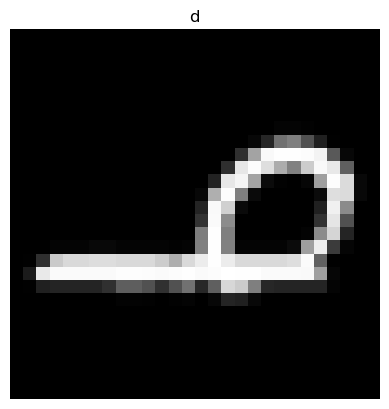

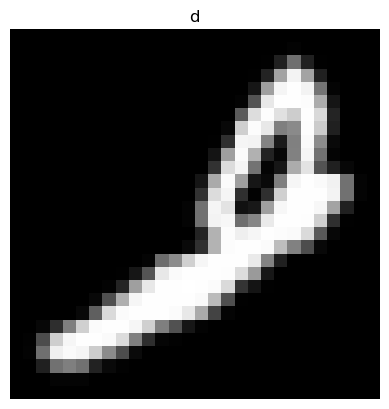

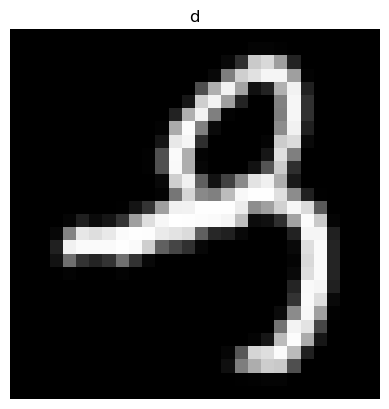

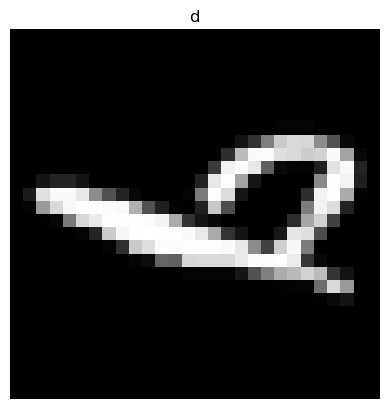

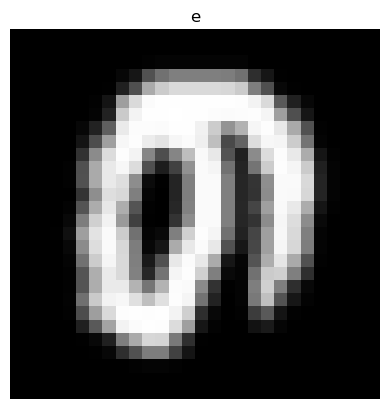

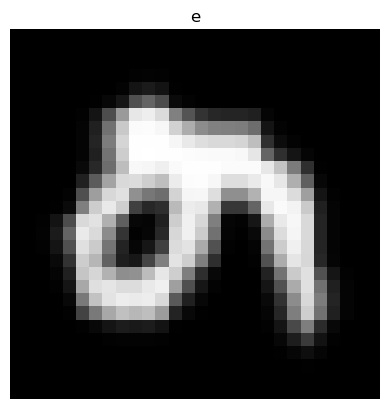

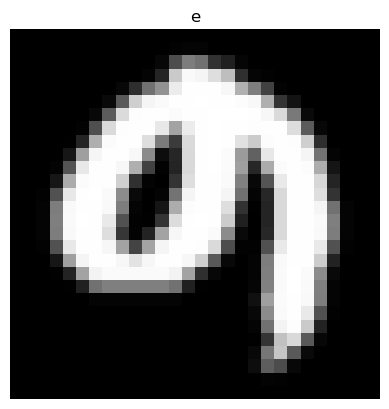

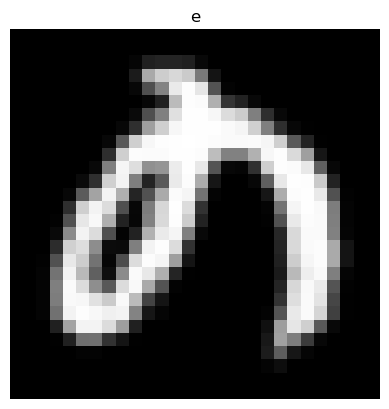

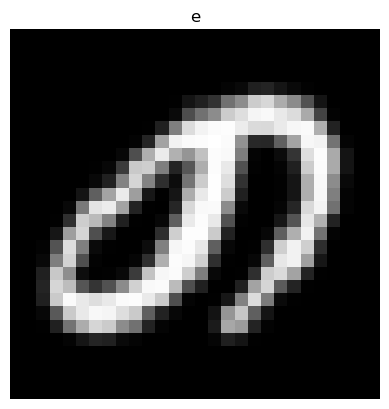

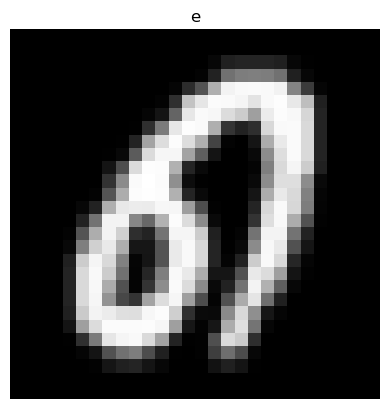

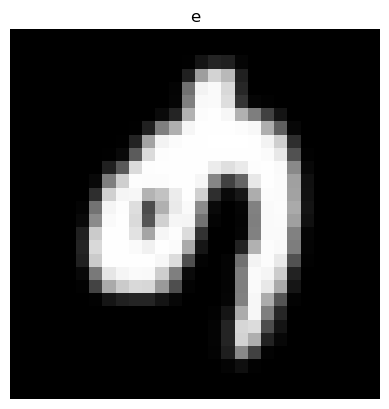

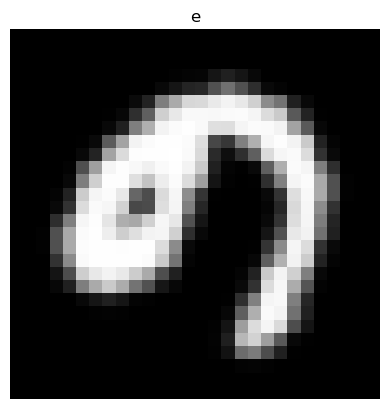

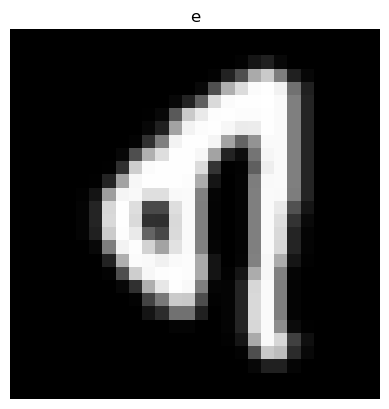

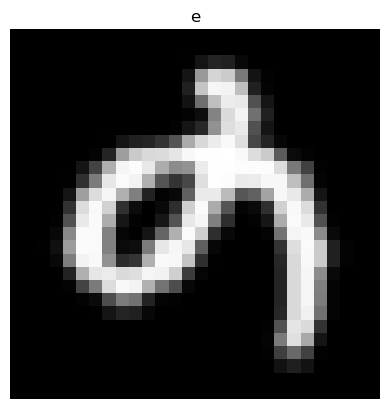

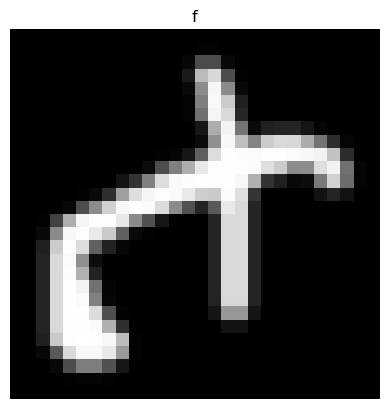

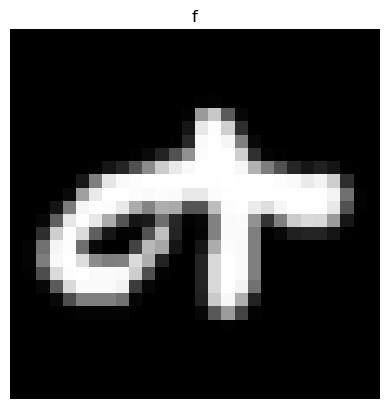

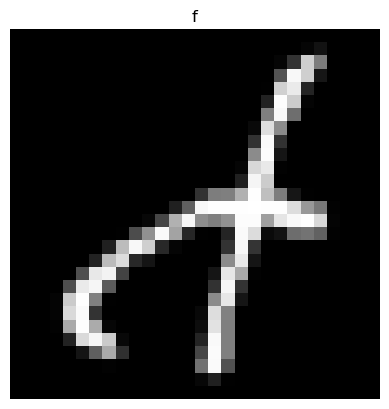

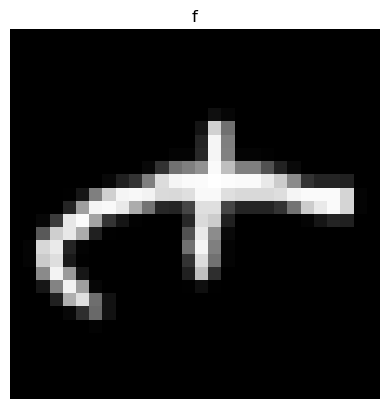

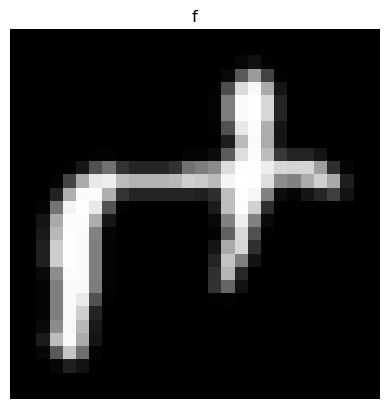

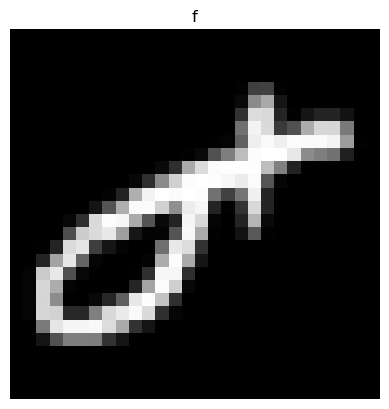

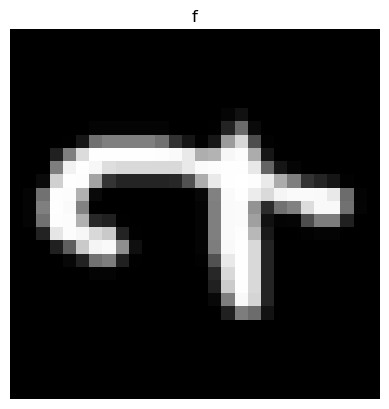

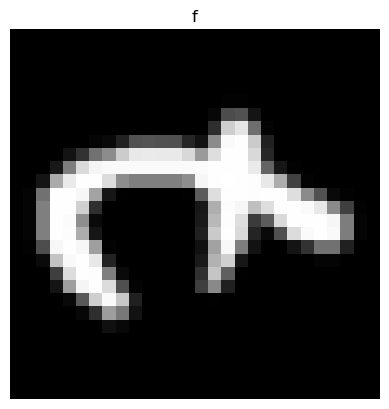

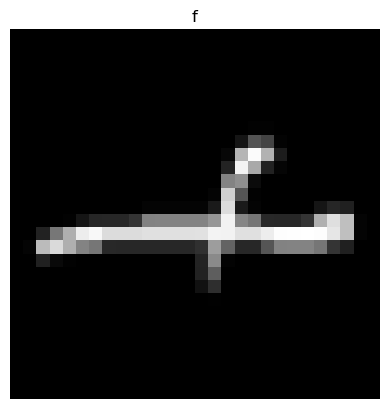

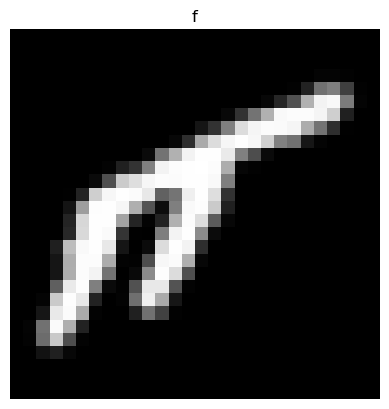

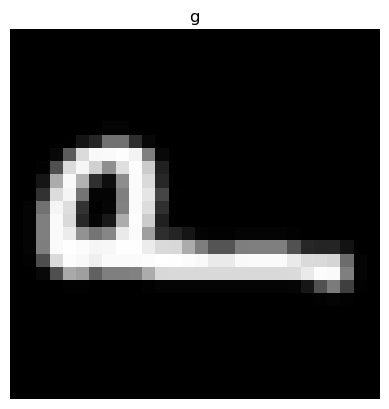

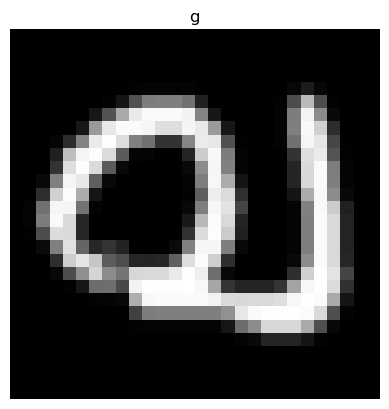

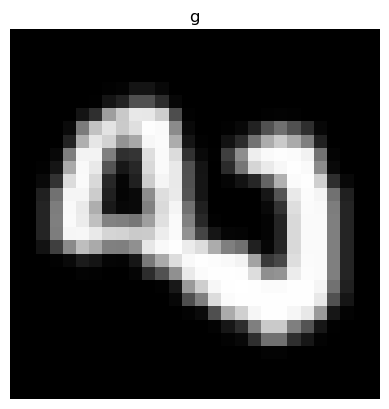

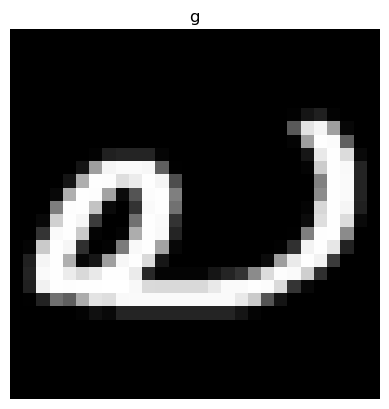

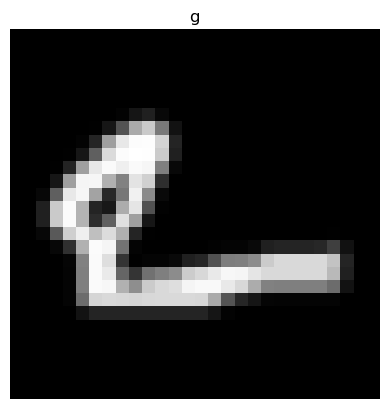

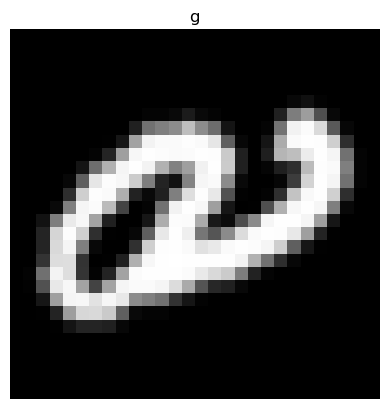

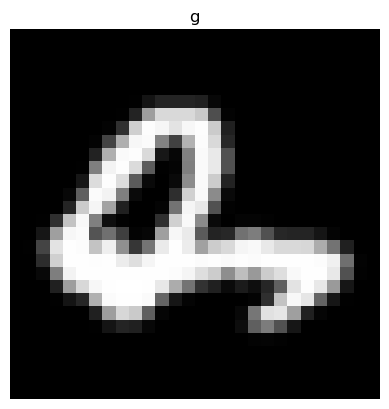

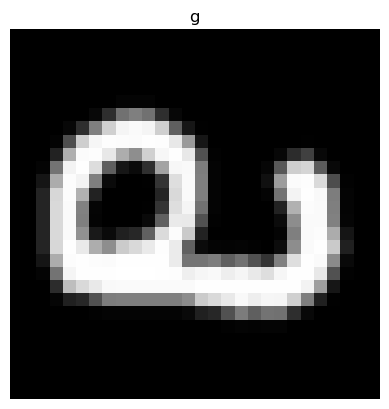

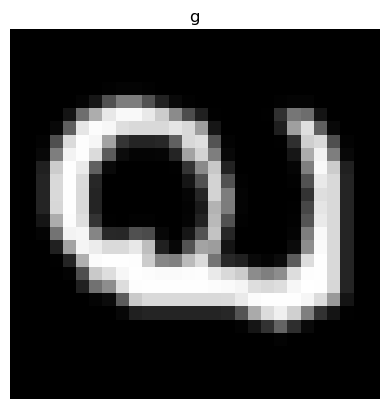

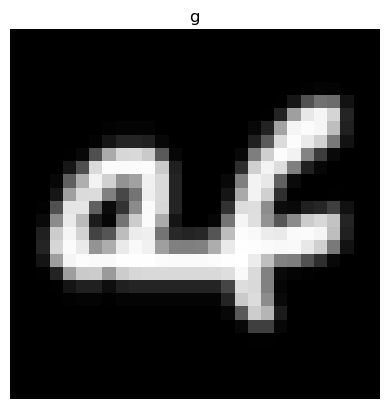

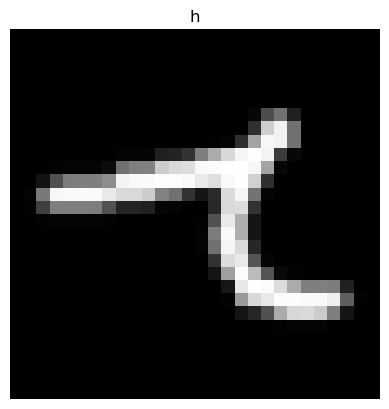

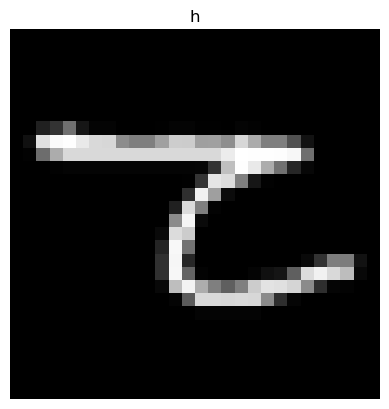

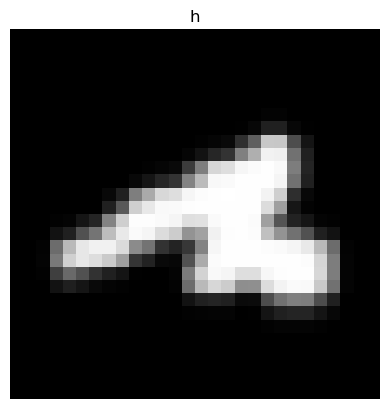

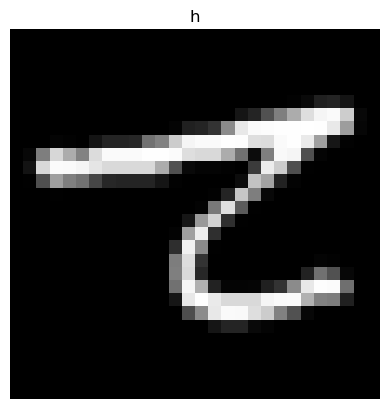

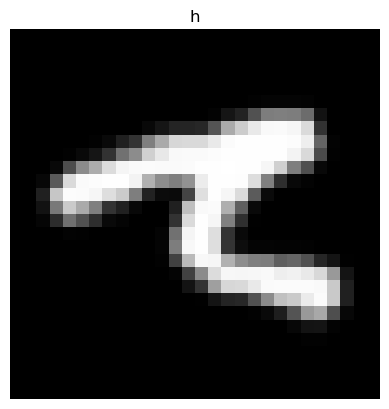

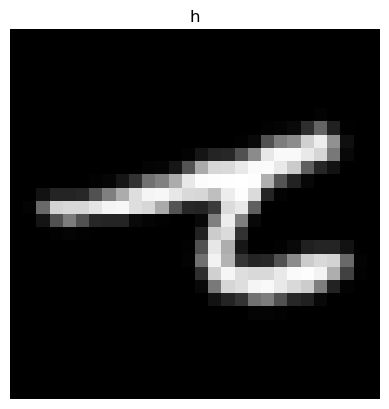

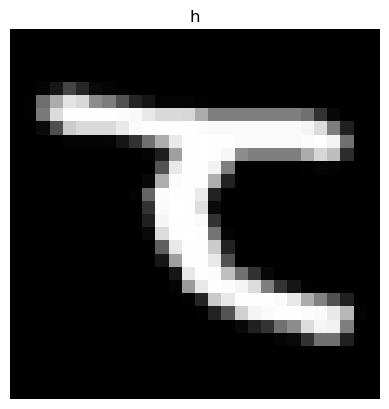

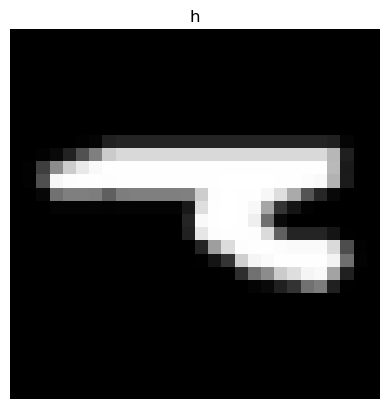

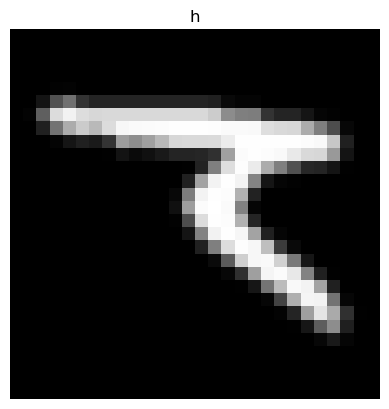

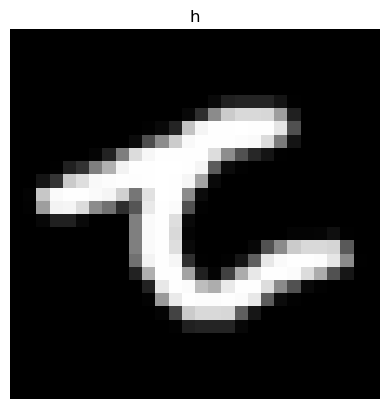

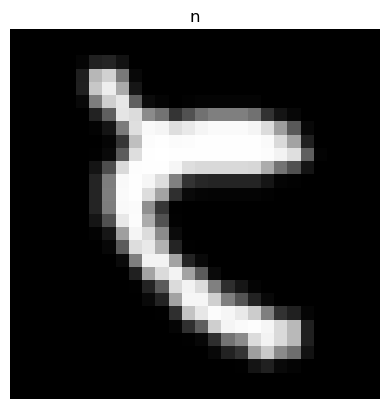

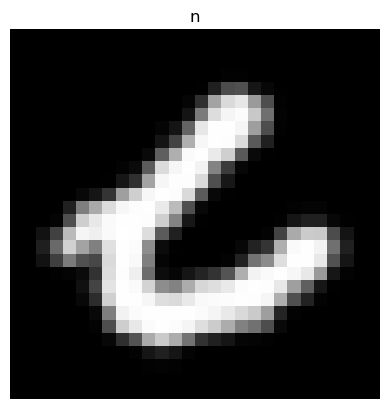

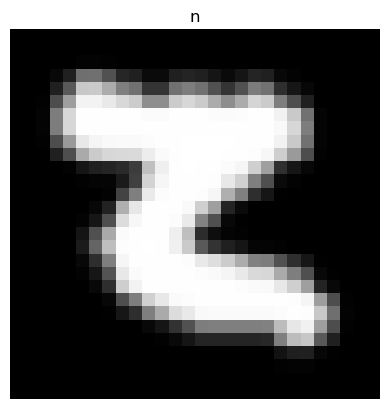

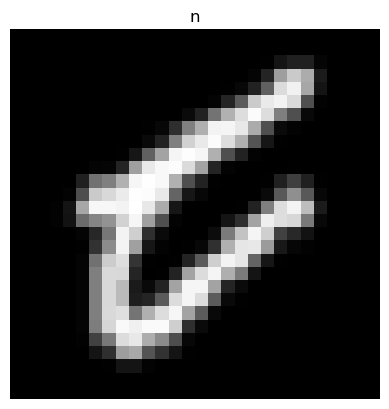

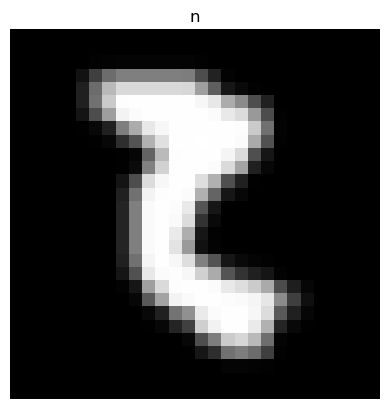

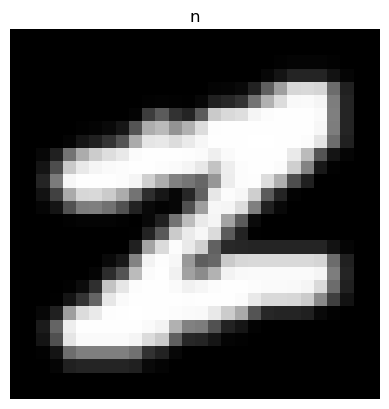

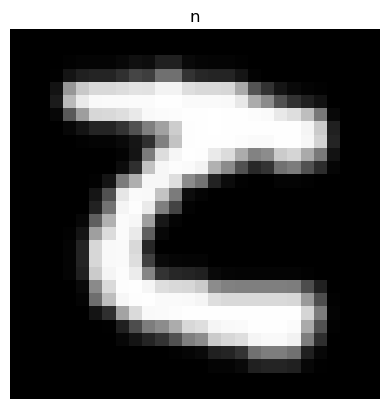

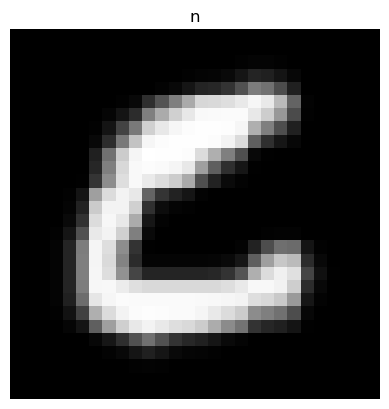

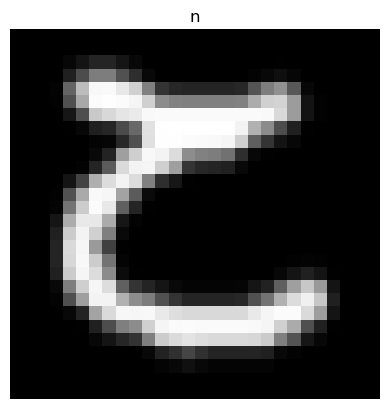

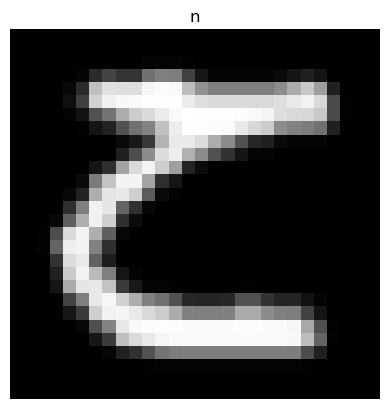

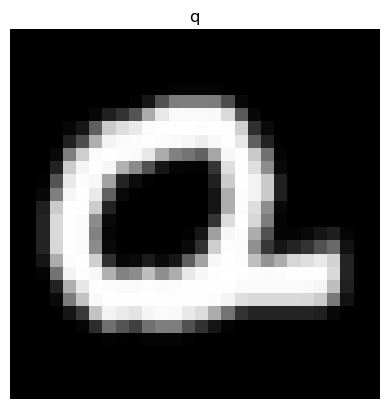

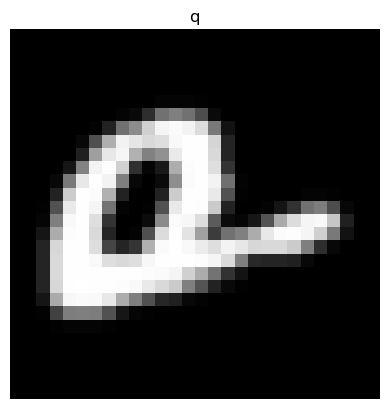

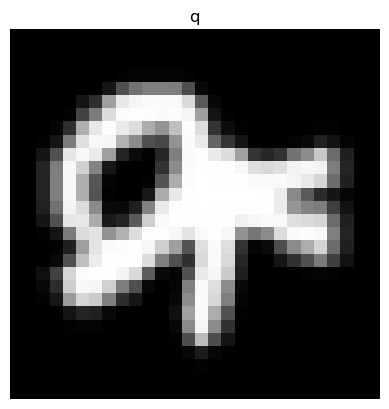

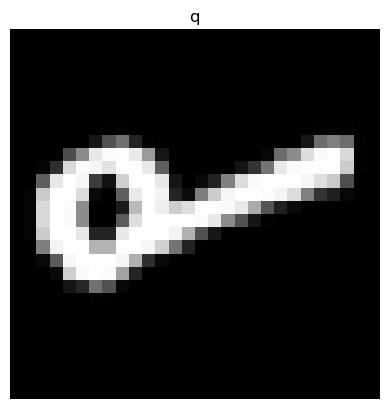

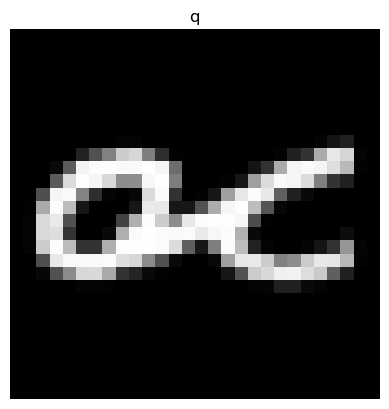

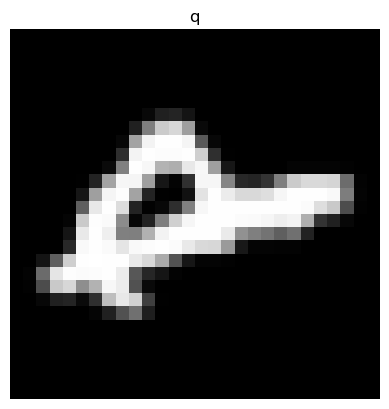

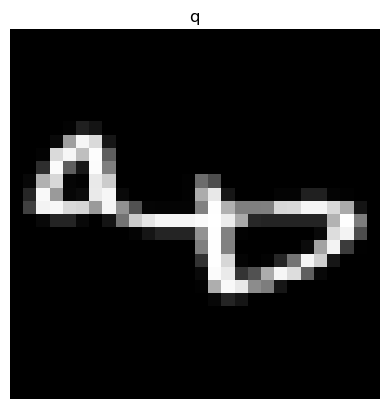

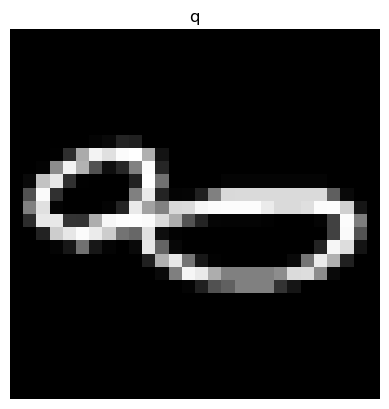

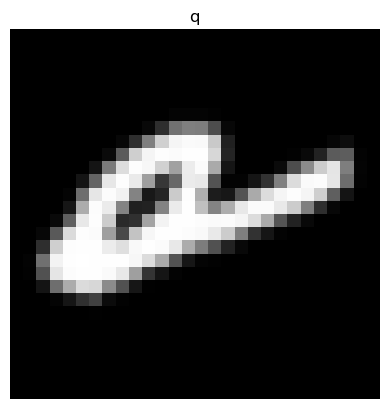

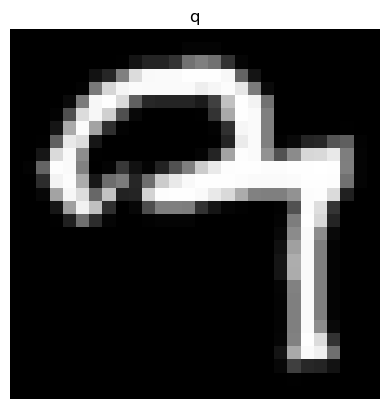

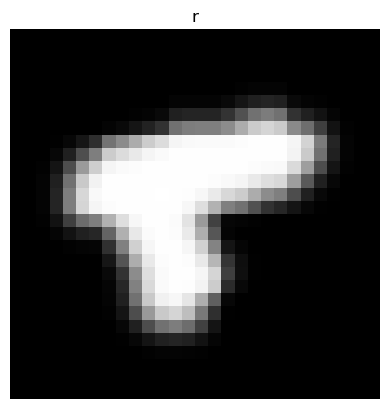

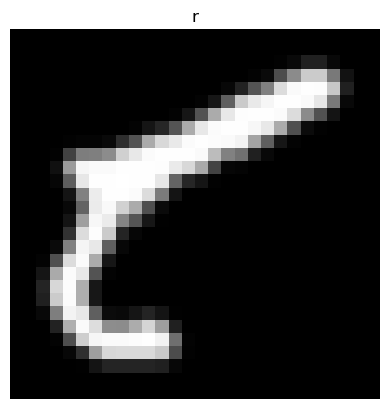

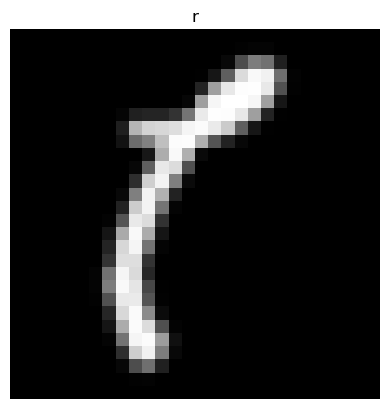

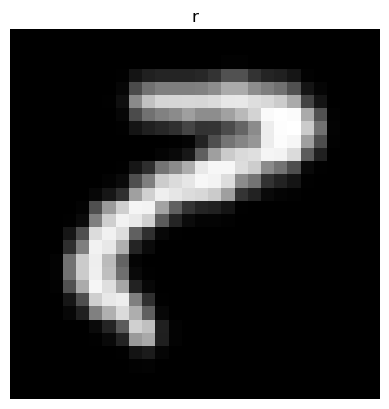

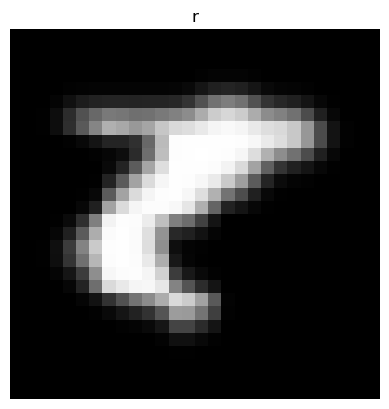

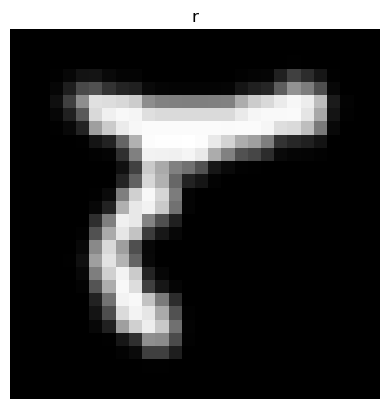

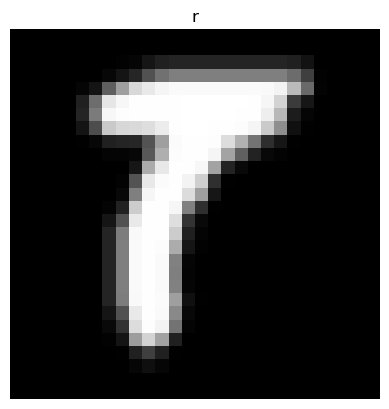

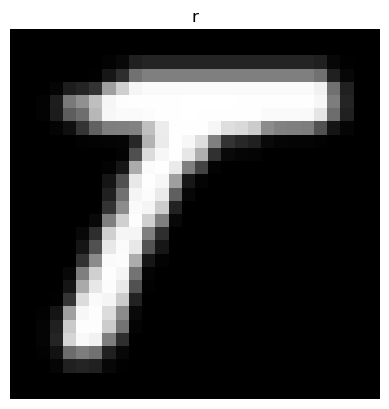

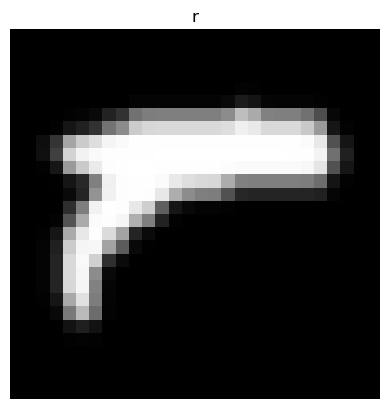

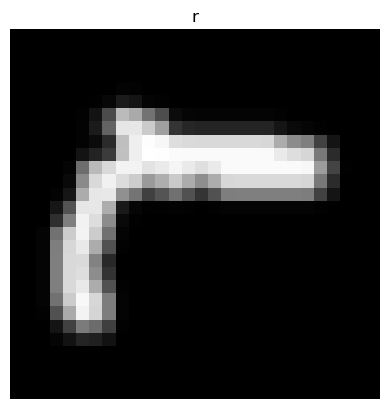

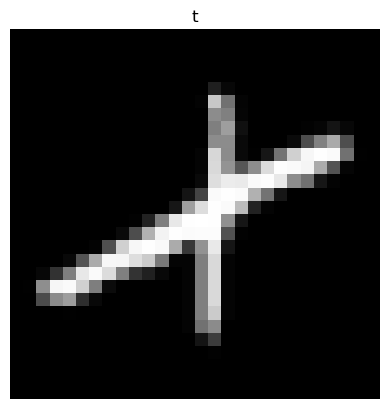

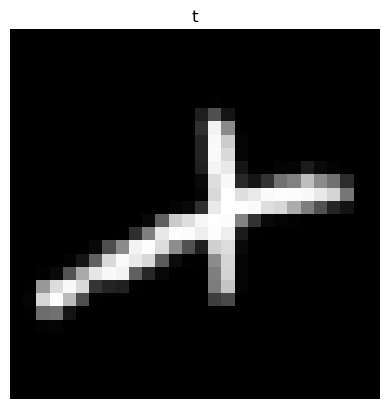

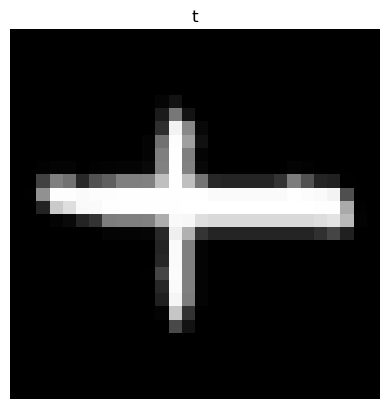

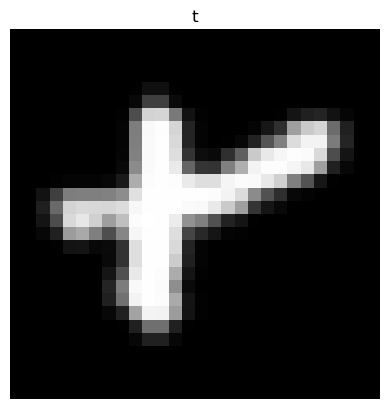

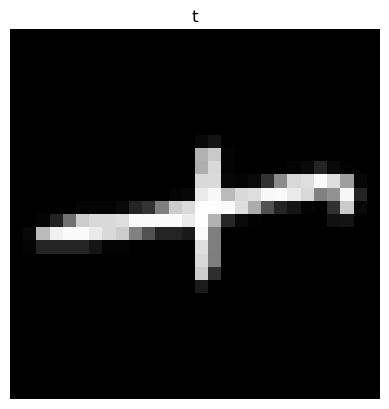

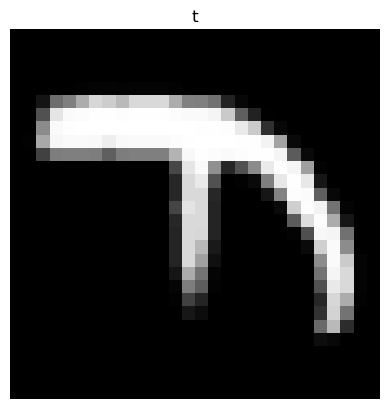

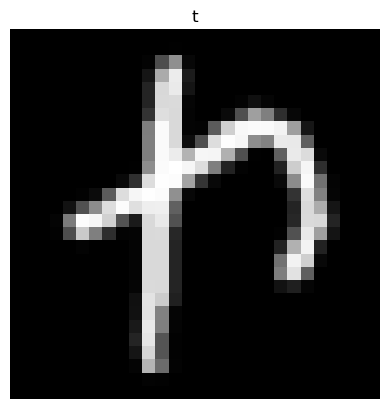

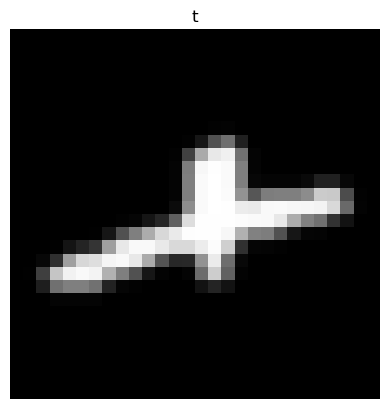

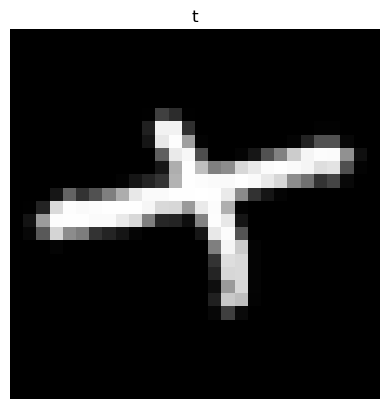

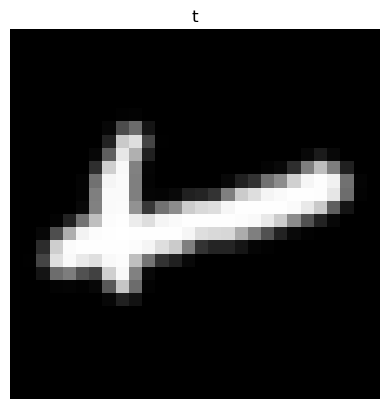

In [16]:
labels = range(int(y_train.min()), int(y_train.max())+1)

for i,label in enumerate(labels):
    label_indices = np.where(y_train == label)[0]
    selected_indices = np.random.choice(label_indices, 10, replace=False)
    char = class_to_char(label)
    for j,idx in enumerate(selected_indices):
        image_array = X_train[idx]
        display_array_as_image(image_array, char)

## MODEL

In [18]:
def prepare_labels_for_cnn(y):
    return to_categorical(y, num_classes=num_classes)

In [19]:
y_train = prepare_labels_for_cnn(y_train)
y_test = prepare_labels_for_cnn(y_test)

In [20]:
def create_cnn_model():
    l2_rate = 0.0005
    
    model = Sequential([
        # First Convolutional Block
        Input(shape=(28, 28, 1)), 
        Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(l2_rate)),
        BatchNormalization(),
        Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(l2_rate)),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.25),
        
        # Second Convolutional Block
        Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(l2_rate)),
        BatchNormalization(),
        Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(l2_rate)),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.25),
        
        # Third Convolutional Block
        Conv2D(128, (3, 3), activation='relu', kernel_regularizer=l2(l2_rate)),
        BatchNormalization(),
        Dropout(0.25),
        
        # Fully Connected Layers
        Flatten(),
        Dense(512, activation='relu', kernel_regularizer=l2(l2_rate)),
        BatchNormalization(),
        Dropout(0.5),
        Dense(256, activation='relu', kernel_regularizer=l2(l2_rate)),
        Dropout(0.5),
        
        # Output Layer
        Dense(num_classes, activation='softmax')
    ])
    return model



def create_cnn_model2():
    l2_rate = 0.0005
    
    # Input layer
    inputs = Input(shape=(28, 28, 1))
    
    # First Convolutional Block
    x = Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(l2_rate))(inputs)
    x = BatchNormalization()(x)
    x = Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(l2_rate))(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(0.25)(x)
    
    # Second Convolutional Block
    x = Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(l2_rate))(x)
    x = BatchNormalization()(x)
    x = Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(l2_rate))(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(0.25)(x)
    
    # Third Convolutional Block with Attention
    x = Conv2D(128, (3, 3), activation='relu', kernel_regularizer=l2(l2_rate))(x)
    x = BatchNormalization()(x)
    x = Dropout(0.25)(x)
    
    # Attention Mechanism
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    attention = GlobalAveragePooling2D()(x)
    attention = Dense(128, activation='sigmoid')(attention)
    attention = Reshape((1, 1, 128))(attention)
    x = Multiply()([x, attention])
    
    # Fully Connected Layers
    x = Flatten()(x)
    x = Dense(512, activation='relu', kernel_regularizer=l2(l2_rate))(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = Dense(256, activation='relu', kernel_regularizer=l2(l2_rate))(x)
    x = Dropout(0.5)(x)
    
    # Output Layer
    outputs = Dense(num_classes, activation='softmax')(x)
    
    # Create model
    model = Model(inputs=inputs, outputs=outputs)
    
    return model

In [25]:
print("\nCreating CNN model...")
model = create_cnn_model()


Creating CNN model...


In [27]:
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 26, 26, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 24, 24, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 12, 12, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 12, 12, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 10, 10, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 10, 10, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 8, 8, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 4, 4, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 4, 4, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 2, 2, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 2, 2, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 2, 2, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 47)             │        12,079 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 547,855 (2.09 MB)

 Trainable params: 546,383 (2.08 MB)

 Non-trainable params: 1,472 (5.75 KB)

In [29]:
callbacks = [
    EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=5,
        min_lr=0.0001
    )
]

print("\nTraining CNN model...")
history = model.fit(
    X_train, y_train,
    batch_size=128,
    epochs=50, 
    validation_data=(X_test, y_test),
    callbacks=callbacks,
    verbose=1
)

print("\n" + "="*60)
print("CNN TRAINING COMPLETE!")
print("="*60)



Training CNN model...
Epoch 1/50
5453/5453 ━━━━━━━━━━━━━━━━━━━━ 171s 31ms/step - accuracy: 0.7323 - loss: 1.3453 - val_accuracy: 0.8802 - val_loss: 0.5585 - learning_rate: 0.0010
Epoch 2/50
5453/5453 ━━━━━━━━━━━━━━━━━━━━ 166s 31ms/step - accuracy: 0.8624 - loss: 0.6266 - val_accuracy: 0.8833 - val_loss: 0.5429 - learning_rate: 0.0010
Epoch 3/50
5453/5453 ━━━━━━━━━━━━━━━━━━━━ 184s 34ms/step - accuracy: 0.8675 - loss: 0.6077 - val_accuracy: 0.8863 - val_loss: 0.5309 - learning_rate: 0.0010
Epoch 4/50
5453/5453 ━━━━━━━━━━━━━━━━━━━━ 187s 34ms/step - accuracy: 0.8698 - loss: 0.5972 - val_accuracy: 0.8906 - val_loss: 0.5203 - learning_rate: 0.0010
Epoch 5/50
5453/5453 ━━━━━━━━━━━━━━━━━━━━ 187s 34ms/step - accuracy: 0.8713 - loss: 0.5896 - val_accuracy: 0.8894 - val_loss: 0.5184 - learning_rate: 0.0010
Epoch 6/50
5453/5453 ━━━━━━━━━━━━━━━━━━━━ 187s 34ms/step - accuracy: 0.8728 - loss: 0.5796 - val_accuracy: 0.8862 - val_loss: 0.5132 - learning_rate: 0.0010
Epoch 7/50
5453/5453 ━━━━━━━━━━━━━━

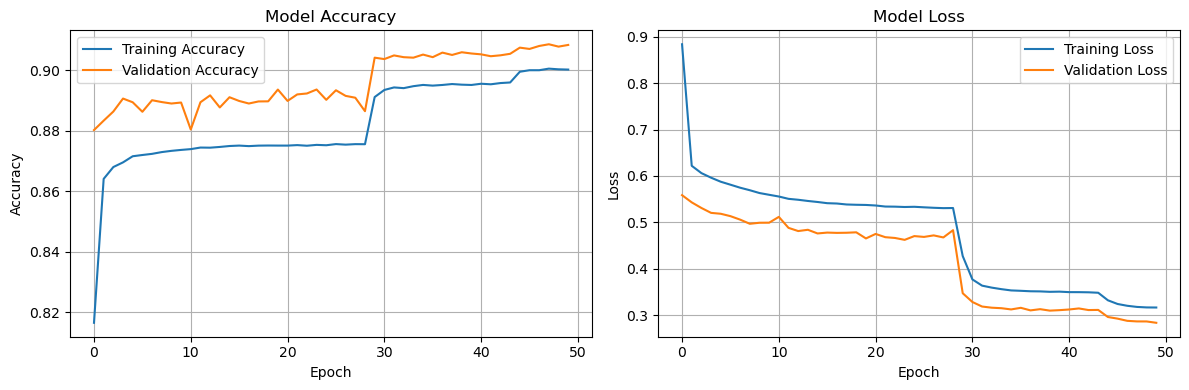

In [31]:
def plot_training_history(history):
    """
    Plot training and validation accuracy/loss
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    
    # Plot accuracy
    ax1.plot(history.history['accuracy'], label='Training Accuracy')
    ax1.plot(history.history['val_accuracy'], label='Validation Accuracy')
    ax1.set_title('Model Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy')
    ax1.legend()
    ax1.grid(True)
    
    # Plot loss
    ax2.plot(history.history['loss'], label='Training Loss')
    ax2.plot(history.history['val_loss'], label='Validation Loss')
    ax2.set_title('Model Loss')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.legend()
    ax2.grid(True)
    
    plt.tight_layout()
    plt.show()

plot_training_history(history)

In [33]:
print("\nEvaluating model on test data...")
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Accuracy: {test_accuracy:.4f}")

# Make predictions
print("\nMaking predictions...")
y_pred_proba = model.predict(X_test)
y_pred = np.argmax(y_pred_proba, axis=1)
y_true = np.argmax(y_test, axis=1)

# UPDATED: Create target names for classification report
target_names = [class_to_char(i) for i in range(36)]

# Classification report
print("\nClassification Report:")
print(classification_report(y_true, y_pred))


Evaluating model on test data...
Test Accuracy: 0.9083

Making predictions...
3636/3636 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step

Classification Report:
              precision    recall  f1-score   support

           0       0.70      0.82      0.75      5745
           1       0.69      0.90      0.78      6400
           2       0.97      0.97      0.97      5765
           3       0.99      1.00      0.99      5827
           4       0.98      0.98      0.98      5498
           5       0.98      0.92      0.95      5326
           6       0.98      0.98      0.98      5787
           7       0.99      1.00      0.99      5873
           8       0.99      0.99      0.99      5655
           9       0.93      0.98      0.95      5651
          10       0.95      0.98      0.96      1058
          11       0.95      0.98      0.96       652
          12       0.96      0.98      0.97      2156
          13       0.89      0.91      0.90       735
          14       0.98      0.98      0.9

In [35]:
name = "emnist.keras"

model.save('models/cnn/' + name)

## BENCHMARK

In [7]:
name1 = "alpha_test_cnn.keras" # 93.35
name2 = "alpha_test_50_cnn.keras"
name3 = "alpha_mnist_test_50_cnn.keras"
name4 = "alpha_mnist_attention_cnn.keras"
name5 = "emnist.keras"



model = tf.keras.models.load_model('models/cnn/' + name5)

In [9]:
    
def preprocess_image_for_cnn(image_path):
    try:
        img = Image.open(image_path)
        img = img.convert('L')
        img = img.resize((28, 28), Image.LANCZOS)

        """
        img_array1 = np.array(img, dtype=np.float32) / 255.0
        # Invert the pixel values to match the dataset (white on black)
        img_array1 = 1.0 - img_array1
        
        # --- Display the 2D array as an image (if function exists) ---
        display_array_as_image(img_array1)
        """
        
        if emnist:
            img = img.rotate(90, expand=False)  # Rotate 90° clockwise (-90)
            img = img.transpose(Image.FLIP_TOP_BOTTOM)  # Flip vertically
        
        img_array = np.array(img, dtype=np.float32) / 255.0
        # Invert the pixel values to match the dataset (white on black)
        img_array = 1.0 - img_array
        
        # --- Display the 2D array as an image (if function exists) ---
        # display_array_as_image(img_array) 
        
        cnn_array = img_array.reshape(1, 28, 28, 1)
        return cnn_array
        
    except FileNotFoundError:
        print(f"Error: The file at {image_path} was not found.")
        return None
    except Exception as e:
        print(f"An error occurred: {e}")
        return None

In [19]:
def benchmark_model(test_directory="testing_data/benchmark1"):
    
    if not os.path.exists(test_directory):
        print(f"Error: Test data directory '{test_directory}' not found!")
        return
    
    all_folders = [f for f in os.listdir(test_directory) if os.path.isdir(os.path.join(test_directory, f))]

    if not all_folders:
        print("No character folders found in test directory!")
        return
    
    character_folders = [f for f in all_folders if f.isupper() and len(f) == 1]
    numeric_folders = [f for f in all_folders if f.isdigit() and len(f) == 1]

    folders = []
    if alpha or alphanum:
        folders += character_folders
    if alphanum:
        folders += numeric_folders
    if emnist:
        folders = all_folders
    
    folders.sort()
    
    total_correct = 0
    total_images = 0
    overall_results = {}
    
    detailed_false_positives = {char: {} for char in folders}
    
    print(f"Benchmarking model on {len(folders)} character classes...")
    print("="*60)
    
    for true_char in folders:
        folder_path = os.path.join(test_directory, true_char)
        
        image_files = []
        for filename in os.listdir(folder_path):
            file_path = os.path.join(folder_path, filename)
            if os.path.isfile(file_path):
                image_files.append(filename)
        
        if not image_files:
            print(f"No images found in folder '{true_char}'")
            continue
        
        print(f"\nTesting character '{true_char}' ({len(image_files)} images):")
        
        prediction_counts = {}
        correct_predictions = 0
        
        for filename in image_files:
            image_path = os.path.join(folder_path, filename)
            preprocessed_image = preprocess_image_for_cnn(image_path)
            
            if preprocessed_image is not None:
                # Get prediction using alpha model# Add this debug line before model.predict()
                prediction_proba = model.predict(preprocessed_image, verbose=0)
                predicted_class_id = np.argmax(prediction_proba[0])
                predicted_char = class_to_char(predicted_class_id)
                confidence = np.max(prediction_proba[0])
                
                # Count predictions
                prediction_counts[predicted_char] = prediction_counts.get(predicted_char, 0) + 1
                
                # Check if prediction is correct
                if predicted_char == true_char:
                    correct_predictions += 1
                else:
                    # NEW: Update the detailed False Positive tracker
                    # The model predicted 'predicted_char' when the true label was 'true_char'
                    if true_char in detailed_false_positives[predicted_char]:
                        detailed_false_positives[predicted_char][true_char] += 1
                    else:
                        detailed_false_positives[predicted_char][true_char] = 1
                
                total_images += 1
        
        # Calculate accuracy for this character
        folder_accuracy = (correct_predictions / len(image_files)) * 100 if image_files else 0
        total_correct += correct_predictions
        
        # Display results for this character
        print(f"Predictions for '{true_char}':")
        sorted_predictions = sorted(prediction_counts.items(), key=lambda x: x[1], reverse=True)
        for pred_char, count in sorted_predictions:
            percentage = (count / len(image_files)) * 100
            marker = "✓" if pred_char == true_char else "✗"
            print(f"  {marker} {pred_char}: {count} times ({percentage:.1f}%)")
        
        print(f"Accuracy for '{true_char}': {correct_predictions}/{len(image_files)} ({folder_accuracy:.1f}%)")
        
        # Store results
        overall_results[true_char] = {
            'total_images': len(image_files),
            'correct_predictions': correct_predictions,
            'accuracy': folder_accuracy,
            'predictions': prediction_counts
        }
    
    # Calculate and display overall accuracy
    overall_accuracy = (total_correct / total_images) * 100 if total_images > 0 else 0
    
    print("\n" + "="*60)
    print("BENCHMARK SUMMARY (ALPHA MODEL)")
    print("="*60)
    print(f"Total images tested: {total_images}")
    print(f"Total correct predictions: {total_correct}")
    print(f"Overall accuracy: {overall_accuracy:.2f}%")
    
    # Display per-character summary including detailed FPs
    print("\nPer-character summary (Accuracy & Confusion):")
    for char in folders:
        results = overall_results.get(char, {'accuracy': 0.0, 'correct_predictions': 0, 'total_images': 0})
        fp_details = detailed_false_positives.get(char, {})
        
        # Calculate total False Positives for this character (how many times it was predicted incorrectly)
        total_fp = sum(fp_details.values())
        
        # Format the detailed FP string (e.g., "4-Y, 2-U")
        fp_list = []
        if total_fp > 0:
            # Sort by count descending for readability
            sorted_fp = sorted(fp_details.items(), key=lambda x: x[1], reverse=True)
            fp_list = [f"{count}-{true_char}" for true_char, count in sorted_fp]
            
        fp_str = ", ".join(fp_list) if fp_list else "None"
        
        print(f"  {char}: Acc={results['accuracy']:.1f}% ({results['correct_predictions']}/{results['total_images']})")
        print(f"      FP ({total_fp}): {fp_str}")
        
        # Store False Positives in the results structure
        overall_results[char]['false_positives_total'] = total_fp
        overall_results[char]['false_positives_details'] = fp_details
    
    # Find best and worst performing characters
    if overall_results:
        best_char = max(overall_results.items(), key=lambda x: x[1]['accuracy'])
        worst_char = min(overall_results.items(), key=lambda x: x[1]['accuracy'])
        
        print(f"\nBest performing: '{best_char[0]}' ({best_char[1]['accuracy']:.1f}%)")
        print(f"Worst performing: '{worst_char[0]}' ({worst_char[1]['accuracy']:.1f}%)")
    
    overall_accuracy = (total_correct / total_images) * 100 if total_images > 0 else 0
    
    print("\n" + "="*60)
    print("BENCHMARK SUMMARY (ALPHA MODEL)")
    print("="*60)
    print(f"Total images tested: {total_images}")
    print(f"Total correct predictions: {total_correct}")
    print(f"Overall accuracy: {overall_accuracy:.2f}%") # <-- THIS IS THE FINAL METRIC
    

In [21]:
benchmark_model()

Benchmarking model on 46 character classes...

Testing character '0' (153 images):
Predictions for '0':
  ✗ O: 138 times (90.2%)
  ✓ 0: 11 times (7.2%)
  ✗ a: 2 times (1.3%)
  ✗ e: 1 times (0.7%)
  ✗ D: 1 times (0.7%)
Accuracy for '0': 11/153 (7.2%)

Testing character '1' (156 images):
Predictions for '1':
  ✗ I: 75 times (48.1%)
  ✗ L: 60 times (38.5%)
  ✓ 1: 10 times (6.4%)
  ✗ n: 8 times (5.1%)
  ✗ h: 1 times (0.6%)
  ✗ T: 1 times (0.6%)
  ✗ S: 1 times (0.6%)
Accuracy for '1': 10/156 (6.4%)

Testing character '2' (128 images):
Predictions for '2':
  ✓ 2: 114 times (89.1%)
  ✗ 3: 8 times (6.2%)
  ✗ e: 3 times (2.3%)
  ✗ q: 2 times (1.6%)
  ✗ 9: 1 times (0.8%)
Accuracy for '2': 114/128 (89.1%)

Testing character '3' (108 images):
Predictions for '3':
  ✓ 3: 108 times (100.0%)
Accuracy for '3': 108/108 (100.0%)

Testing character '4' (93 images):
Predictions for '4':
  ✓ 4: 56 times (60.2%)
  ✗ h: 21 times (22.6%)
  ✗ U: 10 times (10.8%)
  ✗ Y: 5 times (5.4%)
  ✗ I: 1 times (1.1%)
Accu

In [15]:
alpha, alphanum, emnist = False, False, True

In [10]:
print(alpha, alphanum, emnist)

False False True


In [12]:
name1 = "alpha_test_cnn.keras" # 93.35
name2 = "alpha_test_50_cnn.keras" # 96.55
name3 = "alpha_mnist_test_50_cnn.keras" # 87.10
name4 = "alpha_mnist_attention_cnn.keras"
name5 = "emnist_cnn.h5" # 86.09



model = tf.keras.models.load_model('models/cnn/' + name5)